# Figures for Italy presentation

## Collapse study

### Setup

In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from doe import GP

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=20
axis_font = 18
subt_font = 18
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
pd.options.mode.chained_assignment = None  

### Collapse definitions

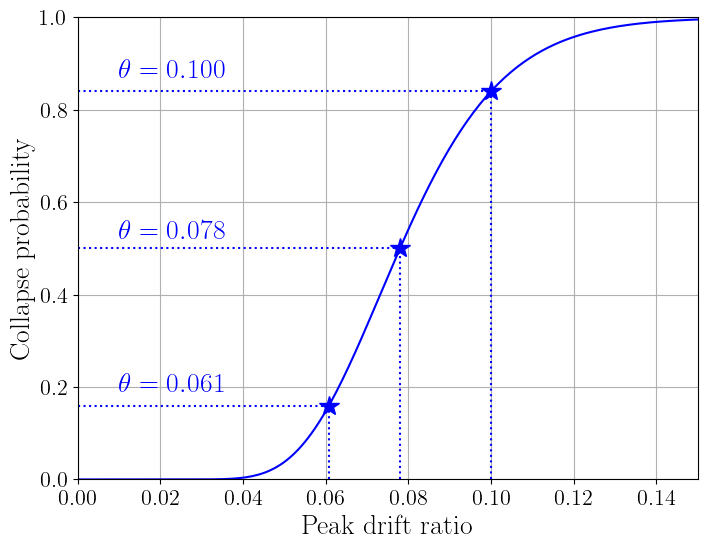

In [2]:

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# collapse as a probability
from scipy.stats import lognorm
from math import log, exp

collapse_drift_def_mu_std = 0.1


from scipy.stats import norm
inv_norm = norm.ppf(0.84)
beta_drift = 0.25
mean_log_drift = exp(log(collapse_drift_def_mu_std) - beta_drift*inv_norm) # 0.9945 is inverse normCDF of 0.84
# mean_log_drift = 0.05
ln_dist = lognorm(s=beta_drift, scale=mean_log_drift)

label_size = 16
clabel_size = 12
x = np.linspace(0, 0.15, 200)

mu = log(mean_log_drift)

ln_dist = lognorm(s=beta_drift, scale=mean_log_drift)
p = ln_dist.cdf(np.array(x))


fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(x, p, label='Collapse (peak)', color='blue')

mu_irr = log(0.01)
ln_dist_irr = lognorm(s=0.3, scale=exp(mu_irr))
p_irr = ln_dist_irr.cdf(np.array(x))

# ax.plot(x, p_irr, color='red', label='Irreparable (residual)')

axis_font = 20
subt_font = 18
xright = 0.0
xleft = 0.15
ax.set_ylim([0,1])
ax.set_xlim([0, xleft])
ax.set_ylabel('Collapse probability', fontsize=axis_font)
ax.set_xlabel('Peak drift ratio', fontsize=axis_font)

ax.vlines(x=exp(mu), ymin=0, ymax=0.5, color='blue', linestyle=":")
ax.hlines(y=0.5, xmin=xright, xmax=exp(mu), color='blue', linestyle=":")
ax.text(0.01, 0.52, r'$\theta = %.3f$'% mean_log_drift , fontsize=axis_font, color='blue')
ax.plot([exp(mu)], [0.5], marker='*', markersize=15, color="blue", linestyle=":")

upper = ln_dist.ppf(0.84)
ax.vlines(x=upper, ymin=0, ymax=0.84, color='blue', linestyle=":")
ax.hlines(y=0.84, xmin=xright, xmax=upper, color='blue', linestyle=":")
ax.text(0.01, 0.87, r'$\theta = %.3f$' % upper, fontsize=axis_font, color='blue')
ax.plot([upper], [0.84], marker='*', markersize=15, color="blue", linestyle=":")

lower= ln_dist.ppf(0.16)
ax.vlines(x=lower, ymin=0, ymax=0.16, color='blue', linestyle=":")
ax.hlines(y=0.16, xmin=xright, xmax=lower, color='blue', linestyle=":")
ax.text(0.01, 0.19, r'$\theta = %.3f$' % lower, fontsize=axis_font, color='blue')
ax.plot([lower], [0.16], marker='*', markersize=15, color="blue", linestyle=":")


# ax.set_title('Replacement fragility definition', fontsize=axis_font)
ax.grid()



### Load collapse only data

In [4]:
import time

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 20
subt_font = 20
import matplotlib as mpl
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
clabel_size = 16

main_obj_doe = pd.read_pickle('../../data/tfp_mf_db_doe_prestrat.pickle')
df_doe = main_obj_doe.doe_analysis


# from ast import literal_eval
# df_doe = pd.read_csv('../../data/doe/temp_save.csv', 
#                      converters={'PID': literal_eval,
#                                  'PFV': literal_eval,
#                                  'PFA': literal_eval,
#                                  'RID': literal_eval,
#                                  'beam': literal_eval,
#                                  'column': literal_eval})

collapse_drift_def_mu_std = 0.1

from experiment import collapse_fragility
df_doe[['max_drift',
   'collapse_prob']] = df_doe.apply(
       lambda row: collapse_fragility(row, mf_drift_mu_plus_std=collapse_drift_def_mu_std), 
       axis='columns', result_type='expand')



# df_doe = df_doe.drop(columns=['index'])

df_doe['max_drift'] = df_doe.PID.apply(max)
df_doe['log_drift'] = np.log(df_doe['max_drift'])

df_doe['max_velo'] = df_doe.PFV.apply(max)
df_doe['max_accel'] = df_doe.PFA.apply(max)

df_doe['T_ratio'] = df_doe['T_m'] / df_doe['T_fb']
df_doe['T_ratio_e'] = df_doe['T_m'] / df_doe['T_fbe']
pi = 3.14159
g = 386.4

zetaRef = [0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
BmRef   = [0.8, 1.0, 1.2, 1.5, 1.7, 1.9, 2.0]
df_doe['Bm'] = np.interp(df_doe['zeta_e'], zetaRef, BmRef)

df_doe['gap_ratio'] = (df_doe['constructed_moat']*4*pi**2)/ \
    (g*(df_doe['sa_tm']/df_doe['Bm'])*df_doe['T_m']**2)

    
print('% impact of DoE set:', sum(df_doe['impacted'])/df_doe.shape[0])
print('average drift:', df_doe['max_drift'].mean())

df_init = df_doe.head(50)

from loads import define_gravity_loads
config_dict = {
    'S_1' : 1.017,
    'k_ratio' : 10,
    'Q': 0.06,
    'num_frames' : 2,
    'num_bays' : 4,
    'num_stories' : 4,
    'L_bay': 30.0,
    'h_story': 13.0,
    'isolator_system' : 'TFP',
    'superstructure_system' : 'MF',
    'S_s' : 2.2815
}
(W_seis, W_super, w_on_frame, P_on_leaning_column,
       all_w_cases, all_plc_cases) = define_gravity_loads(config_dict)

% impact of DoE set: 0.31238095238095237
average drift: 0.01882744300948127


### GP (collapse, DoE)

In [5]:
mdl_doe = GP(df_doe)
covariate_list = ['gap_ratio', 'RI', 'T_ratio', 'zeta_e']
mdl_doe.set_covariates(covariate_list)
mdl_doe.set_outcome('collapse_prob')

kernel_name = 'rbf_iso'
mdl_doe.fit_gpr(kernel_name=kernel_name)

In [6]:
mdl_doe._raw_data.head()

,index,superstructure_system,isolator_system,num_frames,S_1,T_m,k_ratio,Q,moat_ampli,RI,...,impacted,run_status,max_drift,collapse_prob,log_collapse_prob,log_drift,max_velo,max_accel,T_ratio_e,Bm
0,712,MF,TFP,2.0,0.826826,2.960922,9.142109,0.068274,1.032281,0.631784,...,1,0,0.010705,3.528441e-08,-17.159825,-4.537046,49.4088,1.225549,1.898595,1.592384
0,1254,MF,TFP,2.0,1.019247,3.602107,8.005913,0.061673,1.116718,1.372092,...,1,0,0.017972,4.627148e-05,-9.980985,-4.018920,81.2547,2.542246,3.35326,1.516987
0,1961,MF,TFP,2.0,0.98444,2.576223,7.405661,0.087225,0.692393,1.902001,...,0,0,0.010915,4.800945e-08,-16.851868,-4.517581,54.7026,1.360375,1.678387,1.555801
0,3041,MF,TFP,2.0,1.288332,4.294,7.140792,0.068177,0.67732,2.018501,...,1,0,0.024334,1.169026e-03,-6.751585,-3.715888,96.4903,3.964700,3.751286,1.529386
0,164,MF,TFP,2.0,1.239783,2.581489,6.377776,0.096156,1.18329,0.837032,...,0,0,0.004075,1.834467e-16,-36.234608,-5.502801,59.1092,1.427849,2.602704,1.479538


### Contour for collapse design

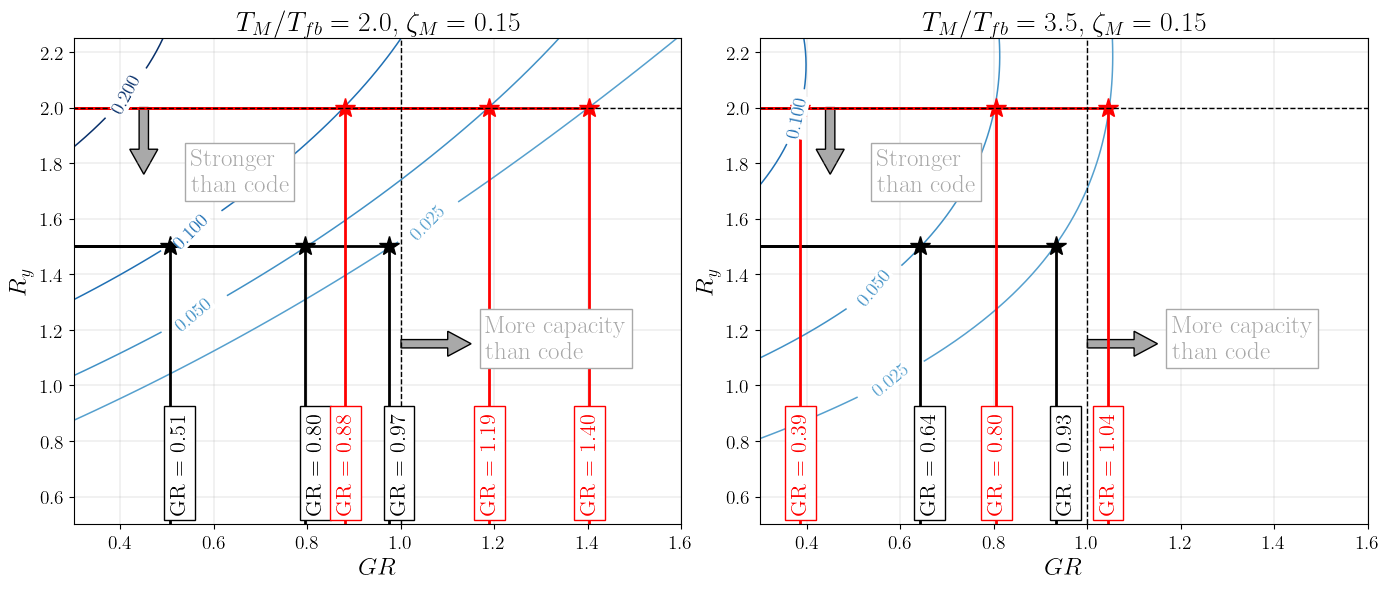

In [7]:
plt.close('all')

from inverse import make_2D_plotting_space

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=20
axis_font = 18
subt_font = 16
label_size = 14
clabel_size = 14
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

lvls = np.array([0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0])

res = 75
plt_density = 200
x_var = 'gap_ratio'
y_var = 'RI'
X_plot = make_2D_plotting_space(mdl_doe.X, res, x_var=x_var, y_var=y_var, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            x_bounds = [0.3, 2.0], y_bounds = [0.5, 2.25],
                            third_var_set = 2.0, fourth_var_set = 0.1)
xx = X_plot[x_var]
yy = X_plot[y_var]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

fmu_highlight = mdl_doe.gpr.predict(X_plot, return_std=False)

Z_highlight = fmu_highlight.reshape(xx_pl.shape)

fig = plt.figure(figsize=(14,6))



##########################################################################

X_plot = make_2D_plotting_space(mdl_doe.X, res, x_var=x_var, y_var=y_var, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            x_bounds = [0.3, 2.0], y_bounds = [0.5, 2.25],
                            third_var_set = 2.0, fourth_var_set = 0.15)
xx = X_plot[x_var]
yy = X_plot[y_var]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

fmu_highlight = mdl_doe.gpr.predict(X_plot, return_std=False)

Z_highlight = fmu_highlight.reshape(xx_pl.shape)

ax=fig.add_subplot(1, 2, 1)

# Plot the surface.
cmap = plt.cm.Blues
cs = ax.contour(xx_pl, yy_pl, Z_highlight, levels=lvls,  linewidths=1.1, cmap=cmap,
                vmin=-0.2, vmax=0.2)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

# draw lines for design targets

prob_list = [0.025, 0.05, 0.1]
from scipy.interpolate import RegularGridInterpolator
for j, prob_des in enumerate(prob_list):
    xq = np.linspace(0.3, 2.0, 200)
    
    Ry_target = 1.5
    
    interp = RegularGridInterpolator((y_pl, x_pl), Z_highlight)
    pts = np.zeros((200,2))
    pts[:,1] = xq
    pts[:,0] = Ry_target
    
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    theGap = xq[theGapIdx]
    ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='black',
                linewidth=2.0)
    ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='black', linewidth=2.0)
    ax.text(theGap, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
              fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
    ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='black')
    
    
    # Ry = 2.0
    Ry_target = 2.0
    pts[:,0] = Ry_target
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='red',
                linewidth=2.0)
    ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='red', linewidth=2.0)
    ax.text(theGap-0.02, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
              fontsize=subt_font, color='red', bbox=dict(facecolor='white', edgecolor='red'))
    ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='red')
   
# df_sc = mdl_doe._raw_data
# df_sc = df_sc[(df_sc['T_ratio'] < 2.5) &
#               (df_sc['T_ratio'] > 1.5)]
 
# plt.scatter(df_sc['gap_ratio'][:50], df_sc['RI'][:50], 
#             c=df_sc['collapse_prob'][:50], alpha=0.6,
#             edgecolors='k', s=20.0, cmap=plt.cm.Blues, vmax=5e-1)

ax.vlines(x=1.0, ymin=0, ymax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.hlines(y=2.0, xmin=0.0, xmax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.text(0.55, 1.7, 'Stronger\n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(0.45, 2.0, 0.0, -0.15, width=0.02, facecolor='darkgray', edgecolor='black')
ax.text(1.18, 1.1, 'More capacity \n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(1.0, 1.15, 0.1, 0.0, width=0.03, head_length=0.05, facecolor='darkgray', edgecolor='black')

ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)
ax.set_title(r' $T_M/T_{fb} = 2.0$, $\zeta_M = 0.15$', fontsize=title_font)
ax.set_xlim([0.3, 1.6])
ax.set_ylim([0.5, 2.25])
ax.grid(linewidth=0.25)

########################################
ax=fig.add_subplot(1, 2, 2)

X_plot = make_2D_plotting_space(mdl_doe.X, res, x_var=x_var, y_var=y_var, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            x_bounds = [0.3, 2.0], y_bounds = [0.5, 2.25],
                            third_var_set = 3.5, fourth_var_set = 0.15)
xx = X_plot[x_var]
yy = X_plot[y_var]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

fmu_highlight = mdl_doe.gpr.predict(X_plot, return_std=False)

Z_highlight = fmu_highlight.reshape(xx_pl.shape)

# Plot the surface.
cmap = plt.cm.Blues
cs = ax.contour(xx_pl, yy_pl, Z_highlight, levels=lvls,  linewidths=1.1, cmap=cmap,
                vmin=-0.2, vmax=0.2)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

# draw lines for design targets

prob_list = [0.025, 0.05, 0.1]
from scipy.interpolate import RegularGridInterpolator
for j, prob_des in enumerate(prob_list):
    xq = np.linspace(0.3, 2.0, 200)
    
    Ry_target = 1.5
    
    interp = RegularGridInterpolator((y_pl, x_pl), Z_highlight)
    pts = np.zeros((200,2))
    pts[:,1] = xq
    pts[:,0] = Ry_target
    
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    if theGap > 0.31:
    
        ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='black',
                    linewidth=2.0)
        ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='black', linewidth=2.0)
        ax.text(theGap, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
                fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
        ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='black')
    
    
    # Ry = 2.0
    Ry_target = 2.0
    pts[:,0] = Ry_target
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    if theGap > 0.31:
    
        ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='red',
                    linewidth=2.0)
        ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='red', linewidth=2.0)
        ax.text(theGap-0.02, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
                fontsize=subt_font, color='red', bbox=dict(facecolor='white', edgecolor='red'))
        ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='red')
 
# df_sc = mdl_doe._raw_data
# df_sc = df_sc[(df_sc['T_ratio'] < 3.0) &
#               (df_sc['T_ratio'] > 4.0)]
   
# plt.scatter(df_sc['gap_ratio'][:50], df_sc['RI'][:50], 
#             c=df_sc['collapse_prob'][:50], alpha=0.6,
#             edgecolors='k', s=20.0, cmap=plt.cm.Blues, vmax=5e-1)

ax.vlines(x=1.0, ymin=0, ymax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.hlines(y=2.0, xmin=0.0, xmax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.text(0.55, 1.7, 'Stronger\n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(0.45, 2.0, 0.0, -0.15, width=0.02, facecolor='darkgray', edgecolor='black')
ax.text(1.18, 1.1, 'More capacity \n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(1.0, 1.15, 0.1, 0.0, width=0.03, head_length=0.05, facecolor='darkgray', edgecolor='black')

ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)
ax.set_title(r' $T_M/T_{fb} = 3.5$, $\zeta_M = 0.15$', fontsize=title_font)
ax.set_xlim([0.3, 1.6])
ax.set_ylim([0.5, 2.25])
ax.grid(linewidth=0.25)
##########################################################################

    
fig.tight_layout(w_pad=0.2)

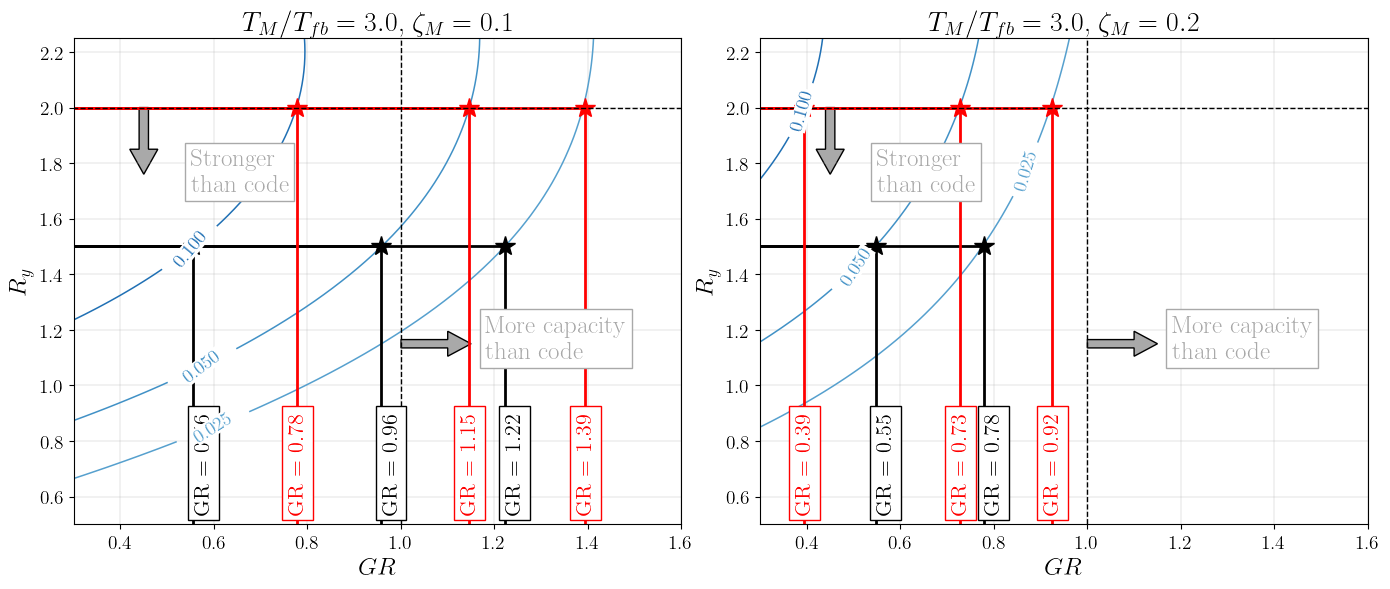

In [8]:
plt.close('all')

from inverse import make_2D_plotting_space

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=20
axis_font = 18
subt_font = 16
label_size = 14
clabel_size = 14
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

lvls = np.array([0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0])

res = 75
plt_density = 200
x_var = 'gap_ratio'
y_var = 'RI'
X_plot = make_2D_plotting_space(mdl_doe.X, res, x_var=x_var, y_var=y_var, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            x_bounds = [0.3, 2.0], y_bounds = [0.5, 2.25],
                            third_var_set = 2.0, fourth_var_set = 0.1)
xx = X_plot[x_var]
yy = X_plot[y_var]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

fmu_highlight = mdl_doe.gpr.predict(X_plot, return_std=False)

Z_highlight = fmu_highlight.reshape(xx_pl.shape)

fig = plt.figure(figsize=(14,6))



##########################################################################

X_plot = make_2D_plotting_space(mdl_doe.X, res, x_var=x_var, y_var=y_var, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            x_bounds = [0.3, 2.0], y_bounds = [0.5, 2.25],
                            third_var_set = 3.0, fourth_var_set = 0.1)
xx = X_plot[x_var]
yy = X_plot[y_var]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

fmu_highlight = mdl_doe.gpr.predict(X_plot, return_std=False)

Z_highlight = fmu_highlight.reshape(xx_pl.shape)

ax=fig.add_subplot(1, 2, 1)

# Plot the surface.
cmap = plt.cm.Blues
cs = ax.contour(xx_pl, yy_pl, Z_highlight, levels=lvls,  linewidths=1.1, cmap=cmap,
                vmin=-0.2, vmax=0.2)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

# draw lines for design targets

prob_list = [0.025, 0.05, 0.1]
from scipy.interpolate import RegularGridInterpolator
for j, prob_des in enumerate(prob_list):
    xq = np.linspace(0.3, 2.0, 200)
    
    Ry_target = 1.5
    
    interp = RegularGridInterpolator((y_pl, x_pl), Z_highlight)
    pts = np.zeros((200,2))
    pts[:,1] = xq
    pts[:,0] = Ry_target
    
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    theGap = xq[theGapIdx]
    ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='black',
                linewidth=2.0)
    ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='black', linewidth=2.0)
    ax.text(theGap, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
              fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
    ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='black')
    
    
    # Ry = 2.0
    Ry_target = 2.0
    pts[:,0] = Ry_target
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='red',
                linewidth=2.0)
    ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='red', linewidth=2.0)
    ax.text(theGap-0.02, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
              fontsize=subt_font, color='red', bbox=dict(facecolor='white', edgecolor='red'))
    ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='red')
   
# df_sc = mdl_doe._raw_data
# df_sc = df_sc[(df_sc['T_ratio'] < 2.5) &
#               (df_sc['T_ratio'] > 1.5)]
 
# plt.scatter(df_sc['gap_ratio'][:50], df_sc['RI'][:50], 
#             c=df_sc['collapse_prob'][:50], alpha=0.6,
#             edgecolors='k', s=20.0, cmap=plt.cm.Blues, vmax=5e-1)

ax.vlines(x=1.0, ymin=0, ymax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.hlines(y=2.0, xmin=0.0, xmax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.text(0.55, 1.7, 'Stronger\n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(0.45, 2.0, 0.0, -0.15, width=0.02, facecolor='darkgray', edgecolor='black')
ax.text(1.18, 1.1, 'More capacity \n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(1.0, 1.15, 0.1, 0.0, width=0.03, head_length=0.05, facecolor='darkgray', edgecolor='black')

ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)
ax.set_title(r' $T_M/T_{fb} = 3.0$, $\zeta_M = 0.1$', fontsize=title_font)
ax.set_xlim([0.3, 1.6])
ax.set_ylim([0.5, 2.25])
ax.grid(linewidth=0.25)

########################################
ax=fig.add_subplot(1, 2, 2)

X_plot = make_2D_plotting_space(mdl_doe.X, res, x_var=x_var, y_var=y_var, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            x_bounds = [0.3, 2.0], y_bounds = [0.5, 2.25],
                            third_var_set = 3.0, fourth_var_set = 0.2)
xx = X_plot[x_var]
yy = X_plot[y_var]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

fmu_highlight = mdl_doe.gpr.predict(X_plot, return_std=False)

Z_highlight = fmu_highlight.reshape(xx_pl.shape)

# Plot the surface.
cmap = plt.cm.Blues
cs = ax.contour(xx_pl, yy_pl, Z_highlight, levels=lvls,  linewidths=1.1, cmap=cmap,
                vmin=-0.2, vmax=0.2)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

# draw lines for design targets

prob_list = [0.025, 0.05, 0.1]
from scipy.interpolate import RegularGridInterpolator
for j, prob_des in enumerate(prob_list):
    xq = np.linspace(0.3, 2.0, 200)
    
    Ry_target = 1.5
    
    interp = RegularGridInterpolator((y_pl, x_pl), Z_highlight)
    pts = np.zeros((200,2))
    pts[:,1] = xq
    pts[:,0] = Ry_target
    
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    if theGap > 0.31:
    
        ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='black',
                    linewidth=2.0)
        ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='black', linewidth=2.0)
        ax.text(theGap, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
                fontsize=subt_font, color='black', bbox=dict(facecolor='white', edgecolor='black'))
        ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='black')
    
    
    # Ry = 2.0
    Ry_target = 2.0
    pts[:,0] = Ry_target
    lq = interp(pts)
    
    the_points = np.vstack((pts[:,0], pts[:,1], lq))
    
    theGapIdx = np.argmin(abs(lq - prob_des))
    
    theGap = xq[theGapIdx]
    if theGap > 0.31:
    
        ax.vlines(x=theGap, ymin=0.49, ymax=Ry_target, color='red',
                    linewidth=2.0)
        ax.hlines(y=Ry_target, xmin=0.3, xmax=theGap, color='red', linewidth=2.0)
        ax.text(theGap-0.02, 0.55, r'GR = '+f'{theGap:,.2f}', rotation=90,
                fontsize=subt_font, color='red', bbox=dict(facecolor='white', edgecolor='red'))
        ax.plot([theGap], [Ry_target], marker='*', markersize=15, color='red')
 
# df_sc = mdl_doe._raw_data
# df_sc = df_sc[(df_sc['T_ratio'] < 3.0) &
#               (df_sc['T_ratio'] > 4.0)]
   
# plt.scatter(df_sc['gap_ratio'][:50], df_sc['RI'][:50], 
#             c=df_sc['collapse_prob'][:50], alpha=0.6,
#             edgecolors='k', s=20.0, cmap=plt.cm.Blues, vmax=5e-1)

ax.vlines(x=1.0, ymin=0, ymax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.hlines(y=2.0, xmin=0.0, xmax=3.0, color='black', linestyles='--',
          linewidth=1.0)   
ax.text(0.55, 1.7, 'Stronger\n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(0.45, 2.0, 0.0, -0.15, width=0.02, facecolor='darkgray', edgecolor='black')
ax.text(1.18, 1.1, 'More capacity \n than code',
          fontsize=axis_font, color='darkgray', bbox=dict(facecolor='white', edgecolor='darkgray'))
ax.arrow(1.0, 1.15, 0.1, 0.0, width=0.03, head_length=0.05, facecolor='darkgray', edgecolor='black')

ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)
ax.set_title(r' $T_M/T_{fb} = 3.0$, $\zeta_M = 0.2$', fontsize=title_font)
ax.set_xlim([0.3, 1.6])
ax.set_ylim([0.5, 2.25])
ax.grid(linewidth=0.25)
##########################################################################
    
fig.tight_layout(w_pad=0.2)

### Validation fragility for collapse

In [9]:
def df_collapse(df, drift_mu_plus_std=0.1):
    
    from experiment import collapse_fragility
    df[['max_drift',
       'collapse_prob']] = df.apply(
           lambda row: collapse_fragility(
               row, mf_drift_mu_plus_std=drift_mu_plus_std), 
           axis='columns', result_type='expand')
                           
    from numpy import log
    df['log_collapse_prob'] = log(df['collapse_prob'])
    
    return df
    

#%% full validation (IDA data)

val_dir = '../../data/validation/'

val_10_file = 'tfp_mf_db_ida_10.pickle'
val_5_file = 'tfp_mf_db_ida_5.pickle'
val_2_file = 'tfp_mf_db_ida_2_5.pickle'
baseline_file = 'tfp_mf_db_ida_baseline.pickle'

main_obj_val = pd.read_pickle(val_dir+val_10_file)
df_val_10 = df_collapse(main_obj_val.ida_results)
df_val_10 = df_val_10.reset_index(drop=True)

main_obj_val = pd.read_pickle(val_dir+val_5_file)
df_val_5 = df_collapse(main_obj_val.ida_results)
df_val_5 = df_val_5.reset_index(drop=True)

main_obj_val = pd.read_pickle(val_dir+val_2_file)
df_val_2_5 = df_collapse(main_obj_val.ida_results)
df_val_2_5 = df_val_2_5.reset_index(drop=True)

main_obj_val = pd.read_pickle(val_dir+baseline_file)
df_base = df_collapse(main_obj_val.ida_results)
df_base = df_base.reset_index(drop=True)

ida_levels = [1.0, 1.5, 2.0]
val_10_collapse = np.zeros((3,))
val_5_collapse = np.zeros((3,))
val_2_collapse = np.zeros((3,))
baseline_collapse = np.zeros((3,))

for i, lvl in enumerate(ida_levels):
    val_10_ida = df_val_10[df_val_10['ida_level']==lvl]
    val_5_ida = df_val_5[df_val_5['ida_level']==lvl]
    val_2_ida = df_val_2_5[df_val_2_5['ida_level']==lvl]
    base_ida = df_base[df_base['ida_level']==lvl]
    
    val_10_collapse[i] = val_10_ida['collapse_prob'].mean()
    val_5_collapse[i] = val_5_ida['collapse_prob'].mean()
    val_2_collapse[i] = val_2_ida['collapse_prob'].mean()
    
    baseline_collapse[i] = base_ida['collapse_prob'].mean()

C:\Users\giraf\AppData\Local\Temp\ipykernel_16340\1388381812.py:7: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(likelihood)


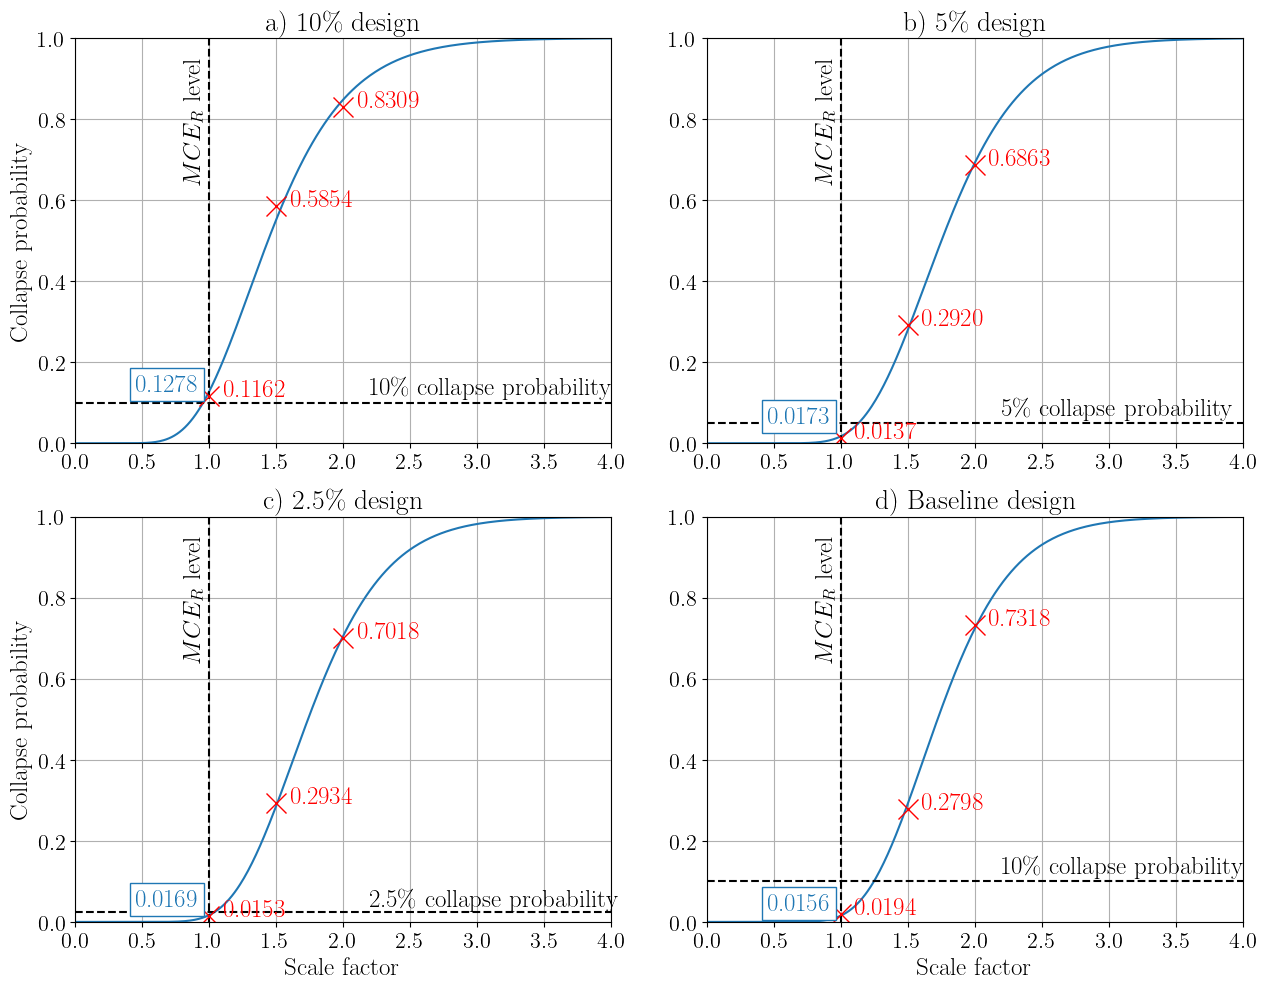

In [10]:
def neg_log_likelihood_sum(params, im_l, no_a, no_c):
    from scipy import stats
    import numpy as np
    sigma, beta = params
    theoretical_fragility_function = stats.norm(np.log(sigma), beta).cdf(im_l)
    likelihood = stats.binom.pmf(no_c, no_a, theoretical_fragility_function)
    log_likelihood = np.log(likelihood)
    log_likelihood_sum = np.sum(log_likelihood)

    return -log_likelihood_sum

def mle_fit_collapse(ida_levels, pr_collapse):
    from functools import partial
    import numpy as np
    from scipy import optimize
    
    im_log = np.log(ida_levels)
    number_of_analyses = np.array([1000, 1000, 1000 ])
    number_of_collapses = np.round(1000*pr_collapse)
    
    neg_log_likelihood_sum_partial = partial(
        neg_log_likelihood_sum, im_l=im_log, no_a=number_of_analyses, no_c=number_of_collapses)
    
    
    res = optimize.minimize(neg_log_likelihood_sum_partial, (1, 1), method="Nelder-Mead")
    return res.x[0], res.x[1]


from scipy.stats import norm
f = lambda x,theta,beta: norm(np.log(theta), beta).cdf(np.log(x))

color = plt.cm.tab10(np.linspace(0, 1, 10))

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 18
subt_font = 18
label_size = 16
title_font=20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
plt.close('all')

fig = plt.figure(figsize=(13, 10))

b_TOT = np.linalg.norm([0.2, 0.2, 0.2, 0.4])

theta_10, beta_10 = mle_fit_collapse(ida_levels,val_10_collapse)

xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_10, beta_10)
p2 = f(xx_pr, theta_10, b_TOT)

MCE_level = float(p[xx_pr==1.0])
MCE_level_unc = float(p2[xx_pr==1.0])
ax1=fig.add_subplot(2, 2, 1)
ax1.plot(xx_pr, p)
# ax1.plot(xx_pr, p2)
ax1.axhline(0.1, linestyle='--', color='black')
ax1.axvline(1.0, linestyle='--', color='black')
ax1.text(2.2, 0.12, r'10\% collapse probability',
          fontsize=subt_font, color='black')
ax1.text(0.45, 0.13, f'{MCE_level:,.4f}',
          fontsize=subt_font, color=color[0], bbox=dict(facecolor='white', edgecolor=color[0]))
# ax1.text(0.2, 0.12, f'{MCE_level_unc:,.4f}',
#           fontsize=subt_font, color='orange')
ax1.text(0.8, 0.65, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')

ax1.set_ylabel('Collapse probability', fontsize=axis_font)
# ax1.set_xlabel(r'Scale factor', fontsize=axis_font)
ax1.set_title('a) 10\% design', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax1.plot([lvl], [val_10_collapse[i]], 
              marker='x', markersize=15, color="red")
    val = val_10_collapse[i]
    ax1.text(lvl+0.1, val, f'{val:,.4f}',
              fontsize=subt_font, color='red')
ax1.grid()
ax1.set_xlim([0, 4.0])
ax1.set_ylim([0, 1.0])

####
theta_5, beta_5 = mle_fit_collapse(ida_levels,val_5_collapse)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_5, beta_5)
p2 = f(xx_pr, theta_5, b_TOT)

MCE_level = float(p[xx_pr==1.0])
MCE_level_unc = float(p2[xx_pr==1.0])
ax2=fig.add_subplot(2, 2, 2)
ax2.plot(xx_pr, p)
# ax2.plot(xx_pr, p2)
ax2.axhline(0.05, linestyle='--', color='black')
ax2.axvline(1.0, linestyle='--', color='black')
ax2.text(0.8, 0.65, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')
ax2.text(2.2, 0.07, r'5\% collapse probability',
          fontsize=subt_font, color='black')
ax2.text(0.45, 0.05, f'{MCE_level:,.4f}',
          fontsize=subt_font, color=color[0], bbox=dict(facecolor='white', edgecolor=color[0]))
# ax2.text(0.3, 0.17, f'{MCE_level_unc:,.4f}',
#           fontsize=subt_font, color='orange')

# ax2.set_ylabel('Collapse probability', fontsize=axis_font)
# ax2.set_xlabel(r'Scale factor', fontsize=axis_font)
ax2.set_title('b) 5\% design', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax2.plot([lvl], [val_5_collapse[i]], 
              marker='x', markersize=15, color="red")
    val = val_5_collapse[i]
    ax2.text(lvl+0.1, val, f'{val:,.4f}',
              fontsize=subt_font, color='red')
ax2.grid()
ax2.set_xlim([0, 4.0])
ax2.set_ylim([0, 1.0])

####
theta_2, beta_2 = mle_fit_collapse(ida_levels,val_2_collapse)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_2, beta_2)
p2 = f(xx_pr, theta_2, b_TOT)

MCE_level = float(p[xx_pr==1.0])
MCE_level_unc = float(p2[xx_pr==1.0])
ax3=fig.add_subplot(2, 2, 3)
ax3.plot(xx_pr, p)
# ax3.plot(xx_pr, p2)
ax3.axhline(0.025, linestyle='--', color='black')
ax3.axvline(1.0, linestyle='--', color='black')
ax3.text(0.8, 0.65, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')
ax3.text(2.2, 0.04, r'2.5\% collapse probability',
          fontsize=subt_font, color='black')
ax3.text(0.45, 0.04, f'{MCE_level:,.4f}',
          fontsize=subt_font, color=color[0], bbox=dict(facecolor='white', edgecolor=color[0]))
# ax3.text(0.25, 0.04, f'{MCE_level_unc:,.4f}',
#           fontsize=subt_font, color='orange')

ax3.set_ylabel('Collapse probability', fontsize=axis_font)
ax3.set_xlabel(r'Scale factor', fontsize=axis_font)
ax3.set_title('c) 2.5\% design', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax3.plot([lvl], [val_2_collapse[i]], 
              marker='x', markersize=15, color="red")
    val = val_2_collapse[i]
    ax3.text(lvl+0.1, val, f'{val:,.4f}',
              fontsize=subt_font, color='red')
ax3.grid()
ax3.set_xlim([0, 4.0])
ax3.set_ylim([0, 1.0])

####
theta_base, beta_base = mle_fit_collapse(ida_levels, baseline_collapse)
xx_pr = np.arange(0.01, 4.0, 0.01)
p = f(xx_pr, theta_base, beta_base)
p2 = f(xx_pr, theta_base, b_TOT)

MCE_level = float(p[xx_pr==1.0])
MCE_level_unc = float(p2[xx_pr==1.0])
ax4=fig.add_subplot(2, 2, 4)
ax4.plot(xx_pr, p, label='Best lognormal fit')
# ax4.plot(xx_pr, p2, label='Adjusted for uncertainty')
ax4.axhline(0.1, linestyle='--', color='black')
# ax4.axhline(baseline_risk, linestyle='--', color='steelblue')
# ax4.text(2.2, 0.01, r'GP predicted risk',
#           fontsize=subt_font, color='steelblue')
ax4.axvline(1.0, linestyle='--', color='black')
ax4.text(0.8, 0.65, r'$MCE_R$ level', rotation=90,
          fontsize=subt_font, color='black')
ax4.text(2.2, 0.12, r'10\% collapse probability',
          fontsize=subt_font, color='black')
ax4.text(0.45, 0.03, f'{MCE_level:,.4f}',
          fontsize=subt_font, color=color[0], bbox=dict(facecolor='white', edgecolor=color[0]))
# ax4.text(0.2, 0.2, f'{MCE_level_unc:,.4f}',
#           fontsize=subt_font, color='orange')

# ax4.set_ylabel('Collapse probability', fontsize=axis_font)
ax4.set_xlabel(r'Scale factor', fontsize=axis_font)
ax4.set_title('d) Baseline design', fontsize=title_font)
for i, lvl in enumerate(ida_levels):
    ax4.plot([lvl], [baseline_collapse[i]], 
              marker='x', markersize=15, color="red")
    val = baseline_collapse[i]
    ax4.text(lvl+0.1, val, f'{val:,.4f}',
              fontsize=subt_font, color='red')
ax4.grid()
ax4.set_xlim([0, 4.0])
ax4.set_ylim([0, 1.0])
# ax4.legend(fontsize=subt_font-2, loc='center right')

fig.tight_layout()
# plt.savefig('./figures/fragility_curve.eps', dpi=1200, format='eps')
plt.show()

# Functionality study

### Load, process, subset

In [11]:
import inverse as inv

# <change these to your paths> 
path_to_loss_file = '../../data/loss/structural_db_complete_distributions.pickle'
path_to_max_file = '../../data/loss/structural_db_complete_max_loss.pickle'

# also change this to point to the directory with the brace database
# (should be ../data/, I think)
path_to_braceShapes = '../../resource/'


main_obj = pd.read_pickle(path_to_loss_file)
df_loss = main_obj.loss_data
max_obj = pd.read_pickle(path_to_max_file)
df = inv.preprocess_data(main_obj, max_obj, db_string=path_to_braceShapes)

#%% subsets 
df_tfp = df[df['isolator_system'] == 'TFP']
df_lrb = df[df['isolator_system'] == 'LRB']

df_cbf = df[df['superstructure_system'] == 'CBF'].reset_index()
df_cbf['dummy_index'] = df_cbf['replacement_freq'] + df_cbf['index']*1e-9
df_mf = df[df['superstructure_system'] == 'MF'].reset_index()
df_mf['dummy_index'] = df_mf['replacement_freq'] + df_mf['index']*1e-9

df_mf_o = df_mf[df_mf['impacted'] == 0]
df_cbf_o = df_cbf[df_cbf['impacted'] == 0]

df_mf_tfp = df_tfp[df_tfp['superstructure_system'] == 'MF']
df_mf_lrb = df_lrb[df_lrb['superstructure_system'] == 'MF']

df_cbf_tfp = df_tfp[df_tfp['superstructure_system'] == 'CBF']
df_cbf_lrb = df_lrb[df_lrb['superstructure_system'] == 'CBF']


df_mf_tfp_i = df_mf_tfp[df_mf_tfp['impacted'] == 1]
df_mf_tfp_o = df_mf_tfp[df_mf_tfp['impacted'] == 0]
df_mf_lrb_i = df_mf_lrb[df_mf_lrb['impacted'] == 1]
df_mf_lrb_o = df_mf_lrb[df_mf_lrb['impacted'] == 0]

df_cbf_tfp_i = df_cbf_tfp[df_cbf_tfp['impacted'] == 1]
df_cbf_tfp_o = df_cbf_tfp[df_cbf_tfp['impacted'] == 0]
df_cbf_lrb_i = df_cbf_lrb[df_cbf_lrb['impacted'] == 1]
df_cbf_lrb_o = df_cbf_lrb[df_cbf_lrb['impacted'] == 0]

### Classification models

In [12]:

mdl_all = GP(df)
mdl_all.set_covariates(covariate_list)

mdl_impact_cbf_lrb = GP(df_cbf_lrb)
mdl_impact_cbf_lrb.set_covariates(covariate_list)
mdl_impact_cbf_lrb.set_outcome('impacted')
mdl_impact_cbf_lrb.test_train_split(0.2)

mdl_impact_cbf_tfp = GP(df_cbf_tfp)
mdl_impact_cbf_tfp.set_covariates(covariate_list)
mdl_impact_cbf_tfp.set_outcome('impacted')
mdl_impact_cbf_tfp.test_train_split(0.2)

mdl_impact_mf_lrb = GP(df_mf_lrb)
mdl_impact_mf_lrb.set_covariates(covariate_list)
mdl_impact_mf_lrb.set_outcome('impacted')
mdl_impact_mf_lrb.test_train_split(0.2)

mdl_impact_mf_tfp = GP(df_mf_tfp)
mdl_impact_mf_tfp.set_covariates(covariate_list)
mdl_impact_mf_tfp.set_outcome('impacted')
mdl_impact_mf_tfp.test_train_split(0.2)

print('======= impact classification per system ========')
import time
t0 = time.time()

mdl_impact_cbf_lrb.fit_gpc(kernel_name='rbf_iso')
mdl_impact_cbf_tfp.fit_gpc(kernel_name='rbf_iso')
mdl_impact_mf_lrb.fit_gpc(kernel_name='rbf_iso')
mdl_impact_mf_tfp.fit_gpc(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPC training for impact done for 4 models in %.3f s" % tp)

# density estimation model to enable constructability 
print('======= Density estimation per system ========')

t0 = time.time()

mdl_impact_mf_lrb.fit_kde()
mdl_impact_cbf_lrb.fit_kde()
mdl_impact_mf_tfp.fit_kde()
mdl_impact_cbf_tfp.fit_kde()

tp = time.time() - t0

print("KDE training done for 4 models in %.3f s" % tp)


impact_classification_mdls = {'mdl_impact_cbf_lrb': mdl_impact_cbf_lrb,
                        'mdl_impact_cbf_tfp': mdl_impact_cbf_tfp,
                        'mdl_impact_mf_lrb': mdl_impact_mf_lrb,
                        'mdl_impact_mf_tfp': mdl_impact_mf_tfp}

======= impact classification per system ========
The GP training score is 0.773
The GP testing score is 0.797
The GP training score is 0.783
The GP testing score is 0.714
The GP training score is 0.786
The GP testing score is 0.797
The GP training score is 0.824
The GP testing score is 0.762
GPC training for impact done for 4 models in 0.332 s
======= Density estimation per system ========
KDE training done for 4 models in 1.179 s


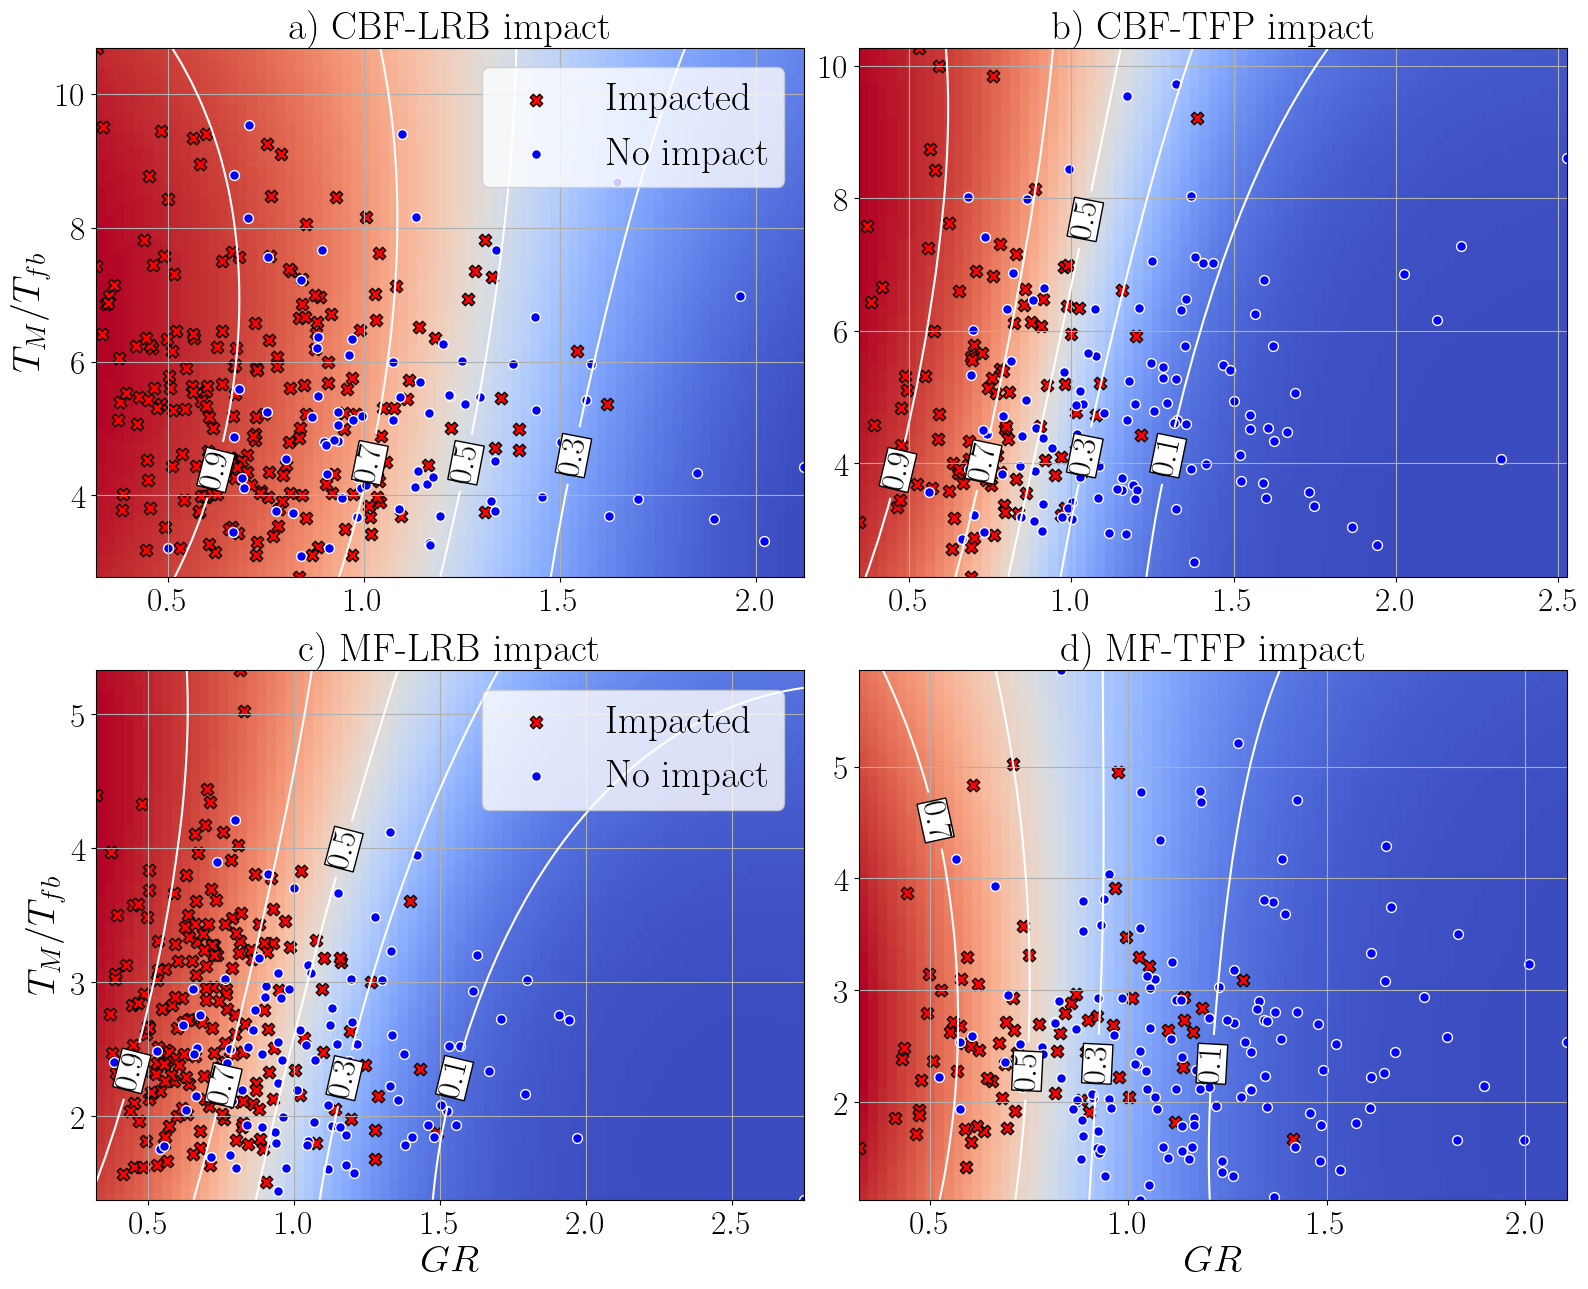

In [13]:
#%% Classification plot

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 28
title_font = 28
subt_font = 24
import matplotlib as mpl
label_size = 24
clabel_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

plt.close('all')
# make grid and plot classification predictions

fig = plt.figure(figsize=(16,13))
ax = fig.add_subplot(2, 2, 1)

xvar = 'gap_ratio'
yvar = 'T_ratio'

res = 75
X_plot = make_2D_plotting_space(df_cbf_lrb[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 2.0, fourth_var_set = 0.15)
xx = X_plot[xvar]
yy = X_plot[yvar]

# GPC impact prediction
Z = mdl_impact_cbf_lrb.gpc.predict_proba(X_plot)[:,1]


x_pl = np.unique(xx)
y_pl = np.unique(yy)

# collapse predictions
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_classif = Z.reshape(xx_pl.shape)

lvls = [0.1, 0.3, 0.5, 0.7, 0.9]
plt.imshow(
        Z_classif,
        interpolation="nearest",
        extent=(xx.min(), xx.max(),
                yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
        cmap=plt.cm.coolwarm,
    )
plt_density = 200
cs = plt.contour(xx_pl, yy_pl, Z_classif, linewidths=1.5, colors='white',
                  levels=lvls)
clabels = plt.clabel(cs, fontsize=subt_font, colors='black')
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]

ax.scatter(df_cbf_lrb_i[xvar][:plt_density],
            df_cbf_lrb_i[yvar][:plt_density],
            s=80, c='red', marker='X', edgecolors='black', label='Impacted')

ax.scatter(df_cbf_lrb_o[xvar][:plt_density],
            df_cbf_lrb_o[yvar][:plt_density],
            s=50, c='blue', edgecolors='white', label='No impact')
plt.legend(fontsize=axis_font)

# ax.set_xlim(0.3, 2.0)
ax.set_title(r'a) CBF-LRB impact', fontsize=title_font)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$T_M/T_{fb}$', fontsize=axis_font)
ax.grid('on', zorder=0)
####

ax = fig.add_subplot(2, 2, 2)
xvar = 'gap_ratio'
yvar = 'T_ratio'

res = 75
X_plot = make_2D_plotting_space(df_cbf_tfp[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 2.0, fourth_var_set = 0.15)
xx = X_plot[xvar]
yy = X_plot[yvar]

# GPC impact prediction
Z = mdl_impact_cbf_tfp.gpc.predict_proba(X_plot)[:,1]


x_pl = np.unique(xx)
y_pl = np.unique(yy)

# collapse predictions
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_classif = Z.reshape(xx_pl.shape)

plt.imshow(
        Z_classif,
        interpolation="nearest",
        extent=(xx.min(), xx.max(),
                yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
        cmap=plt.cm.coolwarm,
    )
plt_density = 200
cs = plt.contour(xx_pl, yy_pl, Z_classif, linewidths=1.5, colors='white',
                  levels=lvls)
clabels = plt.clabel(cs, fontsize=subt_font, colors='black')
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]

ax.scatter(df_cbf_tfp_i[xvar][:plt_density],
            df_cbf_tfp_i[yvar][:plt_density],
            s=80, c='red', marker='X', edgecolors='black', label='Impacted')

ax.scatter(df_cbf_tfp_o[xvar][:plt_density],
            df_cbf_tfp_o[yvar][:plt_density],
            s=50, c='blue', edgecolors='white', label='No impact')
# plt.legend(fontsize=axis_font)

# ax.set_xlim(0.3, 2.0)
ax.set_title(r'b) CBF-TFP impact', fontsize=title_font)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)

ax.grid('on', zorder=0)
# plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False) #remove ticks



#### MF


ax = fig.add_subplot(2, 2, 3)

xvar = 'gap_ratio'
yvar = 'T_ratio'

res = 75
X_plot = make_2D_plotting_space(df_mf_lrb[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 2.0, fourth_var_set = 0.15)
xx = X_plot[xvar]
yy = X_plot[yvar]

# GPC impact prediction
Z = mdl_impact_mf_lrb.gpc.predict_proba(X_plot)[:,1]


x_pl = np.unique(xx)
y_pl = np.unique(yy)

# collapse predictions
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_classif = Z.reshape(xx_pl.shape)

lvls = [0.1, 0.3, 0.5, 0.7, 0.9]
plt.imshow(
        Z_classif,
        interpolation="nearest",
        extent=(xx.min(), xx.max(),
                yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
        cmap=plt.cm.coolwarm,
    )
plt_density = 200
cs = plt.contour(xx_pl, yy_pl, Z_classif, linewidths=1.5, colors='white',
                  levels=lvls)
clabels = plt.clabel(cs, fontsize=subt_font, colors='black')
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]

ax.scatter(df_mf_lrb_i[xvar][:plt_density],
            df_mf_lrb_i[yvar][:plt_density],
            s=80, c='red', marker='X', edgecolors='black', label='Impacted')

ax.scatter(df_mf_lrb_o[xvar][:plt_density],
            df_mf_lrb_o[yvar][:plt_density],
            s=50, c='blue', edgecolors='white', label='No impact')
plt.legend(fontsize=axis_font)

# ax.set_xlim(0.3, 2.0)
ax.set_title(r'c) MF-LRB impact', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$T_M/T_{fb}$', fontsize=axis_font)
ax.grid('on', zorder=0)
####

ax = fig.add_subplot(2, 2, 4)
xvar = 'gap_ratio'
yvar = 'T_ratio'

res = 75
X_plot = make_2D_plotting_space(df_mf_tfp[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 2.0, fourth_var_set = 0.15)
xx = X_plot[xvar]
yy = X_plot[yvar]

# GPC impact prediction
Z = mdl_impact_mf_tfp.gpc.predict_proba(X_plot)[:,1]


x_pl = np.unique(xx)
y_pl = np.unique(yy)

# collapse predictions
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_classif = Z.reshape(xx_pl.shape)

plt.imshow(
        Z_classif,
        interpolation="nearest",
        extent=(xx.min(), xx.max(),
                yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
        cmap=plt.cm.coolwarm,
    )
plt_density = 200
cs = plt.contour(xx_pl, yy_pl, Z_classif, linewidths=1.5, colors='white',
                  levels=lvls)
clabels = plt.clabel(cs, fontsize=subt_font, colors='black')
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]

ax.scatter(df_mf_tfp_i[xvar][:plt_density],
            df_mf_tfp_i[yvar][:plt_density],
            s=80, c='red', marker='X', edgecolors='black', label='Impacted')

ax.scatter(df_mf_tfp_o[xvar][:plt_density],
            df_mf_tfp_o[yvar][:plt_density],
            s=50, c='blue', edgecolors='white', label='No impact')
# plt.legend(fontsize=axis_font)

# ax.set_xlim(0.3, 2.0)
ax.set_title(r'd) MF-TFP impact', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)

ax.grid('on', zorder=0)
# plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False) #remove ticks
fig.tight_layout()
plt.show()

### Regression models

In [14]:
#%% regression models: cost
# goal: E[cost|sys=sys, impact=impact]

cost_var = 'cmp_cost_ratio'
time_var = 'cmp_time_ratio'
repl_var= 'replacement_freq'

mdl_cost_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_cost_cbf_lrb_i.set_covariates(covariate_list)
mdl_cost_cbf_lrb_i.set_outcome(cost_var)
mdl_cost_cbf_lrb_i.test_train_split(0.2)

mdl_cost_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_cost_cbf_lrb_o.set_covariates(covariate_list)
mdl_cost_cbf_lrb_o.set_outcome(cost_var)
mdl_cost_cbf_lrb_o.test_train_split(0.2)

mdl_cost_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_cost_cbf_tfp_i.set_covariates(covariate_list)
mdl_cost_cbf_tfp_i.set_outcome(cost_var)
mdl_cost_cbf_tfp_i.test_train_split(0.2)

mdl_cost_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_cost_cbf_tfp_o.set_covariates(covariate_list)
mdl_cost_cbf_tfp_o.set_outcome(cost_var)
mdl_cost_cbf_tfp_o.test_train_split(0.2)

mdl_cost_mf_lrb_i = GP(df_mf_lrb_i)
mdl_cost_mf_lrb_i.set_covariates(covariate_list)
mdl_cost_mf_lrb_i.set_outcome(cost_var)
mdl_cost_mf_lrb_i.test_train_split(0.2)

mdl_cost_mf_lrb_o = GP(df_mf_lrb_o)
mdl_cost_mf_lrb_o.set_covariates(covariate_list)
mdl_cost_mf_lrb_o.set_outcome(cost_var)
mdl_cost_mf_lrb_o.test_train_split(0.2)

mdl_cost_mf_tfp_i = GP(df_mf_tfp_i)
mdl_cost_mf_tfp_i.set_covariates(covariate_list)
mdl_cost_mf_tfp_i.set_outcome(cost_var)
mdl_cost_mf_tfp_i.test_train_split(0.2)

mdl_cost_mf_tfp_o = GP(df_mf_tfp_o)
mdl_cost_mf_tfp_o.set_covariates(covariate_list)
mdl_cost_mf_tfp_o.set_outcome(cost_var)
mdl_cost_mf_tfp_o.test_train_split(0.2)

print('======= cost regression per system per impact ========')
import time
t0 = time.time()

mdl_cost_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_tfp_o.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for cost done for 8 models in %.3f s" % tp)

cost_regression_mdls = {'mdl_cost_cbf_lrb_i': mdl_cost_cbf_lrb_i,
                        'mdl_cost_cbf_lrb_o': mdl_cost_cbf_lrb_o,
                        'mdl_cost_cbf_tfp_i': mdl_cost_cbf_tfp_i,
                        'mdl_cost_cbf_tfp_o': mdl_cost_cbf_tfp_o,
                        'mdl_cost_mf_lrb_i': mdl_cost_mf_lrb_i,
                        'mdl_cost_mf_lrb_o': mdl_cost_mf_lrb_o,
                        'mdl_cost_mf_tfp_i': mdl_cost_mf_tfp_i,
                        'mdl_cost_mf_tfp_o': mdl_cost_mf_tfp_o}

#%% regression models: time
# goal: E[time|sys=sys, impact=impact]

mdl_time_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_time_cbf_lrb_i.set_covariates(covariate_list)
mdl_time_cbf_lrb_i.set_outcome(time_var)
mdl_time_cbf_lrb_i.test_train_split(0.2)

mdl_time_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_time_cbf_lrb_o.set_covariates(covariate_list)
mdl_time_cbf_lrb_o.set_outcome(time_var)
mdl_time_cbf_lrb_o.test_train_split(0.2)

mdl_time_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_time_cbf_tfp_i.set_covariates(covariate_list)
mdl_time_cbf_tfp_i.set_outcome(time_var)
mdl_time_cbf_tfp_i.test_train_split(0.2)

mdl_time_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_time_cbf_tfp_o.set_covariates(covariate_list)
mdl_time_cbf_tfp_o.set_outcome(time_var)
mdl_time_cbf_tfp_o.test_train_split(0.2)

mdl_time_mf_lrb_i = GP(df_mf_lrb_i)
mdl_time_mf_lrb_i.set_covariates(covariate_list)
mdl_time_mf_lrb_i.set_outcome(time_var)
mdl_time_mf_lrb_i.test_train_split(0.2)

mdl_time_mf_lrb_o = GP(df_mf_lrb_o)
mdl_time_mf_lrb_o.set_covariates(covariate_list)
mdl_time_mf_lrb_o.set_outcome(time_var)
mdl_time_mf_lrb_o.test_train_split(0.2)

mdl_time_mf_tfp_i = GP(df_mf_tfp_i)
mdl_time_mf_tfp_i.set_covariates(covariate_list)
mdl_time_mf_tfp_i.set_outcome(time_var)
mdl_time_mf_tfp_i.test_train_split(0.2)

mdl_time_mf_tfp_o = GP(df_mf_tfp_o)
mdl_time_mf_tfp_o.set_covariates(covariate_list)
mdl_time_mf_tfp_o.set_outcome(time_var)
mdl_time_mf_tfp_o.test_train_split(0.2)

print('======= downtime regression per system per impact ========')
import time
t0 = time.time()

mdl_time_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_tfp_o.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for time done for 8 models in %.3f s" % tp)

time_regression_mdls = {'mdl_time_cbf_lrb_i': mdl_time_cbf_lrb_i,
                        'mdl_time_cbf_lrb_o': mdl_time_cbf_lrb_o,
                        'mdl_time_cbf_tfp_i': mdl_time_cbf_tfp_i,
                        'mdl_time_cbf_tfp_o': mdl_time_cbf_tfp_o,
                        'mdl_time_mf_lrb_i': mdl_time_mf_lrb_i,
                        'mdl_time_mf_lrb_o': mdl_time_mf_lrb_o,
                        'mdl_time_mf_tfp_i': mdl_time_mf_tfp_i,
                        'mdl_time_mf_tfp_o': mdl_time_mf_tfp_o}

#%% regression models: repl
# goal: E[repl|sys=sys, impact=impact]

mdl_repl_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_repl_cbf_lrb_i.set_covariates(covariate_list)
mdl_repl_cbf_lrb_i.set_outcome('replacement_freq')
mdl_repl_cbf_lrb_i.test_train_split(0.2)

mdl_repl_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_repl_cbf_lrb_o.set_covariates(covariate_list)
mdl_repl_cbf_lrb_o.set_outcome('replacement_freq')
mdl_repl_cbf_lrb_o.test_train_split(0.2)

mdl_repl_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_repl_cbf_tfp_i.set_covariates(covariate_list)
mdl_repl_cbf_tfp_i.set_outcome('replacement_freq')
mdl_repl_cbf_tfp_i.test_train_split(0.2)

mdl_repl_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_repl_cbf_tfp_o.set_covariates(covariate_list)
mdl_repl_cbf_tfp_o.set_outcome('replacement_freq')
mdl_repl_cbf_tfp_o.test_train_split(0.2)

mdl_repl_mf_lrb_i = GP(df_mf_lrb_i)
mdl_repl_mf_lrb_i.set_covariates(covariate_list)
mdl_repl_mf_lrb_i.set_outcome('replacement_freq')
mdl_repl_mf_lrb_i.test_train_split(0.2)

mdl_repl_mf_lrb_o = GP(df_mf_lrb_o)
mdl_repl_mf_lrb_o.set_covariates(covariate_list)
mdl_repl_mf_lrb_o.set_outcome('replacement_freq')
mdl_repl_mf_lrb_o.test_train_split(0.2)

mdl_repl_mf_tfp_i = GP(df_mf_tfp_i)
mdl_repl_mf_tfp_i.set_covariates(covariate_list)
mdl_repl_mf_tfp_i.set_outcome('replacement_freq')
mdl_repl_mf_tfp_i.test_train_split(0.2)

mdl_repl_mf_tfp_o = GP(df_mf_tfp_o)
mdl_repl_mf_tfp_o.set_covariates(covariate_list)
mdl_repl_mf_tfp_o.set_outcome('replacement_freq')
mdl_repl_mf_tfp_o.test_train_split(0.2)

t0 = time.time()

print('======= replacement regression per system per impact ========')

mdl_repl_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_repl_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_repl_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_repl_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso')
mdl_repl_mf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_repl_mf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_repl_mf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_repl_mf_tfp_o.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for replacement done for 8 models in %.3f s" % tp)

repl_regression_mdls = {'mdl_repl_cbf_lrb_i': mdl_repl_cbf_lrb_i,
                        'mdl_repl_cbf_lrb_o': mdl_repl_cbf_lrb_o,
                        'mdl_repl_cbf_tfp_i': mdl_repl_cbf_tfp_i,
                        'mdl_repl_cbf_tfp_o': mdl_repl_cbf_tfp_o,
                        'mdl_repl_mf_lrb_i': mdl_repl_mf_lrb_i,
                        'mdl_repl_mf_lrb_o': mdl_repl_mf_lrb_o,
                        'mdl_repl_mf_tfp_i': mdl_repl_mf_tfp_i,
                        'mdl_repl_mf_tfp_o': mdl_repl_mf_tfp_o}

======= cost regression per system per impact ========
GPR training for cost done for 8 models in 1.475 s
======= downtime regression per system per impact ========
GPR training for time done for 8 models in 1.468 s
======= replacement regression per system per impact ========


c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GPR training for replacement done for 8 models in 1.462 s


c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


### Combined prediction surface

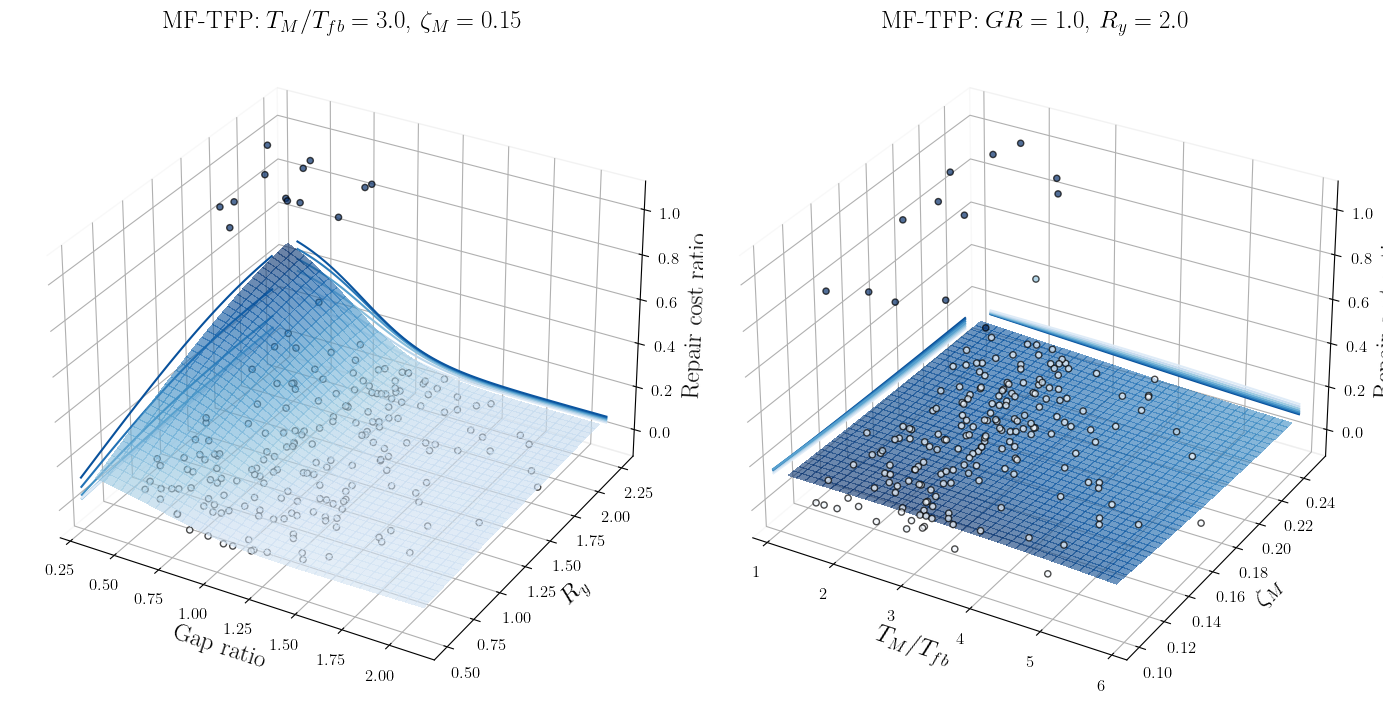

In [15]:
from inverse import predict_DV

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 18
subt_font = 18
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

fig = plt.figure(figsize=(14, 7))

xvar = 'gap_ratio'
yvar = 'RI'


impact_mdl = mdl_impact_mf_tfp
hit_model = mdl_cost_mf_tfp_i
miss_model = mdl_cost_mf_tfp_o
df_sc = df_mf_tfp.copy()

res = 75
X_plot = make_2D_plotting_space(impact_mdl.X, res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 2.0, fourth_var_set = 0.15)

Z = predict_DV(X_plot, impact_mdl.gpc, hit_model.gpr, miss_model.gpr,
                    outcome=cost_var, return_var=False)


xx = X_plot[xvar]
yy = X_plot[yvar]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_surf = np.array(Z).reshape(xx_pl.shape)

ax=fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(xx_pl, yy_pl, Z_surf, cmap='Blues',
                       linewidth=0, antialiased=False, alpha=0.6,
                       vmin=-0.1)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.scatter(df_sc[xvar], df_sc[yvar], df_sc[cost_var], c=df_sc[cost_var],
           edgecolors='k', alpha = 0.7, cmap='Blues')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='x', offset=xlim[0], cmap='Blues_r')
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='y', offset=ylim[1], cmap='Blues')
ax.set_zlim([-0.1, 1.1])

ax.set_xlabel('Gap ratio', fontsize=axis_font)
ax.set_ylabel('$R_y$', fontsize=axis_font)
ax.set_zlabel('Repair cost ratio', fontsize=axis_font)
ax.set_title('MF-TFP: $T_M/T_{fb} = 3.0$, $\zeta_M = 0.15$', fontsize=subt_font)

#################################
xvar = 'T_ratio'
yvar = 'zeta_e'

res = 75
X_plot = make_2D_plotting_space(impact_mdl.X, res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 1.0, fourth_var_set = 2.0)

Z = predict_DV(X_plot, impact_mdl.gpc, hit_model.gpr, miss_model.gpr,
                    outcome=cost_var, return_var=False)

xx = X_plot[xvar]
yy = X_plot[yvar]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_surf = np.array(Z).reshape(xx_pl.shape)

ax=fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(xx_pl, yy_pl, Z_surf, cmap='Blues',
                       linewidth=0, antialiased=False, alpha=0.6,
                       vmin=-0.1)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.scatter(df_sc[xvar], df_sc[yvar], df_sc[cost_var], c=df_sc[cost_var],
           edgecolors='k', alpha = 0.7, cmap='Blues')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='x', offset=xlim[0], cmap='Blues_r')
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='y', offset=ylim[1], cmap='Blues')
ax.set_zlim([-0.1, 1.1])

ax.set_xlabel('$T_M/ T_{fb}$', fontsize=axis_font)
ax.set_ylabel('$\zeta_M$', fontsize=axis_font)
ax.set_zlabel('Repair cost ratio', fontsize=axis_font)
ax.set_title('MF-TFP: $GR = 1.0$, $R_y = 2.0$', fontsize=subt_font)
fig.tight_layout()

### Inverse design filter

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

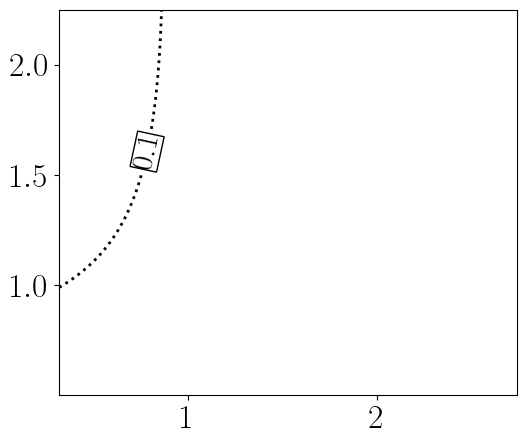

In [16]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=24
axis_font = 24
subt_font = 22
label_size = 24
clabel_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
# plt.close('all')

from matplotlib.lines import Line2D
fig = plt.figure(figsize=(13, 11))

#################################
xvar = 'gap_ratio'
yvar = 'RI'

lvls_cost = np.array([0.2])
lvls_time = np.array([0.2])
lvls_repl = np.array([0.1])

lvls_cost_enhanced = np.array([0.1])
lvls_time_enhanced = np.array([0.1])
lvls_repl_enhanced = np.array([0.05])

res = 100
X_plot = make_2D_plotting_space(df[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 3.2, fourth_var_set = 0.24)

xx = X_plot[xvar]
yy = X_plot[yvar]

x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)


#### MF-TFP

ax = fig.add_subplot(2, 2, 1)
# plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_cost = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_cost_mf_tfp_i.gpr,
                       mdl_cost_mf_tfp_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cost = Z.reshape(xx_pl.shape)

# clabels = ax.clabel(cs, fontsize=clabel_size)

grid_time = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_time_mf_tfp_i.gpr,
                       mdl_time_mf_tfp_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_time = Z.reshape(xx_pl.shape)

lvls = np.array([0.1])
grid_repl = predict_DV(X_plot,
                       mdl_impact_mf_tfp.gpc,
                       mdl_repl_mf_tfp_i.gpr,
                       mdl_repl_mf_tfp_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_repl = Z.reshape(xx_pl.shape)





cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
                colors='black', linestyles='dotted', levels=lvls_repl)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='dimgray', alpha=0.5, levels=[-1.0, lvls_repl])

cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
                colors='black', linestyles='dashed', levels=lvls_time)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='darkgray', alpha=0.5, levels=[-1.0, lvls_time])

cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost)
clabels = ax.clabel(cs, fontsize=clabel_size, manual=[(.6, 1.5)])
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='gainsboro', alpha=0.5, levels=[-1.0, lvls_cost])

ax.text(1.6, 1.5, 'Acceptable \n design space', horizontalalignment='center',
          fontsize=subt_font, color='green', bbox=dict(facecolor='white', edgecolor='green'))

# cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
#                 colors='black', linestyles='dotted', levels=lvls_repl_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='lightcyan', alpha=0.2, levels=[lvls_repl_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
#                 colors='black', linestyles='dashed', levels=lvls_time_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='powderblue', alpha=0.2, levels=[lvls_time_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='lightskyblue', alpha=0.2, levels=[lvls_cost_enhanced, 1.0])

ax.grid(visible=True)



ax.set_title('a) MF-TFP', fontsize=title_font)
# ax.set_xlabel(r'Gap ratio (GR)', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)


ax.set_xlim([0.35, 2.0])
ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)

custom_lines = [Line2D([-1], [-1], color='black', 
                       linestyle='-' ),
                Line2D([-1], [-1], color='black', 
                                       linestyle='--' ),
                Line2D([-1], [-1], color='black', 
                                       linestyle=':' ),
                ]

ax.legend(custom_lines, ['20\% repair cost ratio', '20\% repair time ratio', '10\% replacement probability'], 
           fontsize=subt_font, loc='lower right')

#### MF-LRB
X_plot = make_2D_plotting_space(df[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 2.35, fourth_var_set = 0.20)

ax = fig.add_subplot(2, 2, 2)
# plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_cost = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_cost_mf_lrb_i.gpr,
                       mdl_cost_mf_lrb_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cost = Z.reshape(xx_pl.shape)

# clabels = ax.clabel(cs, fontsize=clabel_size)

grid_time = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_time_mf_lrb_i.gpr,
                       mdl_time_mf_lrb_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_time = Z.reshape(xx_pl.shape)

lvls = np.array([0.1])
grid_repl = predict_DV(X_plot,
                       mdl_impact_mf_lrb.gpc,
                       mdl_repl_mf_lrb_i.gpr,
                       mdl_repl_mf_lrb_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_repl = Z.reshape(xx_pl.shape)





cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
                colors='black', linestyles='dotted', levels=lvls_repl)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='dimgray', alpha=0.5, levels=[-1.0, lvls_repl])

cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
                colors='black', linestyles='dashed', levels=lvls_time)
clabels = ax.clabel(cs, fontsize=clabel_size, manual=[(0.9, 1.5)])
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='darkgray', alpha=0.5, levels=[-1.0, lvls_time])

cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='gainsboro', alpha=0.5, levels=[-1.0, lvls_cost])

ax.text(1.5, 1.0, 'Acceptable \n design space', horizontalalignment='center',
          fontsize=subt_font, color='green', bbox=dict(facecolor='white', edgecolor='green'))

# cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
#                 colors='black', linestyles='dotted', levels=lvls_repl_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='lightcyan', alpha=0.2, levels=[lvls_repl_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
#                 colors='black', linestyles='dashed', levels=lvls_time_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='powderblue', alpha=0.2, levels=[lvls_time_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='lightskyblue', alpha=0.2, levels=[lvls_cost_enhanced, 1.0])

ax.grid(visible=True)


ax.set_title('b) MF-LRB', fontsize=title_font)
# ax.set_xlabel(r'Gap ratio (GR)', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)


ax.set_xlim([0.35, 2.0])
ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)

#### CBF-TFP
X_plot = make_2D_plotting_space(df[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 5.79, fourth_var_set = 0.23)
ax = fig.add_subplot(2, 2, 3)
# plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_cost = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_cost_cbf_tfp_i.gpr,
                       mdl_cost_cbf_tfp_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cost = Z.reshape(xx_pl.shape)

# clabels = ax.clabel(cs, fontsize=clabel_size)

grid_time = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_time_cbf_tfp_i.gpr,
                       mdl_time_cbf_tfp_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_time = Z.reshape(xx_pl.shape)

grid_repl = predict_DV(X_plot,
                       mdl_impact_cbf_tfp.gpc,
                       mdl_repl_cbf_tfp_i.gpr,
                       mdl_repl_cbf_tfp_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_repl = Z.reshape(xx_pl.shape)





cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
                colors='black', linestyles='dotted', levels=lvls_repl)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='dimgray', alpha=0.5, levels=[-1.0, lvls_repl])

cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
                colors='black', linestyles='dashed', levels=lvls_time)
clabels = ax.clabel(cs, fontsize=clabel_size, manual=[(1.0, 1.25)])
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='darkgray', alpha=0.5, levels=[-1.0, lvls_time])

cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='gainsboro', alpha=0.5, levels=[-1.0, lvls_cost])

ax.text(1.5, 1.0, 'Acceptable \n design space', horizontalalignment='center',
          fontsize=subt_font, color='green', bbox=dict(facecolor='white', edgecolor='green'))

# cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
#                 colors='black', linestyles='dotted', levels=lvls_repl_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='lightcyan', alpha=0.2, levels=[lvls_repl_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
#                 colors='black', linestyles='dashed', levels=lvls_time_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='powderblue', alpha=0.2, levels=[lvls_time_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='lightskyblue', alpha=0.2, levels=[lvls_cost_enhanced, 1.0])

ax.grid(visible=True)

ax.set_title('c) CBF-TFP', fontsize=title_font)
# ax.set_xlabel(r'Gap ratio (GR)', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)


ax.set_xlim([0.35, 2.0])
ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)

fig.tight_layout()

#### CBF-LRB
X_plot = make_2D_plotting_space(df[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 4.79, fourth_var_set = 0.21)
ax = fig.add_subplot(2, 2, 4)
# plt.setp(ax, xticks=np.arange(0.5, 5.0, step=0.5))

# cs = ax1.contour(xx, yy, Z, linewidths=1.1, cmap='Blues', vmin=-1,
#                  levels=lvls)

grid_cost = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_cost_cbf_lrb_i.gpr,
                       mdl_cost_cbf_lrb_o.gpr,
                       outcome=cost_var)

Z = np.array(grid_cost)
Z_cost = Z.reshape(xx_pl.shape)

# clabels = ax.clabel(cs, fontsize=clabel_size)

grid_time = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_time_cbf_lrb_i.gpr,
                       mdl_time_cbf_lrb_o.gpr,
                       outcome=time_var)

Z = np.array(grid_time)
Z_time = Z.reshape(xx_pl.shape)

lvls = np.array([0.1])
grid_repl = predict_DV(X_plot,
                       mdl_impact_cbf_lrb.gpc,
                       mdl_repl_cbf_lrb_i.gpr,
                       mdl_repl_cbf_lrb_o.gpr,
                       outcome=repl_var)

Z = np.array(grid_repl)
Z_repl = Z.reshape(xx_pl.shape)





cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
                colors='black', linestyles='dotted', levels=lvls_repl)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='dimgray', alpha=0.5, levels=[-1.0, lvls_repl])

cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
                colors='black', linestyles='dashed', levels=lvls_time)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='darkgray', alpha=0.5, levels=[-1.0, lvls_time])

cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost)
clabels = ax.clabel(cs, fontsize=clabel_size)
[txt.set_bbox(dict(facecolor='white', edgecolor='black', pad=0)) for txt in clabels]
cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='gainsboro', alpha=0.5, levels=[-1.0, lvls_cost])

ax.text(1.65, 0.8, 'Acceptable \n design space', horizontalalignment='center',
          fontsize=subt_font, color='green', bbox=dict(facecolor='white', edgecolor='green'))

# cs = ax.contour(xx_pl, yy_pl, Z_repl, linewidths=2.0, 
#                 colors='black', linestyles='dotted', levels=lvls_repl_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_repl, colors='lightcyan', alpha=0.2, levels=[lvls_repl_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_time, linewidths=2.0, 
#                 colors='black', linestyles='dashed', levels=lvls_time_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_time, colors='powderblue', alpha=0.2, levels=[lvls_time_enhanced, 1.0])

# cs = ax.contour(xx_pl, yy_pl, Z_cost, linewidths=2.0, colors='black', levels=lvls_cost_enhanced)
# ax.clabel(cs, fontsize=clabel_size)
# cs = ax.contourf(xx_pl, yy_pl, Z_cost, colors='lightskyblue', alpha=0.2, levels=[lvls_cost_enhanced, 1.0])

ax.grid(visible=True)


ax.set_title('d) CBF-LRB', fontsize=title_font)
# ax.set_xlabel(r'Gap ratio (GR)', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)


ax.set_xlim([0.35, 2.0])
ax.set_ylim([0.5, 2.25])

ax.grid(visible=True)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)

fig.tight_layout()

### Validation (boxplots)

In [17]:

from inverse import loss_percentages
from gms import get_ST

def process_results(run_case):
    
    import numpy as np
    # load in validation and max run
    val_dir = '../../data/validation/'+run_case+'/'
    
    loss_file = run_case+'_loss.pickle'
    max_loss_file = run_case+'_max_loss.pickle'
    
    val_obj = pd.read_pickle(val_dir+loss_file)
    ida_results_df = val_obj.ida_results.reset_index(drop=True)
    loss_results_df = val_obj.loss_data.reset_index(drop=True)
    
    val_max_obj = pd.read_pickle(val_dir+max_loss_file)
    max_loss_results_df = val_max_obj.max_loss.reset_index(drop=True)
    
    # calculate loss ratios
    ida_results_df = loss_percentages(
        ida_results_df, loss_results_df, max_loss_results_df)
    
    # print out the results
    ida_levels = [1.0, 1.5, 2.0]

    val_cost  = np.zeros((3,))
    val_replacement = np.zeros((3,))
    val_cost_ratio = np.zeros((3,))
    val_downtime_ratio = np.zeros((3,))
    val_downtime = np.zeros((3,))
    impact_freq = np.zeros((3,))
    struct_cost = np.zeros((3,))
    nsc_cost = np.zeros((3,))
    gap_ratios = np.zeros((3,))
    T_ratios = np.zeros((3,))
    
    GR_adjs = np.zeros((3,))
    
    isolator_system = run_case.split('_')[1]
    
    # collect variable: currently working with means of medians
    cost_var_ida = 'cost_50%'
    time_var_ida = 'time_l_50%'
    
    cost_var = 'cmp_cost_ratio'
    time_var = 'cmp_time_ratio'
    
    for i, lvl in enumerate(ida_levels):
        val_ida = ida_results_df[ida_results_df['ida_level']==lvl]
        loss_ida = loss_results_df[ida_results_df['ida_level']==lvl]
        
        val_replacement[i] = val_ida['replacement_freq'].mean()
        val_cost[i] = loss_ida[cost_var_ida].mean()
        val_cost_ratio[i] = val_ida[cost_var].mean()
        val_downtime[i] = loss_ida[time_var_ida].mean()
        val_downtime_ratio[i] = val_ida[time_var].mean()
        impact_freq[i] = val_ida['impacted'].mean()
        struct_cost[i] = val_ida['B_50%'].mean()
        nsc_cost[i] = val_ida['C_50%'].mean() + val_ida['D_50%'].mean() + val_ida['E_50%'].mean() 
            
        
        zetaRef = [0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
        BmRef   = [0.8, 1.0, 1.2, 1.5, 1.7, 1.9, 2.0]
        Bm = np.interp(val_ida['zeta_e'], zetaRef, BmRef)
        
        if isolator_system == 'tfp':
            T_shifted = np.mean(val_ida['T_m']*0.9)
        else:
            T_shifted = np.mean(val_ida['T_m'])
            
        sa_tm_adj = val_ida.apply(
            lambda x: get_ST(x, T_shifted,
                              db_dir='../../resource/ground_motions/gm_db.csv',
                              spec_dir='../../resource/ground_motions/gm_spectra.csv'), 
            axis=1)
        
        gap_ratios_all = (val_ida['constructed_moat']*4*pi**2)/ \
            (g*(val_ida['sa_tm']/Bm)*val_ida['T_m']**2)
        gap_ratios[i] = gap_ratios_all.mean()
        
        GR_adj = (val_ida['constructed_moat']*4*pi**2)/ \
            (g*(sa_tm_adj/Bm)*T_shifted**2)
        GR_adjs[i] = GR_adj.mean()
            
        T_ratio_adj = T_shifted / val_ida['T_fbe'].mean()
        
        T_ratios[i] = T_shifted / val_ida['T_fb'].mean()
        
    # print(T_shifted)
    # print(GR_adjs)
    # print(T_ratio_adj)
    # print(T_ratios)
    
    
    design_list = []
    ss_sys = ida_results_df['superstructure_system'].iloc[0]
    iso_sys = ida_results_df['isolator_system'].iloc[0]
    if ss_sys == 'CBF':
        design_list.extend(['beam', 'column', 'brace'])
    else:
        design_list.extend(['beam', 'column'])
    if iso_sys == 'LRB':
        design_list.extend(['d_bearing', 'd_lead', 't_r', 'n_layers'])
    else:
        design_list.extend(['mu_1', 'mu_2', 'R_1', 'R_2'])
        
    
    sys_name = ss_sys+'-'+iso_sys
    
    # design_tested = ida_results_df[['moat_ampli', 'RI', 'T_ratio' , 'zeta_e']].iloc[0]
    # design_specifics = ida_results_df[design_list].iloc[0]
    # print('==================================')
    # print('   Validation results  (1.0 MCE)  ')
    # print('==================================')
    
    # print('System:', ss_sys+'-'+iso_sys)
    # print('Average median repair cost: ',
    #       f'${val_cost[0]:,.2f}')
    # print('Repair cost ratio: ', 
    #       f'{val_cost_ratio[0]:,.3f}')
    # print('Repair time ratio: ',
    #       f'{val_downtime_ratio[0]:,.3f}')
    # print('Estimated replacement frequency: ',
    #       f'{val_replacement[0]:.2%}')
    # print(design_tested)
    # print(design_specifics)
    
    latex_string = f"& {sys_name} & {val_cost_ratio[0]:.3f} & {val_cost_ratio[1]:.3f} & {val_cost_ratio[2]:.3f} \
        & {val_downtime_ratio[0]:.3f} & {val_downtime_ratio[1]:.3f} & {val_downtime_ratio[2]:.3f} \
            & {val_replacement[0]:.3f} & {val_replacement[1]:.3f} & {val_replacement[2]:.3f} \\\\"
    
    print(latex_string)  
    
    
    # n_workers = (ida_results_df['bldg_area']/1000).mean()

    # print('Cost total:', ida_results_df['total_cmp_cost'].mean()/1e6)
    # print('Time total:', ida_results_df['total_cmp_time'].mean()/n_workers)
    
    # print('GR:', gap_ratios)
    # print('TR:', T_ratios)
    # print('Impact:', impact_freq)
    # print('Structural cost:', struct_cost/1e6)
    # print('Non-structural cost:', nsc_cost/1e6)
    
    
    # latex_string = f"& {sys_name} & {mce_cost_ratio:.3f} & {mce_time_ratio:.3f} & {mce_repl_ratio:.3f} \
    #     & {val_cost_ratio[0]:.2f} & {GP_time_ratio:.2f} & {GP_repl_risk:.2f} &  \${upfront_cost/1e6:.2f} M \\\\"
    
    return(ida_results_df, val_replacement, val_cost, 
           val_cost_ratio, val_downtime, val_downtime_ratio)

(mf_tfp_val_results, mf_tfp_val_repl, mf_tfp_val_cost, mf_tfp_val_cost_ratio, 
 mf_tfp_val_downtime, mf_tfp_val_downtime_ratio) = process_results('mf_tfp_moderate')
(mf_lrb_val_results, mf_lrb_val_repl, mf_lrb_val_cost, mf_lrb_val_cost_ratio, 
 mf_lrb_val_downtime, mf_lrb_val_downtime_ratio) = process_results('mf_lrb_moderate')
(cbf_tfp_val_results, cbf_tfp_val_repl, cbf_tfp_val_cost, cbf_tfp_val_cost_ratio, 
 cbf_tfp_val_downtime, cbf_tfp_val_downtime_ratio) = process_results('cbf_tfp_moderate')
(cbf_lrb_val_results, cbf_lrb_val_repl, cbf_lrb_val_cost, cbf_lrb_val_cost_ratio, 
 cbf_lrb_val_downtime, cbf_lrb_val_downtime_ratio) = process_results('cbf_lrb_moderate')

(mf_tfp_strict_results, mf_tfp_strict_repl, mf_tfp_strict_cost, mf_tfp_strict_cost_ratio, 
 mf_tfp_strict_downtime, mf_tfp_strict_downtime_ratio) = process_results('mf_tfp_enhanced')
(mf_lrb_strict_results, mf_lrb_strict_repl, mf_lrb_strict_cost, mf_lrb_strict_cost_ratio, 
 mf_lrb_strict_downtime, mf_lrb_strict_downtime_ratio) = process_results('mf_lrb_enhanced')
(cbf_tfp_strict_results, cbf_tfp_strict_repl, cbf_tfp_strict_cost, cbf_tfp_strict_cost_ratio, 
 cbf_tfp_strict_downtime, cbf_tfp_strict_downtime_ratio) = process_results('cbf_tfp_enhanced')
(cbf_lrb_strict_results, cbf_lrb_strict_repl, cbf_lrb_strict_cost, cbf_lrb_strict_cost_ratio, 
 cbf_lrb_strict_downtime, cbf_lrb_strict_downtime_ratio) = process_results('cbf_lrb_enhanced')


& MF-TFP & 0.191 & 0.773 & 1.000         & 0.205 & 0.781 & 1.000             & 0.161 & 0.767 & 1.000 \\
& MF-LRB & 0.053 & 0.269 & 0.640         & 0.062 & 0.278 & 0.645             & 0.026 & 0.239 & 0.628 \\
& CBF-TFP & 0.159 & 0.721 & 0.913         & 0.166 & 0.719 & 0.914             & 0.093 & 0.683 & 0.894 \\
& CBF-LRB & 0.154 & 0.567 & 0.898         & 0.156 & 0.564 & 0.896             & 0.104 & 0.495 & 0.876 \\
& MF-TFP & 0.081 & 0.647 & 0.980         & 0.094 & 0.655 & 0.980             & 0.044 & 0.629 & 0.976 \\
& MF-LRB & 0.053 & 0.269 & 0.640         & 0.062 & 0.278 & 0.645             & 0.026 & 0.240 & 0.628 \\
& CBF-TFP & 0.101 & 0.564 & 0.818         & 0.106 & 0.566 & 0.815             & 0.038 & 0.511 & 0.798 \\
& CBF-LRB & 0.043 & 0.445 & 0.867         & 0.043 & 0.444 & 0.866             & 0.023 & 0.411 & 0.858 \\


In [18]:

#%% debrief predictions: try to get predictions of actual ran building
# two values differ
# GR should be different because real ground motion suite has different Sa than design spectrum
# T ratio should be different because actual T_fb is not perfectly equal to Tfbe

def one_time_pred(X_built, system_name, 
                        impact_clfs, cost_regs, time_regs, repl_regs):
    
    cost_var = 'cmp_cost_ratio'
    time_var = 'cmp_time_ratio'
    
    # identify cost models
    mdl_impact_name = 'mdl_impact_' + system_name
    mdl_cost_hit_name = 'mdl_cost_' + system_name + '_i'
    mdl_cost_miss_name = 'mdl_cost_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_cost_hit = cost_regs[mdl_cost_hit_name]
    mdl_cost_miss = cost_regs[mdl_cost_miss_name]
    
    # identify time models
    mdl_time_hit_name = 'mdl_time_' + system_name + '_i'
    mdl_time_miss_name = 'mdl_time_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_time_hit = time_regs[mdl_time_hit_name]
    mdl_time_miss = time_regs[mdl_time_miss_name]
    
    # identify replacement models
    mdl_repl_hit_name = 'mdl_repl_' + system_name + '_i'
    mdl_repl_miss_name = 'mdl_repl_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_repl_hit = repl_regs[mdl_repl_hit_name]
    mdl_repl_miss = repl_regs[mdl_repl_miss_name]
    
    # assumes GPC/GPR, predict the outcome for the design space
    ab_repair_cost, ab_repair_cost_var = predict_DV(
        X_built, mdl_impact.gpc, mdl_cost_hit.gpr, mdl_cost_miss.gpr, 
        outcome=cost_var, return_var=True)
    
    ab_downtime, ab_downtime_var = predict_DV(
        X_built, mdl_impact.gpc, mdl_time_hit.gpr, mdl_time_miss.gpr, 
        outcome=time_var, return_var=True)
    
    ab_repl, ab_repl_var = predict_DV(
        X_built, mdl_impact.gpc, mdl_repl_hit.gpr, mdl_repl_miss.gpr,
        outcome='replacement_freq', return_var=True)
    try:
        ab_performance = {
            'time': ab_downtime.iloc[0][time_var+'_pred'],
            'cost': ab_repair_cost.iloc[0][cost_var+'_pred'],
            'replacement_freq': ab_repl.iloc[0]['replacement_freq'+'_pred'],
            'time_var': ab_downtime_var[0],
            'cost_var': ab_repair_cost_var[0],
            'replacement_freq_var': ab_repl_var[0]}
    except:
        ab_performance = {
            'time': ab_downtime.iloc[0][time_var+'_pred'],
            'cost': ab_repair_cost.iloc[0][cost_var+'_pred'],
            'replacement_freq': ab_repl.iloc[0]['replacement_freq'+'_pred'],
            'time_var': ab_downtime_var.iloc[0][time_var+'_pred'],
            'cost_var': ab_repair_cost_var.iloc[0][cost_var+'_pred'],
            'replacement_freq_var': ab_repl_var.iloc[0]['replacement_freq'+'_pred']}

    return(ab_performance)

import json
mf_tfp_inv_design = {'gap_ratio': 0.89,
                     'RI':2.25,
                     'T_ratio': 2.87,
                     'zeta_e': 0.25}
mf_lrb_inv_design = json.load(open("../inputs/mf_lrb_moderate.in"))
cbf_tfp_inv_design = {'gap_ratio': 1.34,
                     'RI':2.25,
                     'T_ratio': 6.24,
                     'zeta_e': 0.22}
cbf_lrb_inv_design = json.load(open("../inputs/cbf_lrb_moderate.in"))

mf_tfp_strict_design = {'gap_ratio': 1.12,
                     'RI':2.25,
                     'T_ratio': 2.87,
                     'zeta_e': 0.24}
mf_lrb_strict_design = json.load(open("../inputs/mf_lrb_enhanced.in"))
cbf_tfp_strict_design = {'gap_ratio': 1.48,
                     'RI':1.79,
                     'T_ratio': 6.24,
                     'zeta_e': 0.23}
cbf_lrb_strict_design = json.load(open("../inputs/cbf_lrb_enhanced.in"))

mf_tfp_inv_pred = one_time_pred(
    pd.DataFrame(pd.Series(mf_tfp_inv_design)).T,
    'mf_tfp', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)

mf_lrb_inv_pred = one_time_pred(
    pd.DataFrame(pd.Series(mf_lrb_inv_design).drop(['superstructure_system', 'k_ratio', 'isolator_system'])).T, 
    'mf_lrb', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)

cbf_tfp_inv_pred = one_time_pred(
    pd.DataFrame(pd.Series(cbf_tfp_inv_design)).T, 
    'cbf_tfp', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)
 
cbf_lrb_inv_pred = one_time_pred(
    pd.DataFrame(pd.Series(cbf_lrb_inv_design).drop(['superstructure_system', 'k_ratio', 'isolator_system'])).T, 
    'cbf_lrb', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)

mf_tfp_strict_pred = one_time_pred(
    pd.DataFrame(pd.Series(mf_tfp_strict_design)).T, 
    'mf_tfp', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)

mf_lrb_strict_pred = one_time_pred(
    pd.DataFrame(pd.Series(mf_lrb_strict_design).drop(['superstructure_system', 'k_ratio', 'isolator_system'])).T, 
    'mf_lrb', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)

cbf_tfp_strict_pred = one_time_pred(
    pd.DataFrame(pd.Series(cbf_tfp_strict_design)).T, 
    'cbf_tfp', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)
 
cbf_lrb_strict_pred = one_time_pred(
    pd.DataFrame(pd.Series(cbf_lrb_strict_design).drop(['superstructure_system', 'k_ratio', 'isolator_system'])).T, 
    'cbf_lrb', impact_classification_mdls, cost_regression_mdls, 
    time_regression_mdls, repl_regression_mdls)


MF-TFP runs requiring replacement: 4
MF-LRB runs requiring replacement: 1
CBF-TFP runs requiring replacement: 4
CBF-LRB runs requiring replacement: 4
MF-TFP runs requiring replacement: 1
MF-LRB runs requiring replacement: 1
CBF-TFP runs requiring replacement: 1
CBF-LRB runs requiring replacement: 1
MF-TFP runs requiring replacement: 4
MF-LRB runs requiring replacement: 1
CBF-TFP runs requiring replacement: 4
CBF-LRB runs requiring replacement: 4
MF-TFP runs requiring replacement: 1
MF-LRB runs requiring replacement: 1
CBF-TFP runs requiring replacement: 1
CBF-LRB runs requiring replacement: 1


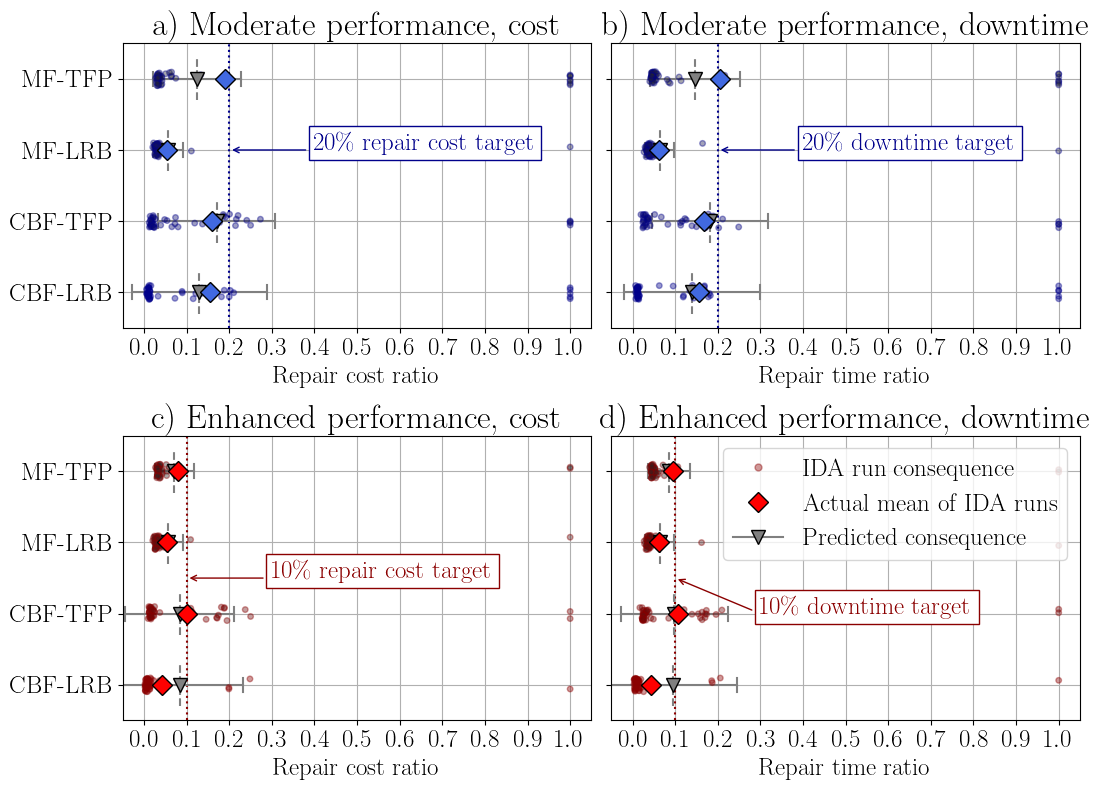

In [ ]:

def plot_predictions(mean, var, y_middle, y_bar, color):
    middle = mean
    upper = mean + var**0.5
    lower = mean - var**0.5
    
    ax.plot(middle, y_bar, 'v', ms=10, markeredgecolor='black', markerfacecolor=color, zorder=5)
    ax.plot([lower, upper], 
            [y_bar,y_bar], color=color)
    
    ax.axvline(middle, ymin=y_middle-0.075, ymax=y_middle+0.075, linestyle='--', color=color)
    ax.axvline(lower, ymin=y_middle-0.025, ymax=y_middle+0.025, color=color)
    ax.axvline(upper, ymin=y_middle-0.025, ymax=y_middle+0.025, color=color)
    
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 18
subt_font = 18
label_size = 18
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'None'},
    'medianprops':{'color':'None'},
    'whiskerprops':{'color':'None'},
    'capprops':{'color':'None'}
}

# fig, axes = plt.subplots(1, 1, 
#                          figsize=(10, 6))

inverse_color = 'darkblue'
inverse_color_2 = 'royalblue'
strict_color = 'darkred'
strict_color_2 = 'red'

fig = plt.figure(figsize=(11, 8))

### regular
cbf_tfp_ida = cbf_tfp_val_results[cbf_tfp_val_results['ida_level']==1.0]
mf_tfp_ida = mf_tfp_val_results[mf_tfp_val_results['ida_level']==1.0]
cbf_lrb_ida = cbf_lrb_val_results[cbf_lrb_val_results['ida_level']==1.0]
mf_lrb_ida = mf_lrb_val_results[mf_lrb_val_results['ida_level']==1.0]

mf_tfp_repl_cases = mf_tfp_ida[mf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
cbf_tfp_repl_cases = cbf_tfp_ida[cbf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
mf_lrb_repl_cases = mf_lrb_ida[mf_lrb_ida['replacement_freq'] >= 0.99].shape[0]
cbf_lrb_repl_cases = cbf_lrb_ida[cbf_lrb_ida['replacement_freq'] >= 0.99].shape[0]

print('MF-TFP runs requiring replacement:', mf_tfp_repl_cases)
print('MF-LRB runs requiring replacement:', mf_lrb_repl_cases)
print('CBF-TFP runs requiring replacement:', cbf_tfp_repl_cases)
print('CBF-LRB runs requiring replacement:', cbf_lrb_repl_cases)


df_dt = pd.DataFrame.from_dict(
    data=dict([('MF-TFP', mf_tfp_ida[cost_var]),
               ('MF-LRB', mf_lrb_ida[cost_var]),
               ('CBF-TFP', cbf_tfp_ida[cost_var]),
               ('CBF-LRB', cbf_lrb_ida[cost_var]),]),
    orient='index',
).T

import seaborn as sns

cbf_tfp_repair_cost = cbf_tfp_inv_pred['cost']
mf_tfp_repair_cost = mf_tfp_inv_pred['cost']
cbf_lrb_repair_cost = cbf_lrb_inv_pred['cost']
mf_lrb_repair_cost = mf_lrb_inv_pred['cost']

cbf_tfp_repair_cost_var = cbf_tfp_inv_pred['cost_var']
mf_tfp_repair_cost_var = mf_tfp_inv_pred['cost_var']
cbf_lrb_repair_cost_var = cbf_lrb_inv_pred['cost_var']
mf_lrb_repair_cost_var = mf_lrb_inv_pred['cost_var']


ax=fig.add_subplot(2, 2, 1)
plt.setp(ax, xticks=np.arange(0.0, 1.1, step=0.1))
ax = sns.stripplot(data=df_dt, orient='h', color=inverse_color, alpha=0.4, size=4,
                   edgecolor=inverse_color, linewidth=1.0)
meanpointprops = dict(marker='D', markeredgecolor='black', markersize=10,
                      markerfacecolor=inverse_color_2, zorder=20)
ax.axvline(0.2, color=inverse_color, linestyle=':')
sns.boxplot(data=df_dt, saturation=0.0, ax=ax, orient='h',
            width=0.4, showmeans=True, meanprops=meanpointprops, meanline=False, showfliers=False,
            **PROPS)
ax.set_xlabel(r'Repair cost ratio', fontsize=axis_font)




plot_predictions(mf_tfp_repair_cost, mf_tfp_repair_cost_var, 0.875, 0, 'gray')
plot_predictions(mf_lrb_repair_cost, mf_lrb_repair_cost_var, 0.625, 1, 'gray')
plot_predictions(cbf_tfp_repair_cost, cbf_tfp_repair_cost_var, 0.375, 2, 'gray')
plot_predictions(cbf_lrb_repair_cost, cbf_lrb_repair_cost_var, 0.125, 3, 'gray')
ax.set_xlim([-0.05, 1.05])

bbox_props = dict(facecolor='white', edgecolor=inverse_color)
ax.text(0.4, 1, r'20\% repair cost target',
          fontsize=subt_font, color=inverse_color, bbox=bbox_props, zorder=5)
ax.annotate(text='', xy=(0.2, 1), xytext=(0.4, 1), 
             arrowprops=dict(arrowstyle='->', color=inverse_color),
             bbox=bbox_props)

ax.grid(visible=True)
ax.set_title('a) Moderate performance, cost', fontsize=title_font)
### strict
ax=fig.add_subplot(2, 2, 3)
plt.setp(ax, xticks=np.arange(0.0, 1.1, step=0.1))
cbf_tfp_ida = cbf_tfp_strict_results[cbf_tfp_strict_results['ida_level']==1.0]
mf_tfp_ida = mf_tfp_strict_results[mf_tfp_strict_results['ida_level']==1.0]
cbf_lrb_ida = cbf_lrb_strict_results[cbf_lrb_strict_results['ida_level']==1.0]
mf_lrb_ida = mf_lrb_strict_results[mf_lrb_strict_results['ida_level']==1.0]

mf_tfp_repl_cases = mf_tfp_ida[mf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
cbf_tfp_repl_cases = cbf_tfp_ida[cbf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
mf_lrb_repl_cases = mf_lrb_ida[mf_lrb_ida['replacement_freq'] >= 0.99].shape[0]
cbf_lrb_repl_cases = cbf_lrb_ida[cbf_lrb_ida['replacement_freq'] >= 0.99].shape[0]

print('MF-TFP runs requiring replacement:', mf_tfp_repl_cases)
print('MF-LRB runs requiring replacement:', mf_lrb_repl_cases)
print('CBF-TFP runs requiring replacement:', cbf_tfp_repl_cases)
print('CBF-LRB runs requiring replacement:', cbf_lrb_repl_cases)


df_dt = pd.DataFrame.from_dict(
    data=dict([('MF-TFP', mf_tfp_ida[cost_var]),
                ('MF-LRB', mf_lrb_ida[cost_var]),
                ('CBF-TFP', cbf_tfp_ida[cost_var]),
                ('CBF-LRB', cbf_lrb_ida[cost_var]),]),
    orient='index',
).T

import seaborn as sns

cbf_tfp_repair_cost = cbf_tfp_strict_pred['cost']
mf_tfp_repair_cost = mf_tfp_strict_pred['cost']
cbf_lrb_repair_cost = cbf_lrb_strict_pred['cost']
mf_lrb_repair_cost = mf_lrb_strict_pred['cost']

cbf_tfp_repair_cost_var = cbf_tfp_strict_pred['cost_var']
mf_tfp_repair_cost_var = mf_tfp_strict_pred['cost_var']
cbf_lrb_repair_cost_var = cbf_lrb_strict_pred['cost_var']
mf_lrb_repair_cost_var = mf_lrb_strict_pred['cost_var']

ax = sns.stripplot(data=df_dt, orient='h', color=strict_color, alpha=0.4, size=4,
                    edgecolor=strict_color, linewidth=1.0)
meanpointprops = dict(marker='D', markeredgecolor='black', markersize=10,
                      markerfacecolor=strict_color_2, zorder=20)

sns.boxplot(data=df_dt, saturation=0.0, ax=ax, orient='h',
            width=0.4, showmeans=True, meanprops=meanpointprops, meanline=False, showfliers=False,
            **PROPS)
ax.set_xlabel(r'Repair cost ratio', fontsize=axis_font)
ax.axvline(0.1, color=strict_color, linestyle=':')

bbox_props = dict(facecolor='white', edgecolor=strict_color)
ax.text(0.3, 1.5, r'10\% repair cost target',
          fontsize=subt_font, color=strict_color, bbox=bbox_props, zorder=5)
ax.annotate(text='', xy=(0.1, 1.5), xytext=(0.3, 1.5), 
             arrowprops=dict(arrowstyle='->', color=strict_color),
             bbox=bbox_props)

plot_predictions(mf_tfp_repair_cost, mf_tfp_repair_cost_var, 0.875, 0, 'gray')
plot_predictions(mf_lrb_repair_cost, mf_lrb_repair_cost_var, 0.625, 1, 'gray')
plot_predictions(cbf_tfp_repair_cost, cbf_tfp_repair_cost_var, 0.375, 2, 'gray')
plot_predictions(cbf_lrb_repair_cost, cbf_lrb_repair_cost_var, 0.125, 3, 'gray')
ax.set_xlim([-0.05, 1.05])
ax.grid(visible=True)
ax.set_title('c) Enhanced performance, cost', fontsize=title_font)

###### time

### regular
cbf_tfp_ida = cbf_tfp_val_results[cbf_tfp_val_results['ida_level']==1.0]
mf_tfp_ida = mf_tfp_val_results[mf_tfp_val_results['ida_level']==1.0]
cbf_lrb_ida = cbf_lrb_val_results[cbf_lrb_val_results['ida_level']==1.0]
mf_lrb_ida = mf_lrb_val_results[mf_lrb_val_results['ida_level']==1.0]

mf_tfp_repl_cases = mf_tfp_ida[mf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
cbf_tfp_repl_cases = cbf_tfp_ida[cbf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
mf_lrb_repl_cases = mf_lrb_ida[mf_lrb_ida['replacement_freq'] >= 0.99].shape[0]
cbf_lrb_repl_cases = cbf_lrb_ida[cbf_lrb_ida['replacement_freq'] >= 0.99].shape[0]

print('MF-TFP runs requiring replacement:', mf_tfp_repl_cases)
print('MF-LRB runs requiring replacement:', mf_lrb_repl_cases)
print('CBF-TFP runs requiring replacement:', cbf_tfp_repl_cases)
print('CBF-LRB runs requiring replacement:', cbf_lrb_repl_cases)


df_dt = pd.DataFrame.from_dict(
    data=dict([('MF-TFP', mf_tfp_ida[time_var]),
               ('MF-LRB', mf_lrb_ida[time_var]),
               ('CBF-TFP', cbf_tfp_ida[time_var]),
               ('CBF-LRB', cbf_lrb_ida[time_var]),]),
    orient='index',
).T

import seaborn as sns

cbf_tfp_repair_time = cbf_tfp_inv_pred['time']
mf_tfp_repair_time = mf_tfp_inv_pred['time']
cbf_lrb_repair_time = cbf_lrb_inv_pred['time']
mf_lrb_repair_time = mf_lrb_inv_pred['time']

cbf_tfp_repair_time_var = cbf_tfp_inv_pred['time_var']
mf_tfp_repair_time_var = mf_tfp_inv_pred['time_var']
cbf_lrb_repair_time_var = cbf_lrb_inv_pred['time_var']
mf_lrb_repair_time_var = mf_lrb_inv_pred['time_var']


ax=fig.add_subplot(2, 2, 2)
plt.setp(ax, xticks=np.arange(0.0, 1.1, step=0.1))
ax = sns.stripplot(data=df_dt, orient='h', color=inverse_color, alpha=0.4, size=4,
                   edgecolor=inverse_color, linewidth=1.0)
meanpointprops = dict(marker='D', markeredgecolor='black', markersize=10,
                      markerfacecolor=inverse_color_2, zorder=20)

sns.boxplot(data=df_dt, saturation=0.0, ax=ax, orient='h',
            width=0.4, showmeans=True, meanprops=meanpointprops, meanline=False, showfliers=False,
            **PROPS)
ax.set_xlabel(r'Repair time ratio', fontsize=axis_font)
ax.axvline(0.2, color=inverse_color, linestyle=':')

plot_predictions(mf_tfp_repair_time, mf_tfp_repair_time_var, 0.875, 0, 'gray')
plot_predictions(mf_lrb_repair_time, mf_lrb_repair_time_var, 0.625, 1, 'gray')
plot_predictions(cbf_tfp_repair_time, cbf_tfp_repair_time_var, 0.375, 2, 'gray')
plot_predictions(cbf_lrb_repair_time, cbf_lrb_repair_time_var, 0.125, 3, 'gray')

bbox_props = dict(facecolor='white', edgecolor=inverse_color)
ax.text(0.4, 1, r'20\% downtime target',
          fontsize=subt_font, color=inverse_color, bbox=bbox_props, zorder=5)
ax.annotate(text='', xy=(0.2, 1), xytext=(0.4, 1), 
             arrowprops=dict(arrowstyle='->', color=inverse_color),
             bbox=bbox_props)

ax.grid(visible=True)
ax.axes.yaxis.set_ticklabels([])
ax.set_xlim([-0.05, 1.05])
ax.set_title('b) Moderate performance, downtime', fontsize=title_font)
### strict
ax=fig.add_subplot(2, 2, 4)
plt.setp(ax, xticks=np.arange(0.0, 1.1, step=0.1))
cbf_tfp_ida = cbf_tfp_strict_results[cbf_tfp_strict_results['ida_level']==1.0]
mf_tfp_ida = mf_tfp_strict_results[mf_tfp_strict_results['ida_level']==1.0]
cbf_lrb_ida = cbf_lrb_strict_results[cbf_lrb_strict_results['ida_level']==1.0]
mf_lrb_ida = mf_lrb_strict_results[mf_lrb_strict_results['ida_level']==1.0]

mf_tfp_repl_cases = mf_tfp_ida[mf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
cbf_tfp_repl_cases = cbf_tfp_ida[cbf_tfp_ida['replacement_freq'] >= 0.99].shape[0]
mf_lrb_repl_cases = mf_lrb_ida[mf_lrb_ida['replacement_freq'] >= 0.99].shape[0]
cbf_lrb_repl_cases = cbf_lrb_ida[cbf_lrb_ida['replacement_freq'] >= 0.99].shape[0]

print('MF-TFP runs requiring replacement:', mf_tfp_repl_cases)
print('MF-LRB runs requiring replacement:', mf_lrb_repl_cases)
print('CBF-TFP runs requiring replacement:', cbf_tfp_repl_cases)
print('CBF-LRB runs requiring replacement:', cbf_lrb_repl_cases)


df_dt = pd.DataFrame.from_dict(
    data=dict([('MF-TFP', mf_tfp_ida[time_var]),
                ('MF-LRB', mf_lrb_ida[time_var]),
                ('CBF-TFP', cbf_tfp_ida[time_var]),
                ('CBF-LRB', cbf_lrb_ida[time_var]),]),
    orient='index',
).T

import seaborn as sns

cbf_tfp_repair_time = cbf_tfp_strict_pred['time']
mf_tfp_repair_time = mf_tfp_strict_pred['time']
cbf_lrb_repair_time = cbf_lrb_strict_pred['time']
mf_lrb_repair_time = mf_lrb_strict_pred['time']

cbf_tfp_repair_time_var = cbf_tfp_strict_pred['time_var']
mf_tfp_repair_time_var = mf_tfp_strict_pred['time_var']
cbf_lrb_repair_time_var = cbf_lrb_strict_pred['time_var']
mf_lrb_repair_time_var = mf_lrb_strict_pred['time_var']

ax = sns.stripplot(data=df_dt, orient='h', color=strict_color, alpha=0.4, size=4,
                    edgecolor=strict_color, linewidth=1.0)
meanpointprops = dict(marker='D', markeredgecolor='black', markersize=10,
                      markerfacecolor=strict_color_2, zorder=20)

sns.boxplot(data=df_dt, saturation=0.0, ax=ax, orient='h',
            width=0.4, showmeans=True, meanprops=meanpointprops, meanline=False, showfliers=False,
            **PROPS)
ax.set_xlabel(r'Repair time ratio', fontsize=axis_font)
ax.axvline(0.1, color=strict_color, linestyle=':')

bbox_props = dict(facecolor='white', edgecolor=strict_color)
ax.text(0.3, 2.0, r'10\% downtime target',
          fontsize=subt_font, color=strict_color, bbox=bbox_props, zorder=5)
ax.annotate(text='', xy=(0.1, 1.5), xytext=(0.3, 2.0), 
             arrowprops=dict(arrowstyle='->', color=strict_color),
             bbox=bbox_props)

plot_predictions(mf_tfp_repair_time, mf_tfp_repair_time_var, 0.875, 0, 'gray')
plot_predictions(mf_lrb_repair_time, mf_lrb_repair_time_var, 0.625, 1, 'gray')
plot_predictions(cbf_tfp_repair_time, cbf_tfp_repair_time_var, 0.375, 2, 'gray')
plot_predictions(cbf_lrb_repair_time, cbf_lrb_repair_time_var, 0.125, 3, 'gray')

ax.grid(visible=True)
ax.axes.yaxis.set_ticklabels([])
ax.set_title('d) Enhanced performance, downtime', fontsize=title_font)

import matplotlib.patches as mpatches
custom_lines = [
                Line2D([-1], [-1], color='white', marker='o', markeredgecolor=strict_color,
                       alpha=0.4, markerfacecolor=strict_color, markersize=5),
                Line2D([-1], [-1], color='white', marker='D', markeredgecolor='black'
                       , markerfacecolor=strict_color_2, markersize=10),
                Line2D([0, 0], [-1, 1], color='gray', marker='v', markeredgecolor='black',
                       markerfacecolor='gray', markersize=10)
                ]

ax.legend(custom_lines, ['IDA run consequence', 'Actual mean of IDA runs', 
                         'Predicted consequence'], 
           fontsize=subt_font)

ax.set_xlim([-0.05, 1.05])
fig.tight_layout()
plt.show()

## Time-based analysis

### Load hazard scenario

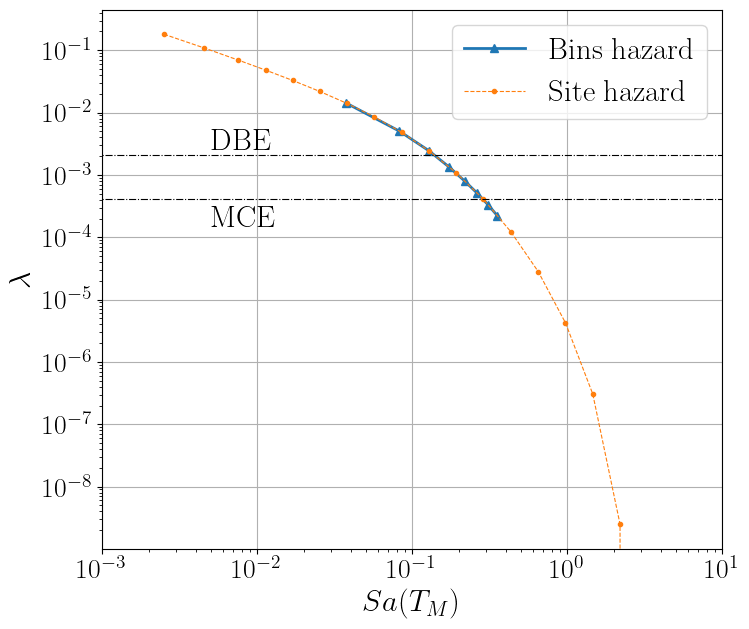

In [64]:
#%% define earthquake hazard
# reference: P-58 Implementation, Ch. 3.5

import json
import bisect
from scipy.interpolate import interp2d
with open('../../resource/hazard_curves/dwight_7th.json') as f:
    site_hazard_curves = json.load(f)['response']

np.seterr(divide='ignore')


def get_hazard_bins(T, hazard_curves, sa_max=1.016):
    T_list = [0.0, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0]
    idx_between = bisect.bisect(T_list, T)
    
    # 0 is total
    below_lambda = hazard_curves[idx_between-1]['data'][0]['yvalues']
    below_sa = hazard_curves[idx_between-1]['metadata']['xvalues']
    
    above_lambda = hazard_curves[idx_between]['data'][0]['yvalues']
    above_sa = hazard_curves[idx_between]['metadata']['xvalues']
    
    x2 = T_list[idx_between]
    x1 = T_list[idx_between-1]
    
    # assume that both series have the same length
    sa_T = [(g + h) / 2 for g, h in zip(below_sa, above_sa)]
    lambda_T = [y1+(T-x1)*(y2-y1)/(x2-x1) for y1, y2 in zip(below_lambda, above_lambda)]
    
    # sa max is max sa_avg from the dataset
    if T > 1.0:
        sa_min = 0.05/T
    else:
        sa_min = 0.05
        
    # use 8 bins
    sa_ends = np.linspace(sa_min, sa_max, 9)
    sa_bins = (sa_ends[1:] + sa_ends[:-1]) / 2
    
    # interpolate in logspace
    log_lambda = np.log(lambda_T)
    log_lambda[log_lambda == -np.inf] = -100
    lambda_bins = np.exp(np.interp(np.log(sa_bins), np.log(sa_T), log_lambda))
    
    # from here, methodology is to use sa_bins to scale ground motions and analyze
    return(sa_bins, lambda_bins, sa_T, lambda_T)

sa_bins, lambda_bins, sa_T, lambda_T = get_hazard_bins(3.36, site_hazard_curves,
                                                       sa_max=0.376)


plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=22
axis_font = 22
subt_font = 22
label_size = 20
clabel_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 



fig = plt.figure(figsize=(8,7))
ax=fig.add_subplot(1, 1, 1)

ax.loglog(sa_bins,lambda_bins, '-^', label='Bins hazard', linewidth=2.0)
ax.loglog(sa_T,lambda_T, '--o', label='Site hazard', linewidth=0.8, markersize=3)
ax.legend(fontsize=axis_font)

ax.set_xlim([1e-3, 1e1])

ax.hlines(y=1/475, xmin=0, xmax=1000, color='black', linestyle="-.", linewidth=0.8)
ax.hlines(y=1/2475, xmin=0, xmax=1000, color='black', linestyle="-.", linewidth=0.8)

ax.text(5e-3, 1.5e-4, r'MCE',
          fontsize=subt_font, color='black')
ax.text(5e-3, 2.5e-3, r'DBE',
          fontsize=subt_font, color='black')

ax.set_xlabel(r'$Sa(T_M)$', fontsize=axis_font)
ax.set_ylabel(r'$\lambda$', fontsize=axis_font)
ax.grid()

### Rebuilding loss curve from 20 samples

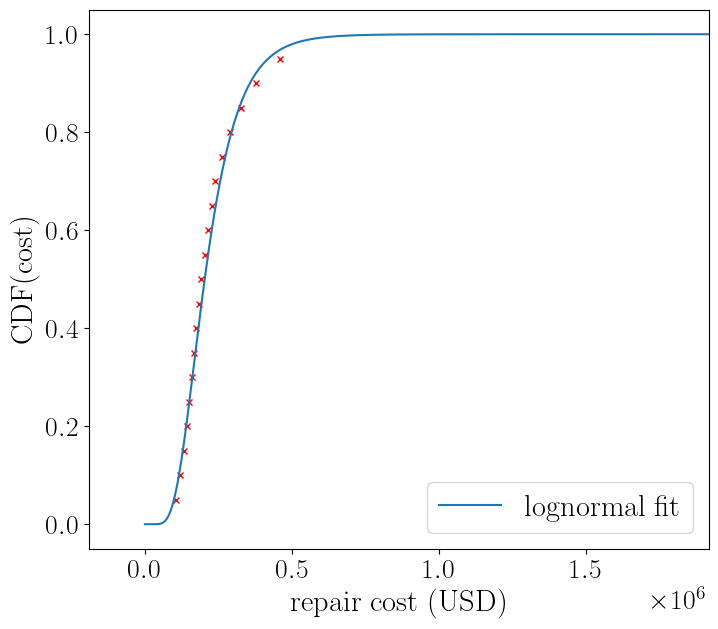

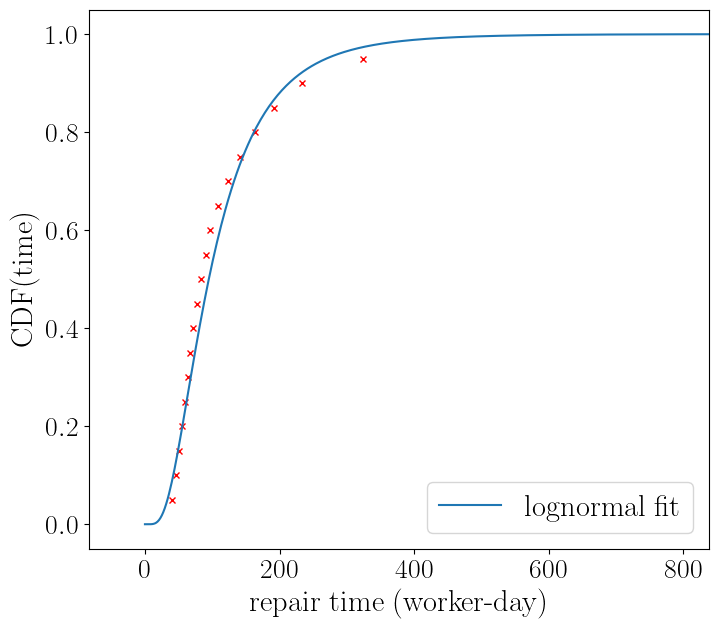

In [50]:


from scipy.stats import norm

# make lambda function for generic lognormal distribution
import numpy as np
lognorm_f = lambda x,theta,beta: norm(np.log(theta), beta**0.5).cdf(np.log(x))

# make lambda function for generic weibull distribution
from scipy.stats import weibull_min
weibull_f = lambda x,k,lam,loc: weibull_min(k, loc=loc, scale=lam).cdf(x)

#%%  rebuilt curves

def plot_loss(row):
    # plot lognormal fits
    
    import matplotlib.pyplot as plt
    plt.close('all')
    fig = plt.figure(figsize=(8, 7))
    ax1=fig.add_subplot(1, 1, 1)
    
    # res = ecdf(row['repair_cost'])
    ecdf_prob = row['cost_quantiles'].index
    ecdf_values = row['cost_quantiles'].values
    median_val = row['cost_50%']
    ax1.plot([ecdf_values], [ecdf_prob], 
              marker='x', markersize=5, color="red")
    
    xx_pr = np.linspace(1e-4, 10*median_val, 400)
    p = lognorm_f(xx_pr, row['cost_theta'], row['cost_beta'])
    ax1.plot(xx_pr, p, label='lognormal fit')
    # p = weibull_f(xx_pr, row['cost_k'], row['cost_lam'], 0)
    # ax1.plot(xx_pr, p, label='weibull fit')  
    # p = weibull_f(xx_pr, row['cost_k_trunc'], row['cost_lam_trunc'], row['cost_min'])
    # ax1.plot(xx_pr, p, label='weibull truncated fit') 
    ax1.set_xlim([-median_val, 10*median_val])
    ax1.set_ylabel('CDF(cost)', fontsize=axis_font)
    ax1.set_xlabel('repair cost (USD)', fontsize=axis_font)
    ax1.legend(fontsize=axis_font)
    
    
    fig = plt.figure(figsize=(8, 7))
    ax1=fig.add_subplot(1, 1, 1)
    # res = ecdf(row['repair_cost'])
    ecdf_prob = row['time_l_quantiles'].index
    ecdf_values = row['time_l_quantiles'].values
    median_val = row['time_l_50%']
    ax1.plot([ecdf_values], [ecdf_prob], 
              marker='x', markersize=5, color="red")
    
    xx_pr = np.linspace(1e-4, 10*median_val, 400)
    p = lognorm_f(xx_pr, row['time_l_theta'], row['time_l_beta'])
    ax1.plot(xx_pr, p, label='lognormal fit')
    # p = weibull_f(xx_pr, row['time_l_k'], row['time_l_lam'], 0)
    # ax1.plot(xx_pr, p, label='weibull fit')  
    # p = weibull_f(xx_pr, row['time_l_k_trunc'], row['time_l_lam_trunc'], row['time_l_min'])
    # ax1.plot(xx_pr, p, label='weibull truncated fit') 
    ax1.set_xlim([-median_val, 10*median_val])
    ax1.set_ylabel('CDF(time)', fontsize=axis_font)
    ax1.set_xlabel('repair time (worker-day)', fontsize=axis_font)
    ax1.legend(fontsize=axis_font)

    return

current_idx = 299
current_row = df_loss.iloc[current_idx]
plot_loss(current_row)

### Theta-beta models

In [22]:
#%% regression models: beta
# goal: E[beta|theta]

### cost
beta_covariates = [cost_var]
mdl_beta_cost_mf_tfp = GP(df_mf_tfp)
mdl_beta_cost_mf_tfp.set_covariates(beta_covariates)
mdl_beta_cost_mf_tfp.set_outcome('cost_beta')
mdl_beta_cost_mf_tfp.test_train_split(0.2)

mdl_beta_cost_mf_lrb = GP(df_mf_lrb)
mdl_beta_cost_mf_lrb.set_covariates(beta_covariates)
mdl_beta_cost_mf_lrb.set_outcome('cost_beta')
mdl_beta_cost_mf_lrb.test_train_split(0.2)

mdl_beta_cost_cbf_tfp = GP(df_cbf_tfp)
mdl_beta_cost_cbf_tfp.set_covariates(beta_covariates)
mdl_beta_cost_cbf_tfp.set_outcome('cost_beta')
mdl_beta_cost_cbf_tfp.test_train_split(0.2)

mdl_beta_cost_cbf_lrb = GP(df_cbf_lrb)
mdl_beta_cost_cbf_lrb.set_covariates(beta_covariates)
mdl_beta_cost_cbf_lrb.set_outcome('cost_beta')
mdl_beta_cost_cbf_lrb.test_train_split(0.2)

### time
beta_covariates = [time_var]
mdl_beta_time_mf_tfp = GP(df_mf_tfp)
mdl_beta_time_mf_tfp.set_covariates(beta_covariates)
mdl_beta_time_mf_tfp.set_outcome('time_l_beta')
mdl_beta_time_mf_tfp.test_train_split(0.2)

mdl_beta_time_mf_lrb = GP(df_mf_lrb)
mdl_beta_time_mf_lrb.set_covariates(beta_covariates)
mdl_beta_time_mf_lrb.set_outcome('time_l_beta')
mdl_beta_time_mf_lrb.test_train_split(0.2)

mdl_beta_time_cbf_tfp = GP(df_cbf_tfp)
mdl_beta_time_cbf_tfp.set_covariates(beta_covariates)
mdl_beta_time_cbf_tfp.set_outcome('time_l_beta')
mdl_beta_time_cbf_tfp.test_train_split(0.2)

mdl_beta_time_cbf_lrb = GP(df_cbf_lrb)
mdl_beta_time_cbf_lrb.set_covariates(beta_covariates)
mdl_beta_time_cbf_lrb.set_outcome('time_l_beta')
mdl_beta_time_cbf_lrb.test_train_split(0.2)

print('======= beta regression per system  ========')
t0 = time.time()

# note, fitting kernel ridge is just kernel regression here bc only one feature
mdl_beta_cost_mf_tfp.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_cost_mf_lrb.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_cost_cbf_tfp.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_cost_cbf_lrb.fit_kernel_ridge(kernel_name='laplacian')

mdl_beta_time_mf_tfp.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_time_mf_lrb.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_time_cbf_tfp.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_time_cbf_lrb.fit_kernel_ridge(kernel_name='laplacian')

tp = time.time() - t0

print("KR training for beta done for 8 models in %.3f s" % tp)

beta_regression_mdls = {'mdl_beta_cost_mf_tfp': mdl_beta_cost_mf_tfp,
                        'mdl_beta_cost_mf_lrb': mdl_beta_cost_mf_lrb,
                        'mdl_beta_cost_cbf_tfp': mdl_beta_cost_cbf_tfp,
                        'mdl_beta_cost_cbf_lrb': mdl_beta_cost_cbf_lrb,
                        'mdl_beta_time_mf_tfp': mdl_beta_time_mf_tfp,
                        'mdl_beta_time_mf_lrb': mdl_beta_time_mf_lrb,
                        'mdl_beta_time_cbf_tfp': mdl_beta_time_cbf_tfp,
                        'mdl_beta_time_cbf_lrb': mdl_beta_time_cbf_lrb}

mdl_beta_cost_cbf_lrb.fit_poly(degree=5)

======= beta regression per system  ========
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.0001}
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.0001}
The best kernel ridge parameters are {'kr__alpha': 0.001, 'kr__gamma': 0.1}
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.01}
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.0001}
The best kernel ridge parameters are {'kr__alpha': 1.0, 'kr__gamma': 0.1}
The best kernel ridge parameters are {'kr__alpha': 0.1, 'kr__gamma': 1.0}
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.0001}
KR training for beta done for 8 models in 9.192 s


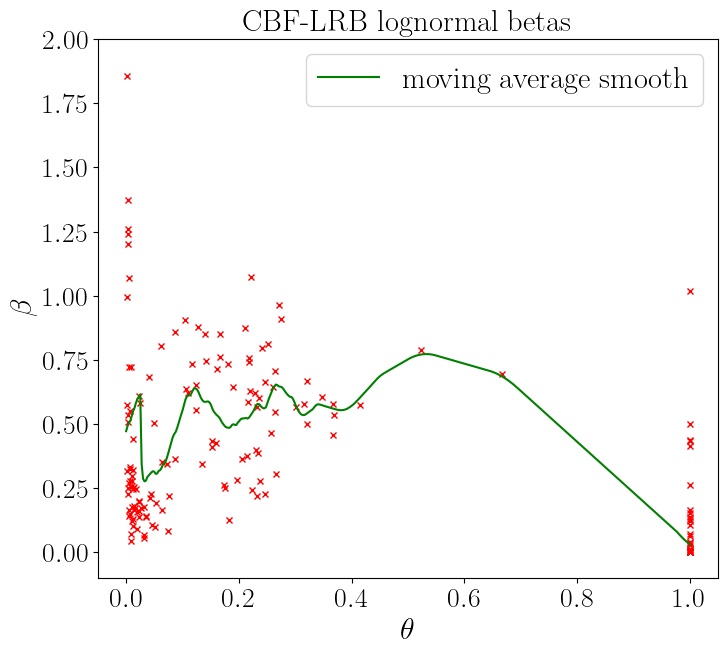

In [26]:
# low loss & extremely high loss = less dispersion
# extremely low loss: variance high bc of scaling/relative
# moderate loss: greater dispersion
import matplotlib.pyplot as plt
plt.close('all')
fig = plt.figure(figsize=(8, 7))
ax1=fig.add_subplot(1, 1, 1)

ax1.plot([np.array(mdl_beta_cost_cbf_lrb.X_train).ravel()], [mdl_beta_cost_cbf_lrb.y_train], 
          marker='x', markersize=5, color="red")

nplot = 400
xx_pr = np.linspace(1e-4, 1.0, nplot).reshape(-1,1)
yy_pr = mdl_beta_cost_cbf_lrb.kr.predict(xx_pr)
# ax1.plot(xx_pr, yy_pr, label='kernel ridge - laplacian')

# TODO: in truth, you should not use filter/smoothing, but rather achieve smoothing
# through kernel hyperparameter bounds

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    # cumsum = np.cumsum(np.insert(y, 0, 0)) 
    # return (cumsum[box_pts:] - cumsum[:-box_pts]) / float(box_pts)
    return y_smooth

from scipy.signal import savgol_filter

# y_sg = savgol_filter(yy_pr.ravel(), int(.05*nplot), 2)
# ax1.plot(xx_pr, y_sg, color='black', label='smoothed with savgol')

y_sm = smooth(yy_pr.ravel(), int(.05*nplot))
ax1.plot(xx_pr, y_sm, color='green', label='moving average smooth, kr laplacian')

# yy_pr = mdl_beta_cost_cbf_lrb.o_ridge.predict(xx_pr)
# ax1.plot(xx_pr, yy_pr, label='ordinary ridge')

# yy_pr = mdl_beta_cost_cbf_lrb.gpr.predict(xx_pr)
# ax1.plot(xx_pr, yy_pr, label='gpr-rq')

yy_pr = mdl_beta_cost_cbf_lrb.poly.predict(xx_pr)
# ax1.plot(xx_pr, yy_pr, label='5th degree poly')

ax1.set_ylim([-.1, 2])
ax1.set_title(r'CBF-LRB lognormal betas', fontsize=axis_font)
ax1.set_xlabel(r'$\theta$', fontsize=axis_font)
ax1.set_ylabel(r'$\beta$', fontsize=axis_font)
ax1.legend(fontsize=axis_font)


### Function for MCAC calculation

In [32]:
def calculate_lifetime_loss(row, impact_clfs, cost_regs, time_regs, beta_regs,
                            cost_var='cmp_cost_ratio', time_var='cmp_time_ratio'):
    
    # here, we have to hack together a representation of the expected loss at different sa
    T = row['T_m']
    
    # use maximum as 1.5* mce level Sa(T_m)
    mce_Sa_Tm = row['S_1']/row['T_m']
    sa_bins, lambda_bins, sa_T, lambda_T = get_hazard_bins(T, site_hazard_curves,
                                                            sa_max=1.5*mce_Sa_Tm)
    
    
    # sa_bins, lambda_bins, sa_T, lambda_T = get_hazard_bins(T, site_hazard_curves)
    
    
    # how are each design variables affected by changing Sa
    # only GR changes
    GR_bins = row['gap_ratio']*row['sa_tm']/sa_bins
    
    # set of new design variables corresponding to the bins' hazards
    X_bins = pd.DataFrame({'gap_ratio':GR_bins,
                         'RI':np.repeat(row['RI'], len(GR_bins)),
                         'T_ratio':np.repeat(row['T_ratio'], len(GR_bins)),
                         'zeta_e':np.repeat(row['zeta_e'], len(GR_bins))
                         })
    
    
    ############################################################################
    # approach 1
    # use GP to find the 
    ############################################################################
    # pick the correct GP models
    # get system name
    system_name = row.system.lower().replace('-','_')
    
    # identify cost models
    mdl_impact_name = 'mdl_impact_' + system_name
    mdl_cost_hit_name = 'mdl_cost_' + system_name + '_i'
    mdl_cost_miss_name = 'mdl_cost_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_cost_hit = cost_regs[mdl_cost_hit_name]
    mdl_cost_miss = cost_regs[mdl_cost_miss_name]
    
    # identify time models
    mdl_time_hit_name = 'mdl_time_' + system_name + '_i'
    mdl_time_miss_name = 'mdl_time_' + system_name + '_o'
    
    mdl_time_hit = time_regs[mdl_time_hit_name]
    mdl_time_miss = time_regs[mdl_time_miss_name]
    
    # identify beta models
    mdl_cost_beta_name = 'mdl_beta_cost_' + system_name
    mdl_time_beta_name = 'mdl_beta_time_' + system_name
    
    mdl_cost_beta = beta_regs[mdl_cost_beta_name]
    mdl_time_beta = beta_regs[mdl_time_beta_name]
    
    # for the set of "new" design variables, use GP to calculate loss ratio
    # assumes GPC/GPR, predict the outcome for the design space
    # TODO: change this to simple GP?
    cost_ratio_bins = predict_DV(X_bins, 
                                   mdl_impact.gpc, 
                                   mdl_cost_hit.gpr, 
                                   mdl_cost_miss.gpr, 
                                   outcome=cost_var)
    
    time_ratio_bins = predict_DV(X_bins,
                                mdl_impact.gpc,
                                mdl_time_hit.gpr,
                                mdl_time_miss.gpr,
                                outcome=time_var)
    
    # predict dispersion given theta for each bin
    
    # using true kr to find beta from theta
    
    # cost_beta_bins = mdl_cost_beta.kr.predict(
    #     np.array(cost_ratio_bins[cost_var+'_pred']).reshape(-1,1))
    
    # time_beta_bins = mdl_time_beta.kr.predict(
    #     np.array(time_ratio_bins[time_var+'_pred']).reshape(-1,1))
    
    # using kr + savgol filter smoothing to find beta from theta
    nplot = 400
    xx_pr = np.linspace(1e-4, 1.2, nplot).reshape(-1,1)
    yy_pr = mdl_cost_beta.kr.predict(xx_pr)
    y_sg = savgol_filter(yy_pr.ravel(), int(.05*nplot), 2)
    y_sm = smooth(yy_pr.ravel(), int(.05*nplot))
    # cost_beta_bins = np.interp(cost_ratio_bins[cost_var+'_pred'].values, 
    #                            xx_pr.ravel(), y_sg)
    cost_beta_bins = np.interp(cost_ratio_bins[cost_var+'_pred'].values, 
                                xx_pr.ravel(), y_sm)
    
    yy_pr = mdl_time_beta.kr.predict(xx_pr)
    y_sg = savgol_filter(yy_pr.ravel(), int(.05*nplot), 2)
    y_sm = smooth(yy_pr.ravel(), int(.05*nplot))
    # time_beta_bins = np.interp(time_ratio_bins[time_var+'_pred'].values, 
    #                            xx_pr.ravel(), y_sg)
    time_beta_bins = np.interp(time_ratio_bins[time_var+'_pred'].values, 
                                xx_pr.ravel(), y_sm)
    
    # unnormalize loss ratio back to loss
    cost_bins = cost_ratio_bins.values*row.total_cmp_cost
    time_bins = time_ratio_bins.values*row.total_cmp_time
    
    cost_bins[cost_bins < 0.0] = 1.0
    time_bins[time_bins < 0.0] = 0.04167
    
    # set any <0 cost to a dollar
    # set any <0 time to 30 mins
    
    # make exceedance curve for each scenario
    # use total replacement just to have a bigger number
    cost_loss_values = np.linspace(1e-4, row['replacement_cost'], 1000)
    time_loss_values = np.linspace(1e-4, row['replacement_time'], 1000)
    
    
    # cost_loss_values = np.linspace(1e-4, row['total_cmp_cost'], 1000)
    # time_loss_values = np.linspace(1e-4, row['total_cmp_time'], 1000)
    
    cost_scns = np.zeros([len(cost_loss_values), len(cost_bins)])
    time_scns = np.zeros([len(time_loss_values), len(time_bins)])
    
    
    for scn_idx in range(len(cost_bins)):
        
        cost_scns[:,scn_idx] = lognorm_f(cost_loss_values, cost_bins[scn_idx], cost_beta_bins[scn_idx])
        time_scns[:,scn_idx] = lognorm_f(time_loss_values, time_bins[scn_idx], time_beta_bins[scn_idx])
        
    cost_scns[cost_loss_values > row['total_cmp_cost_ub'], :] = 1.0
    time_scns[time_loss_values > row['total_cmp_time_ub'], :] = 1.0
    
    pr_exceedance_cost = 1 - cost_scns
    pr_exceedance_time = 1 - time_scns
    
    cost_loss_rates = np.multiply(pr_exceedance_cost, lambda_bins)
    time_loss_rates = np.multiply(pr_exceedance_time, lambda_bins)
    
    
    # import matplotlib.pyplot as plt
    # plt.close('all')
    # fig = plt.figure(figsize=(8, 7))
    # ax1=fig.add_subplot(1, 1, 1)
    # ax1.plot(sa_bins, cost_bins.ravel(), '-o')
    # ax1.set_xlabel(r'$Sa(T_M)$', fontsize=axis_font)
    # ax1.set_ylabel(r'GP predicted median repair cost (\$)', fontsize=axis_font)
    # ax1.grid()
    # plt.show()
    # # ax1.set_xlim([0, row['replacement_cost']])
    
    # import matplotlib.pyplot as plt
    # # plt.close('all')
    # fig = plt.figure(figsize=(9, 6))
    # ax1=fig.add_subplot(1, 1, 1)
    
    # for scn_idx in range(len(cost_bins)):
    #     ax1.plot(cost_loss_values, pr_exceedance_cost[:,scn_idx], label='scn_'+str(scn_idx))
    # ax1.legend()
    # ax1.set_xlabel(r'Cost (\$)', fontsize=axis_font)
    # ax1.set_ylabel(r'$Pr[X \geq \$]$', fontsize=axis_font)
    # ax1.grid()
    # ax1.set_xlim([0, row['replacement_cost']])
    
    
    # import matplotlib.pyplot as plt
    # # plt.close('all')
    # fig = plt.figure(figsize=(9, 7))
    # ax1=fig.add_subplot(1, 1, 1)
    
    # for scn_idx in range(len(cost_bins)):
    #     ax1.plot(cost_loss_values, cost_loss_rates[:,:scn_idx+1].sum(axis=1), label='scn_'+str(scn_idx))
    # ax1.legend()
    # ax1.set_xlabel(r'Cost (\$)', fontsize=axis_font)
    # ax1.set_ylabel(r'$Pr[X \geq \$]$', fontsize=axis_font)
    # ax1.grid()
    # ax1.set_xlim([0, row['replacement_cost']])
    
    # fig = plt.figure(figsize=(9, 7))
    # ax1=fig.add_subplot(1, 1, 1)
    
    # for scn_idx in range(len(time_bins)):
    #     ax1.plot(time_loss_values, time_loss_rates[:,:scn_idx+1].sum(axis=1), label='scn_'+str(scn_idx))
    # ax1.legend()
    # ax1.set_xlabel(r'time (man-hour)', fontsize=axis_font)
    # ax1.set_ylabel(r'$Pr[X \geq t]$', fontsize=axis_font)
    # ax1.grid()
    # ax1.set_xlim([0, row['replacement_time']])
    
    # breakpoint()
    
    # multiply scenarios' exceedance curve with corresponding return rate
    # sum across all scenarios
    agg_cost_exceedance_rate = pr_exceedance_cost @ lambda_bins
    agg_time_exceedance_rate = pr_exceedance_time @ lambda_bins
    
    # integrate to attain lifetime dollar, time
    mean_cumulative_annual_cost = np.trapz(agg_cost_exceedance_rate, cost_loss_values)
    mean_cumulative_annual_time = np.trapz(agg_time_exceedance_rate, time_loss_values)
    
    # renormalize
    
    return mean_cumulative_annual_cost, mean_cumulative_annual_time

In [34]:
# Execute MCAC

#%% 

row_no = 0
row = df.iloc[row_no]
mcac, mcat = calculate_lifetime_loss(row,
                                    impact_clfs=impact_classification_mdls, 
                                    cost_regs=cost_regression_mdls, 
                                    time_regs=time_regression_mdls,
                                    beta_regs=beta_regression_mdls)
    
print(mcac, mcat)

#%% 

t0 = time.time()
df[['mean_cumulative_annual_cost', 
    'mean_cumulative_annual_time']] = df.apply(
        lambda row: calculate_lifetime_loss(row,
                                    impact_clfs=impact_classification_mdls, 
                                    cost_regs=cost_regression_mdls, 
                                    time_regs=time_regression_mdls,
                                    beta_regs=beta_regression_mdls),
        axis='columns', result_type='expand')

tp = time.time() - t0
print("Calculated lifetime losses for 1000 points in  %.3f s" % tp)

#%%
df['annual_cost_ratio'] = df['mean_cumulative_annual_cost']/df['total_cmp_cost']
df['annual_time_ratio'] = df['mean_cumulative_annual_time']/df['total_cmp_time']


336710.42217185604 116.90657893758365
Calculated lifetime losses for 1000 points in  16.433 s


In [35]:
# include MCAC into data sets
#%% re subsets

df_tfp = df[df['isolator_system'] == 'TFP']
df_lrb = df[df['isolator_system'] == 'LRB']

df_cbf = df[df['superstructure_system'] == 'CBF'].reset_index()
df_cbf['dummy_index'] = df_cbf['replacement_freq'] + df_cbf['index']*1e-9
df_mf = df[df['superstructure_system'] == 'MF'].reset_index()
df_mf['dummy_index'] = df_mf['replacement_freq'] + df_mf['index']*1e-9

df_mf_o = df_mf[df_mf['impacted'] == 0]
df_cbf_o = df_cbf[df_cbf['impacted'] == 0]

df_mf_tfp = df_tfp[df_tfp['superstructure_system'] == 'MF']
df_mf_lrb = df_lrb[df_lrb['superstructure_system'] == 'MF']

df_cbf_tfp = df_tfp[df_tfp['superstructure_system'] == 'CBF']
df_cbf_lrb = df_lrb[df_lrb['superstructure_system'] == 'CBF']


df_mf_tfp_i = df_mf_tfp[df_mf_tfp['impacted'] == 1]
df_mf_tfp_o = df_mf_tfp[df_mf_tfp['impacted'] == 0]
df_mf_lrb_i = df_mf_lrb[df_mf_lrb['impacted'] == 1]
df_mf_lrb_o = df_mf_lrb[df_mf_lrb['impacted'] == 0]

df_cbf_tfp_i = df_cbf_tfp[df_cbf_tfp['impacted'] == 1]
df_cbf_tfp_o = df_cbf_tfp[df_cbf_tfp['impacted'] == 0]
df_cbf_lrb_i = df_cbf_lrb[df_cbf_lrb['impacted'] == 1]
df_cbf_lrb_o = df_cbf_lrb[df_cbf_lrb['impacted'] == 0]

### GP models for MCAC

In [36]:
mdl_mcac_cbf_lrb = GP(df_cbf_lrb)
mdl_mcac_cbf_lrb.set_covariates(covariate_list)
mdl_mcac_cbf_lrb.set_outcome('annual_cost_ratio')
mdl_mcac_cbf_lrb.test_train_split(0.2)

mdl_mcac_cbf_tfp = GP(df_cbf_tfp)
mdl_mcac_cbf_tfp.set_covariates(covariate_list)
mdl_mcac_cbf_tfp.set_outcome('annual_cost_ratio')
mdl_mcac_cbf_tfp.test_train_split(0.2)

mdl_mcac_mf_lrb = GP(df_mf_lrb)
mdl_mcac_mf_lrb.set_covariates(covariate_list)
mdl_mcac_mf_lrb.set_outcome('annual_cost_ratio')
mdl_mcac_mf_lrb.test_train_split(0.2)

mdl_mcac_mf_tfp = GP(df_mf_tfp)
mdl_mcac_mf_tfp.set_covariates(covariate_list)
mdl_mcac_mf_tfp.set_outcome('annual_cost_ratio')
mdl_mcac_mf_tfp.test_train_split(0.2)



mdl_mcat_cbf_lrb = GP(df_cbf_lrb)
mdl_mcat_cbf_lrb.set_covariates(covariate_list)
mdl_mcat_cbf_lrb.set_outcome('annual_time_ratio')
mdl_mcat_cbf_lrb.test_train_split(0.2)

mdl_mcat_cbf_tfp = GP(df_cbf_tfp)
mdl_mcat_cbf_tfp.set_covariates(covariate_list)
mdl_mcat_cbf_tfp.set_outcome('annual_time_ratio')
mdl_mcat_cbf_tfp.test_train_split(0.2)

mdl_mcat_mf_lrb = GP(df_mf_lrb)
mdl_mcat_mf_lrb.set_covariates(covariate_list)
mdl_mcat_mf_lrb.set_outcome('annual_time_ratio')
mdl_mcat_mf_lrb.test_train_split(0.2)

mdl_mcat_mf_tfp = GP(df_mf_tfp)
mdl_mcat_mf_tfp.set_covariates(covariate_list)
mdl_mcat_mf_tfp.set_outcome('annual_time_ratio')
mdl_mcat_mf_tfp.test_train_split(0.2)

print('======= MCAC/MCAT regression per system ========')
import time
t0 = time.time()

mdl_mcac_cbf_lrb.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcac_cbf_tfp.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcac_mf_lrb.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcac_mf_tfp.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))

mdl_mcat_cbf_lrb.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcat_cbf_tfp.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcat_mf_lrb.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcat_mf_tfp.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))

tp = time.time() - t0

print("GPR MCAC/MCAT training for cost done for 4 models in %.3f s" % tp)

mcac_regression_mdls = {'mdl_mcac_cbf_lrb': mdl_mcac_cbf_lrb,
                        'mdl_mcac_cbf_tfp': mdl_mcac_cbf_tfp,
                        'mdl_mcac_mf_lrb': mdl_mcac_mf_lrb,
                        'mdl_mcac_mf_tfp': mdl_mcac_mf_tfp}

mcat_regression_mdls = {'mdl_mcat_cbf_lrb': mdl_mcat_cbf_lrb,
                        'mdl_mcat_cbf_tfp': mdl_mcat_cbf_tfp,
                        'mdl_mcat_mf_lrb': mdl_mcat_mf_lrb,
                        'mdl_mcat_mf_tfp': mdl_mcat_mf_tfp}

======= MCAC/MCAT regression per system ========


c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\giraf\anac

GPR MCAC/MCAT training for cost done for 4 models in 4.477 s


c:\Users\giraf\anaconda3\envs\sklearn_env\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


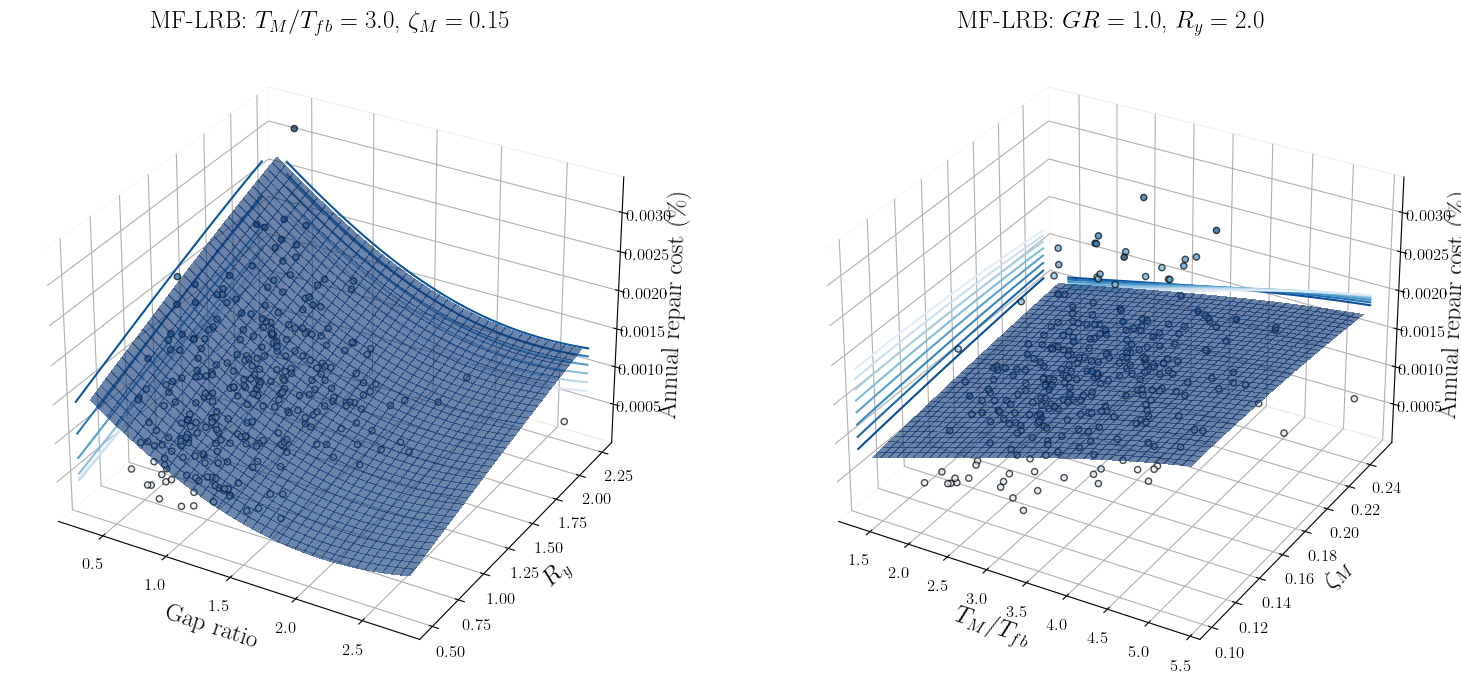

In [39]:
annual_cost_var = 'annual_cost_ratio'
mdl_mcat = mcat_regression_mdls['mdl_mcat_mf_lrb']
impact_mdl = mdl_impact_mf_lrb
df_sc = df_mf_lrb.copy()

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 18
subt_font = 18
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

fig = plt.figure(figsize=(16, 7))



xvar = 'gap_ratio'
yvar = 'RI'

res = 75
X_plot = make_2D_plotting_space(impact_mdl.X, res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 5.0, fourth_var_set = 0.15)

Z = mdl_mcat.gpr.predict(X_plot)


xx = X_plot[xvar]
yy = X_plot[yvar]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_surf = np.array(Z).reshape(xx_pl.shape)

ax=fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(xx_pl, yy_pl, Z_surf, cmap='Blues',
                        linewidth=0, antialiased=False, alpha=0.6,
                        vmin=-0.1)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.scatter(df_sc[xvar], df_sc[yvar], df_sc[annual_cost_var], c=df_sc[annual_cost_var],
            edgecolors='k', alpha = 0.7, cmap='Blues')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='x', offset=xlim[0], cmap='Blues_r')
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='y', offset=ylim[1], cmap='Blues')
# ax.set_zlim([-0.1, 1.1])

ax.set_xlabel('Gap ratio', fontsize=axis_font)
ax.set_ylabel('$R_y$', fontsize=axis_font)
ax.set_zlabel('Annual repair cost (\%)', fontsize=axis_font)
ax.set_title('MF-LRB: $T_M/T_{fb} = 3.0$, $\zeta_M = 0.15$', fontsize=subt_font)

#################################
xvar = 'T_ratio'
yvar = 'zeta_e'

res = 75
X_plot = make_2D_plotting_space(impact_mdl.X, res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 1.0, fourth_var_set = 2.0)

Z = mdl_mcat.gpr.predict(X_plot)

xx = X_plot[xvar]
yy = X_plot[yvar]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_surf = np.array(Z).reshape(xx_pl.shape)

ax=fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(xx_pl, yy_pl, Z_surf, cmap='Blues',
                        linewidth=0, antialiased=False, alpha=0.6,
                        vmin=-0.1)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.scatter(df_sc[xvar], df_sc[yvar], df_sc[annual_cost_var], c=df_sc[annual_cost_var],
            edgecolors='k', alpha = 0.7, cmap='Blues')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='x', offset=xlim[0], cmap='Blues_r')
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='y', offset=ylim[1], cmap='Blues')
# ax.set_zlim([-0.1, 1.1])

ax.set_xlabel('$T_M/ T_{fb}$', fontsize=axis_font)
ax.set_ylabel('$\zeta_M$', fontsize=axis_font)
ax.set_zlabel('Annual repair cost (\%)', fontsize=axis_font)
ax.set_title('MF-LRB: $GR = 1.0$, $R_y = 2.0$', fontsize=subt_font)
fig.tight_layout()

### Inverse design

In [41]:
from inverse import calc_upfront_cost, make_design_space
# linear regress cost as f(base shear)
from sklearn.linear_model import LinearRegression
reg_mf = LinearRegression(fit_intercept=False)
reg_mf.fit(X=df_mf[['Vs']], y=df_mf[['steel_cost']])

reg_cbf = LinearRegression(fit_intercept=False)
reg_cbf.fit(X=df_cbf[['Vs']], y=df_cbf[['steel_cost']])

reg_dict = {
    'mf':reg_mf,
    'cbf':reg_cbf
    }

def grid_search_inverse_design(res, system_name, targets_dict, config_dict, 
                               impact_clfs, mcac_regs, mcat_regs,
                               cost_var='annual_cost_ratio', time_var='annual_time_ratio'):
    import time
    
    # isolator_system = system_name.split('_')[1]
    # system_X = impact_clfs['mdl_impact_'+system_name].X
    structural_system = system_name.split('_')[0]
    
    if structural_system == 'mf':
        bound_dict = {
            'gap_ratio': (0.6, 2.0),
            'RI': (0.5, 2.25),
            'T_ratio': (2.0, 5.8),
            'zeta_e': (0.1, 0.25),
            'k_ratio': (5.0, 12.0)}
    else:
       bound_dict = {
           'gap_ratio': (0.6, 2.0),
           'RI': (0.5, 2.25),
           'T_ratio': (2.0, 11.0),
           'zeta_e': (0.1, 0.25),
           'k_ratio': (5.0, 12.0)} 
    
    X_space = make_design_space(res, bound_dict=bound_dict)
    
    # identify impact models (which has constructable kde)
    mdl_impact_name = 'mdl_impact_' + system_name
    mdl_impact = impact_clfs[mdl_impact_name]
    
    # identify cost models
    
    mdl_mcac_name = 'mdl_mcac_' + system_name
    mdl_mcac = mcac_regs[mdl_mcac_name]
    
    # identify time models
    mdl_mcat_name = 'mdl_mcat_' + system_name
    mdl_mcat = mcat_regs[mdl_mcat_name]
    
    # first, scan whole range for constructable bounds
    # constructable
    space_constr = mdl_impact.kde.score_samples(X_space)
    constr_thresh = targets_dict['constructability']
    ok_constr = X_space.loc[space_constr >= constr_thresh]
    constr_bounds = ok_constr.agg(['min', 'max'])
    variable_names = list(constr_bounds.columns)
    temp_dict = constr_bounds.to_dict()
    ranges = [tuple(temp_dict[key].values()) for key in variable_names]
    bounds = {k:v for (k,v) in zip(variable_names, ranges)}
    
    
    # then recreate a finer design space within constructable range
    X_space = make_design_space(res, bound_dict=bounds)
    
    t0 = time.time()
    space_mcac = mdl_mcac.gpr.predict(X_space)
    tp = time.time() - t0
    print("GPC-GPR MCAC prediction for %d inputs in %.3f s" % (X_space.shape[0],
                                                               tp))
    
    t0 = time.time()
    space_mcat = mdl_mcat.gpr.predict(X_space)
    tp = time.time() - t0
    print("GPC-GPR MCAT prediction for %d inputs in %.3f s" % (X_space.shape[0],
                                                                   tp))
    
    space_constr = mdl_impact.kde.score_samples(X_space)
    tp = time.time() - t0
    print("KDE constructability prediction for %d inputs in %.3f s" % (X_space.shape[0],
                                                                   tp))
    
    # filter cost threshold
    mcac_thresh = targets_dict[cost_var]
    ok_cost = X_space.loc[space_mcac<=mcac_thresh]

    # downtime threshold
    mcat_thresh = targets_dict[time_var]
    ok_time = X_space.loc[space_mcat<=mcat_thresh]

    
    # constructable
    constr_thresh = targets_dict['constructability']
    ok_constr = X_space.loc[space_constr >= constr_thresh]

    X_design = X_space[np.logical_and.reduce((
            X_space.index.isin(ok_cost.index), 
            X_space.index.isin(ok_time.index),
            X_space.index.isin(ok_constr.index)))]
    
    
    space_ok_mcac = space_mcac[X_space.index.isin(X_design.index)]
    space_ok_mcat = space_mcat[X_space.index.isin(X_design.index)]


    if X_design.shape[0] < 1:
        print('No suitable design found for system', system_name)
        return None, None, None
    
    # NPV analysis
    # compare cost of designs against baseline of that system
    
    
    if structural_system.upper() == 'MF':
        X_baseline =  pd.DataFrame(np.array([[1.0, 2.0, 2.6, 0.2]]),
                                   columns=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'])
        upfront_costs = calc_upfront_cost(
            X_design, config_dict=config_dict, steel_cost_dict=reg_dict)
        baseline_cost = calc_upfront_cost(
            X_baseline, config_dict=config_dict, steel_cost_dict=reg_dict)
        
        mcac_baseline = mdl_mcac.gpr.predict(X_baseline)[0]
        mcat_baseline = mdl_mcat.gpr.predict(X_baseline)[0]
    else:
        
        X_baseline =  pd.DataFrame(np.array([[1.0, 2.0, 5.2, 0.2]]),
                                   columns=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'])
        upfront_costs = calc_upfront_cost(
            X_design, config_dict=config_dict, steel_cost_dict=reg_dict,
            land_cost_per_sqft=1978/(3.28**2))
        baseline_cost = calc_upfront_cost(
            X_baseline, config_dict=config_dict, steel_cost_dict=reg_dict,
            land_cost_per_sqft=1978/(3.28**2))
        
        mcac_baseline = mdl_mcac.gpr.predict(X_baseline)[0]
        mcat_baseline = mdl_mcat.gpr.predict(X_baseline)[0]
    
    upgrade_cost = (upfront_costs['total_'+structural_system] - 
                    baseline_cost['total_'+structural_system].item())
    
    avoided_cost = (mcac_baseline - space_ok_mcac)*config_dict['comparable_cost_'+structural_system]
    avoided_time = (mcat_baseline - space_ok_mcat)*config_dict['comparable_time_'+structural_system]
    
    # profit loss and repair cost per worker-day
    # assume 40% of replacement cost is labor, $680/worker-day for SF Bay Area
    bldg_area = (config_dict['num_bays']*config_dict['L_bay'])**2 * (config_dict['num_stories'] + 1)

    # assume $600/sf replacement
    n_worker_series = bldg_area/1000
    n_worker_parallel = n_worker_series/2
    
    # labor rate per worker-day
    avoided_worker_cost = 680.0*avoided_time
    
    # lost profits
    # worker-day (/workers) (*$ per day)
    # based on $25/sq-ft/yr of business rent in Oakland for 3 story
    avoided_business_cost = avoided_time/n_worker_parallel*4440*1.35 * config_dict['num_stories']/3
    
    avoided_time_cost = avoided_worker_cost + avoided_business_cost
    avoided_consequence = avoided_cost + avoided_time_cost
    
    i_rate = config_dict['interest_rate']
    t_yrs = config_dict['timeframe']
    
    # upgrade is worth it if NPV of avoided consequence > upgrade cost over baseline
    NPV = avoided_consequence*((1 - 1/(1 + i_rate)**t_yrs) / i_rate)
    upgrade_value = NPV - upgrade_cost
    upgrade_decision = upgrade_value > 0
    # upgrade_decision = np.repeat(True, X_design.shape[0])
    X_worth = X_design[upgrade_decision]
    worth_costs = upfront_costs['total_'+structural_system][upgrade_decision]
    
    # import matplotlib.pyplot as plt
    # plt.close('all')
    # fig = plt.figure(figsize=(8, 7))
    # ax1=fig.add_subplot(1, 1, 1)
    # ax1.plot(sa_bins, cost_bins.ravel(), '-o')
    # ax1.set_xlabel(r'$Sa(T_M)$', fontsize=axis_font)
    # ax1.set_ylabel(r'GP predicted median repair cost (\$)', fontsize=axis_font)
    # ax1.grid()
    # plt.show()
    # # ax1.set_xlim([0, row['replacement_cost']])
    
    
    design_idx = upgrade_value.idxmax()
    inv_upfront_cost = worth_costs[upgrade_value.idxmax()]
    
    # cheapest_idx = worth_costs.idxmin()
    # inv_upfront_cost = worth_costs.min()
    
    # least upfront cost of the viable designs
    inv_design = X_worth.loc[design_idx]
    inv_mcat = space_mcat[design_idx]
    inv_mcac = space_mcac[design_idx]
    inv_upgrade_cost = upgrade_cost[design_idx]
    inv_avoided_cost = (mcac_baseline - inv_mcac)*config_dict['comparable_cost_'+structural_system]
    inv_avoided_time = (mcat_baseline - inv_mcat)*config_dict['comparable_time_'+structural_system]
    inv_avoided_consequence = inv_avoided_cost + inv_avoided_time * (
        680 + 4440*1.35/n_worker_parallel * config_dict['num_stories']/3)
    inv_NPV = inv_avoided_consequence*((1 - 1/(1 + i_rate)**t_yrs) / i_rate)
    
    inv_performance = {
        'mcat': inv_mcat,
        'mcac': inv_mcac,
        'upfront_cost': inv_upfront_cost,
        'upgrade_cost': inv_upgrade_cost,
        'avoided_cost': inv_avoided_cost,
        'avoided_time': inv_avoided_time,
        'NPV': inv_NPV}
    
    # TODO: if NPV is unifying loss function, use optimizer

    # read out predictions
    print('==================================')
    print('            Predictions           ')
    print('==================================')
    print('======= Targets =======')
    print('System:', system_name)
    print('MCAC fraction:', f'{mcac_thresh*100:,.2f}%')
    print('MCAT fraction:', f'{mcat_thresh*100:,.2f}%')


    print('======= Overall inverse design =======')
    print(inv_design)
    print('Upfront cost of selected design: ',
          f'${inv_upfront_cost:,.2f}')
    print('Upgrade cost over baseline design: '
          f'${inv_upgrade_cost:,.2f}')
    print('Predicted MCAC ratio: ',
          f'{inv_mcac*100:,.2f}%')
    print('Predicted comparable MCAC: '
          f'${inv_avoided_cost:,.2f}')
    print('Predicted MCAT ratio: ',
          f'{inv_mcat*100:,.2f}%')
    print('Predicted comparable MCAT: '
          f'{inv_avoided_time:,.2f} worker-days')
    print('Predicted NPV: '
          f'${inv_NPV:,.2f}')
    
    return(inv_design, inv_performance, X_worth)

### regular
ns = 4
hs = 13.
nb = 6
Lb = 30.

similar_mfs = df_mf[(df_mf['num_stories'] == ns) & (df_mf['num_bays'] == nb)]
similar_mf_cost = similar_mfs['total_cmp_cost'].median()
similar_mf_time = similar_mfs['total_cmp_time'].median()

similar_cbfs = df_cbf[(df_cbf['num_stories'] == ns) & (df_cbf['num_bays'] == nb)]
similar_cbf_cost = similar_cbfs['total_cmp_cost'].median()
similar_cbf_time = similar_cbfs['total_cmp_time'].median()


example_bldg_area = (nb*Lb)**2 * (ns + 1)
workers_parallel = example_bldg_area/1000/2

annual_cost_target_mf = 50e3/similar_mf_cost
annual_cost_target_cbf = 50e3/similar_cbf_cost

# 5 days target annually, with only 10% of the workers
annual_dt_target_mf = 3*0.1*workers_parallel/similar_mf_time
annual_dt_target_cbf = 3*0.1*workers_parallel/similar_cbf_time
config_dict_annual = {
    'num_stories': ns,
    'h_story': hs,
    'num_bays': nb,
    'num_frames': 2,
    'S_s': 2.2815,
    'L_bay': Lb,
    'S_1': 1.017,
    'h_bldg': hs*ns,
    'L_bldg': Lb*nb,
    'comparable_cost_mf': similar_mf_cost,
    'comparable_cost_cbf': similar_cbf_cost,
    'comparable_time_mf': similar_mf_time,
    'comparable_time_cbf': similar_cbf_time,
    'interest_rate': 0.07,
    'timeframe': 40.0
    }

mcac_var = 'annual_cost_ratio'
mcat_var = 'annual_time_ratio'

mf_targets= {
    mcac_var: annual_cost_target_mf,
    mcat_var: annual_dt_target_mf,
    'constructability': -5.0}

cbf_targets= {
    mcac_var: annual_cost_target_cbf,
    mcat_var: annual_dt_target_cbf,
    'constructability': -6.0}


mf_tfp_inv_design, mf_tfp_inv_performance, mf_tfp_space = grid_search_inverse_design(
    20, 'mf_tfp', mf_targets, config_dict_annual, 
    impact_classification_mdls, mcac_regression_mdls, 
    mcat_regression_mdls)

mf_lrb_inv_design, mf_lrb_inv_performance, mf_lrb_space = grid_search_inverse_design(
    20, 'mf_lrb', mf_targets, config_dict_annual, 
    impact_classification_mdls, mcac_regression_mdls, 
    mcat_regression_mdls)

cbf_tfp_inv_design, cbf_tfp_inv_performance, cbf_tfp_space = grid_search_inverse_design(
    20, 'cbf_tfp', cbf_targets, config_dict_annual, 
    impact_classification_mdls, mcac_regression_mdls, 
    mcat_regression_mdls)

cbf_lrb_inv_design, cbf_lrb_inv_performance, cbf_lrb_space = grid_search_inverse_design(
    20, 'cbf_lrb', cbf_targets, config_dict_annual, 
    impact_classification_mdls, mcac_regression_mdls, 
    mcat_regression_mdls)

GPC-GPR MCAC prediction for 160000 inputs in 0.621 s
GPC-GPR MCAT prediction for 160000 inputs in 0.679 s
KDE constructability prediction for 160000 inputs in 1.613 s
            Predictions           
======= Targets =======
System: mf_tfp
MCAC fraction: 0.14%
MCAT fraction: 0.29%
======= Overall inverse design =======
gap_ratio    1.088643
RI           1.988227
T_ratio      3.178947
zeta_e       0.123684
Name: 131923, dtype: float64
Upfront cost of selected design:  $9,399,131.08
Upgrade cost over baseline design: $21,941.66
Predicted MCAC ratio:  0.04%
Predicted comparable MCAC: $5,288.38
Predicted MCAT ratio:  0.08%
Predicted comparable MCAT: 2.89 worker-days
Predicted NPV: $100,545.23
GPC-GPR MCAC prediction for 160000 inputs in 0.910 s
GPC-GPR MCAT prediction for 160000 inputs in 0.935 s
KDE constructability prediction for 160000 inputs in 2.118 s
            Predictions           
======= Targets =======
System: mf_lrb
MCAC fraction: 0.14%
MCAT fraction: 0.29%
======= Overall in

### Filter graphic

C:\Users\giraf\AppData\Local\Temp\ipykernel_16340\1793701174.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(mf_lrb_space['gap_ratio'], mf_lrb_space['RI'], mf_lrb_space['T_ratio'],


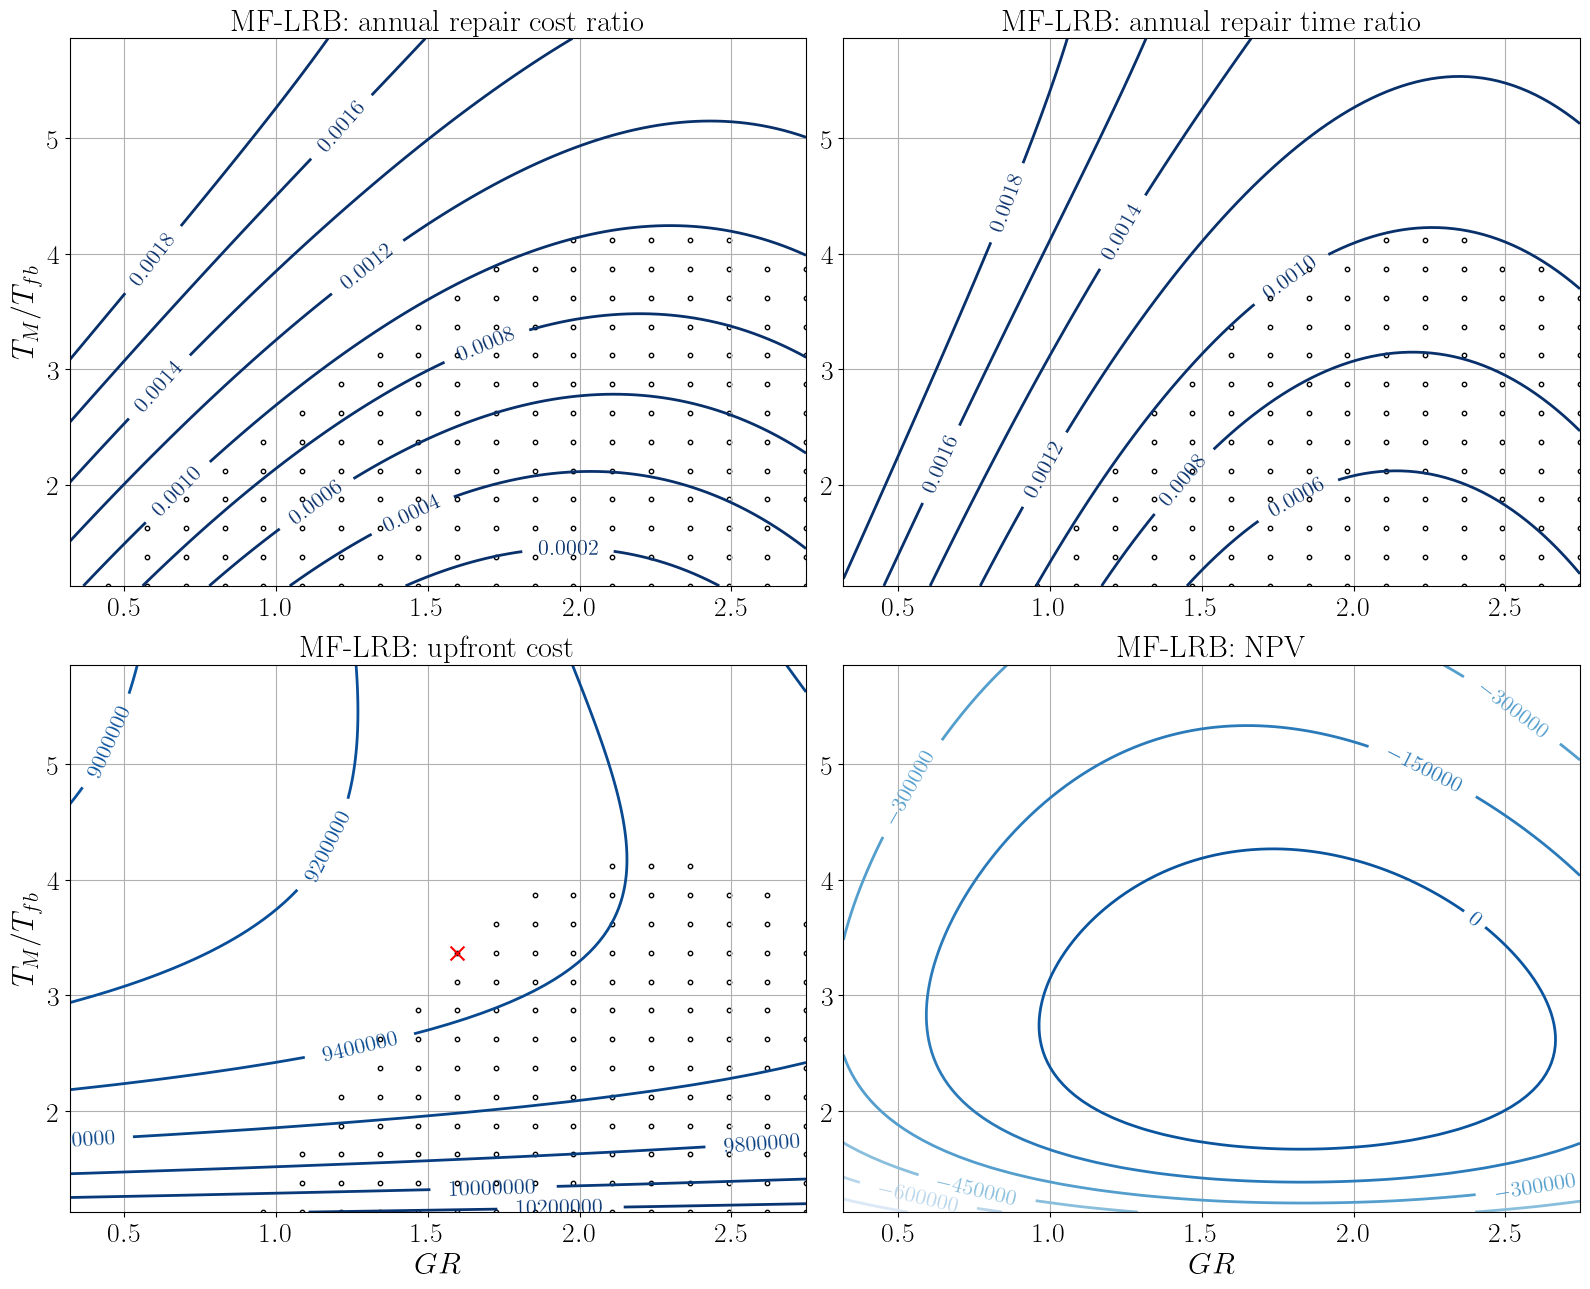

In [42]:

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 18
subt_font = 18
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

plt.close('all')
fig = plt.figure(figsize=(9, 7))

ax=fig.add_subplot(1, 1, 1, projection='3d')
sc = ax.scatter(mf_lrb_space['gap_ratio'], mf_lrb_space['RI'], mf_lrb_space['T_ratio'],
                alpha = 1, cmap=plt.cm.Spectral_r)
ax.set_xlabel('Gap ratio', fontsize=axis_font)
ax.set_ylabel(r'$R_y$', fontsize=axis_font)
# ax.set_xlim([0.3, 2.0])
ax.set_zlabel(r'$T_M / T_{fb}$', fontsize=axis_font)
ax.set_title(r'$\zeta_M$ not shown', fontsize=title_font)

#%%

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=22
axis_font = 22
subt_font = 20
label_size = 20
clabel_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
plt.close('all')

fig = plt.figure(figsize=(16, 13))

#################################
xvar = 'gap_ratio'
yvar = 'T_ratio'

# lvls = np.array([0.2])
lvls = np.arange(0.00, .002, 0.0002)

X_baseline =  pd.DataFrame(np.array([[1.0, 2.0, 2.6, 0.2]]),
                           columns=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'])
baseline_cost = calc_upfront_cost(
    X_baseline, config_dict=config_dict_annual, steel_cost_dict=reg_dict)

mcac_baseline = mcac_regression_mdls['mdl_mcac_mf_lrb'].gpr.predict(X_baseline)[0]
mcat_baseline = mcat_regression_mdls['mdl_mcat_mf_lrb'].gpr.predict(X_baseline)[0]


####### MFs
res = 100
X_plot = make_2D_plotting_space(df_mf[covariate_list], res, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 2.0, fourth_var_set = 0.23)

X_sc = make_2D_plotting_space(df_mf[covariate_list], 20, x_var=xvar, y_var=yvar, 
                            all_vars=covariate_list,
                            third_var_set = 2.0, fourth_var_set = 0.23)

xx = X_plot[xvar]
yy = X_plot[yvar]

x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

## mf-TFP: cost
ax = fig.add_subplot(2, 2, 1)
# plt.setp(ax, xticks=np.arange(2.0, 11.0, step=1.0))

grid_cost =  mcac_regression_mdls['mdl_mcac_mf_lrb'].gpr.predict(X_plot)
qual_cost = mcac_regression_mdls['mdl_mcac_mf_lrb'].gpr.predict(X_sc)

X_sc_qual_cost = X_sc[qual_cost < 0.001]
sc = ax.scatter(X_sc_qual_cost[xvar], X_sc_qual_cost[yvar], c='white', edgecolors='black', s=10)

Z = np.array(grid_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues', vmin=-0.5, levels=lvls)

clabels = ax.clabel(cs, fontsize=clabel_size)
# ax.set_xlim([0.5, 2.0])
# ax.set_ylim([0.5, 2.3])


ax.grid(visible=True)
ax.set_title(r'MF-LRB: annual repair cost ratio', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$T_M/T_{fb}$', fontsize=axis_font)

## mf-TFP: time
ax = fig.add_subplot(2, 2, 2)
# plt.setp(ax, xticks=np.arange(2.0, 11.0, step=1.0))

grid_time =  mcat_regression_mdls['mdl_mcat_mf_lrb'].gpr.predict(X_plot)
qual_time = mcat_regression_mdls['mdl_mcat_mf_lrb'].gpr.predict(X_sc)

X_sc_qual_time = X_sc[qual_time < 0.001]
sc = ax.scatter(X_sc_qual_time[xvar], X_sc_qual_time[yvar], c='white', edgecolors='black', s=10)

Z = np.array(grid_time)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues', vmin=-0.5, levels=lvls)

clabels = ax.clabel(cs, fontsize=clabel_size)
# ax.set_xlim([0.5, 2.0])
# ax.set_ylim([0.5, 2.3])


ax.grid(visible=True)
ax.set_title(r'MF-LRB: annual repair time ratio', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
# ax.set_xlabel(r'$GR$', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)


## mf-TFP: cost
ax = fig.add_subplot(2, 2, 3)
# plt.setp(ax, xticks=np.arange(2.0, 11.0, step=1.0))


all_upfront_costs  = calc_upfront_cost(
    X_plot, config_dict=config_dict_annual, steel_cost_dict=reg_dict)

mf_upfront_cost = all_upfront_costs['total_mf']


X_sc_qual = X_sc[np.logical_and.reduce((
        X_sc.index.isin(X_sc_qual_cost.index), 
        X_sc.index.isin(X_sc_qual_time.index)))]

sc = ax.scatter(X_sc_qual[xvar], X_sc_qual[yvar], c='white', edgecolors='black', s=10)

qual_upfront_cost  = calc_upfront_cost(
    X_sc_qual, config_dict=config_dict_annual, steel_cost_dict=reg_dict)

cheapest_idx = qual_upfront_cost['total_mf'].idxmin()

# least upfront cost of the viable designs
the_design = X_sc_qual.loc[cheapest_idx]

ax.scatter(the_design[xvar], the_design[yvar], marker='x', c='red', s=100)

Z = np.array(mf_upfront_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues', vmin=-0.5)

clabels = ax.clabel(cs, fontsize=clabel_size)
# ax.set_xlim([0.5, 2.0])
# ax.set_ylim([0.5, 2.3])


ax.grid(visible=True)
ax.set_title(r'MF-LRB: upfront cost', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
ax.set_ylabel(r'$T_M/T_{fb}$', fontsize=axis_font)



##### NPV

upgrade_cost = (mf_upfront_cost- 
                baseline_cost['total_mf'].item())

avoided_cost = (mcac_baseline - grid_cost)*config_dict_annual['comparable_cost_mf']
avoided_time = (mcat_baseline - grid_time)*config_dict_annual['comparable_time_mf']

# profit loss and repair cost per worker-hour
# assume 40% of replacement cost is labor, $680/worker-day for SF Bay Area
profit_loss_per_worker_day = 680.0
avoided_time_cost = avoided_time * profit_loss_per_worker_day
avoided_consequence = avoided_cost + avoided_time_cost

i_rate = config_dict_annual['interest_rate']
t_yrs = config_dict_annual['timeframe']

# upgrade is worth it if NPV of avoided consequence > upgrade cost over baseline
NPV = avoided_consequence*((1 - 1/(1 + i_rate)**t_yrs) / i_rate)
upgrade_decision = (NPV - upgrade_cost) > 0

ax = fig.add_subplot(2, 2, 4)
# plt.setp(ax, xticks=np.arange(2.0, 11.0, step=1.0))

# grid_time =  mcat_regression_mdls['mdl_mcat_mf_lrb'].gpr.predict(X_plot)
# qual_time = mcat_regression_mdls['mdl_mcat_mf_lrb'].gpr.predict(X_sc)

# X_sc_qual_time = X_sc[qual_time < 0.001]
# sc = ax.scatter(X_sc_qual_time[xvar], X_sc_qual_time[yvar], c='white', edgecolors='black', s=10)

Z = np.array(NPV - upgrade_cost)
Z_cont = Z.reshape(xx_pl.shape)

cs = ax.contour(xx_pl, yy_pl, Z_cont, linewidths=2.0, cmap='Blues')

# ax.imshow(
#         Z_cont,
#         interpolation="nearest",
#         extent=(xx.min(), xx.max(),
#                 yy.min(), yy.max()),
#         aspect="auto",
#         origin="lower",
#         cmap=plt.cm.coolwarm_r,
    # )

clabels = ax.clabel(cs, fontsize=clabel_size)
# ax.set_xlim([0.5, 2.0])
# ax.set_ylim([0.5, 2.3])


ax.grid(visible=True)
ax.set_title(r'MF-LRB: NPV', fontsize=title_font)
# ax.set_title(r'$T_M/T_{fb}= 3.0$ , $\zeta_M = 0.20$', fontsize=title_font)
ax.set_xlabel(r'$GR$', fontsize=axis_font)
# ax.set_ylabel(r'$R_y$', fontsize=axis_font)

fig.tight_layout()


### Validation MCAC

In [44]:
def process_results(run_case):
    
    import numpy as np
    # load in validation and max run
    val_dir = '../../data/validation/'+run_case+'/'
    
    loss_file = run_case+'_loss.pickle'
    max_loss_file = run_case+'_max_loss.pickle'
    
    val_obj = pd.read_pickle(val_dir+loss_file)
    ida_results_df = val_obj.ida_results.reset_index(drop=True)
    loss_results_df = val_obj.loss_data.reset_index(drop=True)
    
    val_max_obj = pd.read_pickle(val_dir+max_loss_file)
    max_loss_results_df = val_max_obj.max_loss.reset_index(drop=True)
    
    # calculate loss ratios
    ida_results_df = loss_percentages(
        ida_results_df, loss_results_df, max_loss_results_df)
    
    # print out the results
    ida_levels = np.array(ida_results_df['ida_level'].unique())
    # ida_levels = [1.0, 1.5, 2.0]
    n = len(ida_levels)

    val_cost  = np.zeros((n,))
    val_replacement = np.zeros((n,))
    val_cost_ratio = np.zeros((n,))
    val_downtime_ratio = np.zeros((n,))
    val_downtime = np.zeros((n,))
    impact_freq = np.zeros((n,))
    struct_cost = np.zeros((n,))
    nsc_cost = np.zeros((n,))
    gap_ratios = np.zeros((n,))
    T_ratios = np.zeros((n,))
    
    GR_adjs = np.zeros((n,))
    
    isolator_system = run_case.split('_')[1]
    
    # collect variable: currently working with means of medians
    cost_var_ida = 'cost_50%'
    time_var_ida = 'time_l_50%'
    
    cost_var = 'cmp_cost_ratio'
    time_var = 'cmp_time_ratio'
    
    for i, lvl in enumerate(ida_levels):
        val_ida = ida_results_df[ida_results_df['ida_level']==lvl]
        loss_ida = loss_results_df[ida_results_df['ida_level']==lvl]
        
        val_replacement[i] = val_ida['replacement_freq'].mean()
        val_cost[i] = loss_ida[cost_var_ida].mean()
        val_cost_ratio[i] = val_ida[cost_var].mean()
        val_downtime[i] = loss_ida[time_var_ida].mean()
        val_downtime_ratio[i] = val_ida[time_var].mean()
        impact_freq[i] = val_ida['impacted'].mean()
        struct_cost[i] = val_ida['B_50%'].mean()
        nsc_cost[i] = val_ida['C_50%'].mean() + val_ida['D_50%'].mean() + val_ida['E_50%'].mean() 
            
        
        zetaRef = [0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
        BmRef   = [0.8, 1.0, 1.2, 1.5, 1.7, 1.9, 2.0]
        Bm = np.interp(val_ida['zeta_e'], zetaRef, BmRef)
        
        if isolator_system == 'tfp':
            T_shifted = np.mean(val_ida['T_m']*0.9)
        else:
            T_shifted = np.mean(val_ida['T_m'])
            
        sa_tm_adj = val_ida.apply(
            lambda x: get_ST(x, T_shifted,
                              db_dir='../../resource/ground_motions/gm_db.csv',
                              spec_dir='../../resource/ground_motions/gm_spectra.csv'), 
            axis=1)
        
        gap_ratios_all = (val_ida['constructed_moat']*4*pi**2)/ \
            (g*(val_ida['sa_tm']/Bm)*val_ida['T_m']**2)
        gap_ratios[i] = gap_ratios_all.mean()
        
        # breakpoint()
        GR_adj = (val_ida['constructed_moat']*4*pi**2)/ \
            (g*(sa_tm_adj/Bm)*T_shifted**2)
        GR_adjs[i] = GR_adj.mean()
            
        T_ratio_adj = T_shifted / val_ida['T_fbe'].mean()
        
        T_ratios[i] = T_shifted / val_ida['T_fb'].mean()
        
    # print(T_shifted)
    # print(GR_adjs)
    # print(T_ratio_adj)
    # print(T_ratios)
    
    
    design_list = []
    ss_sys = ida_results_df['superstructure_system'].iloc[0]
    iso_sys = ida_results_df['isolator_system'].iloc[0]
    if ss_sys == 'CBF':
        design_list.extend(['beam', 'column', 'brace'])
    else:
        design_list.extend(['beam', 'column'])
    if iso_sys == 'LRB':
        design_list.extend(['d_bearing', 'd_lead', 't_r', 'n_layers'])
    else:
        design_list.extend(['mu_1', 'mu_2', 'R_1', 'R_2'])
        
    
    sys_name = ss_sys+'-'+iso_sys
    
    # design_tested = ida_results_df[['moat_ampli', 'RI', 'T_ratio' , 'zeta_e']].iloc[0]
    # design_specifics = ida_results_df[design_list].iloc[0]
    # print('==================================')
    # print('   Validation results  (1.0 MCE)  ')
    # print('==================================')
    
    # print('System:', ss_sys+'-'+iso_sys)
    # print('Average median repair cost: ',
    #       f'${val_cost[0]:,.2f}')
    # print('Repair cost ratio: ', 
    #       f'{val_cost_ratio[0]:,.3f}')
    # print('Repair time ratio: ',
    #       f'{val_downtime_ratio[0]:,.3f}')
    # print('Estimated replacement frequency: ',
    #       f'{val_replacement[0]:.2%}')
    # print(design_tested)
    # print(design_specifics)
    
    latex_string = f"& {sys_name} & {val_cost_ratio[0]:.3f} & {val_cost_ratio[1]:.3f} & {val_cost_ratio[2]:.3f} \
        & {val_downtime_ratio[0]:.3f} & {val_downtime_ratio[1]:.3f} & {val_downtime_ratio[2]:.3f}  \\\\"
    
    print(latex_string)  
    
    
    # n_workers = (ida_results_df['bldg_area']/1000).mean()

    # print('Cost total:', ida_results_df['total_cmp_cost'].mean()/1e6)
    # print('Time total:', ida_results_df['total_cmp_time'].mean()/n_workers)
    
    # print('GR:', gap_ratios)
    # print('TR:', T_ratios)
    # print('Impact:', impact_freq)
    # print('Structural cost:', struct_cost/1e6)
    # print('Non-structural cost:', nsc_cost/1e6)
    
    
    # latex_string = f"& {sys_name} & {mce_cost_ratio:.3f} & {mce_time_ratio:.3f} & {mce_repl_ratio:.3f} \
    #     & {val_cost_ratio[0]:.2f} & {GP_time_ratio:.2f} & {GP_repl_risk:.2f} &  \${upfront_cost/1e6:.2f} M \\\\"
    
    return(ida_results_df, val_replacement, val_cost, 
           val_cost_ratio, val_downtime, val_downtime_ratio)

(mf_tfp_val_results, mf_tfp_val_repl, mf_tfp_val_cost, mf_tfp_val_cost_ratio, 
 mf_tfp_val_downtime, mf_tfp_val_downtime_ratio) = process_results('mf_tfp_annual_func_hazard')
(mf_lrb_val_results, mf_lrb_val_repl, mf_lrb_val_cost, mf_lrb_val_cost_ratio, 
 mf_lrb_val_downtime, mf_lrb_val_downtime_ratio) = process_results('mf_lrb_annual_func_hazard')
(cbf_tfp_val_results, cbf_tfp_val_repl, cbf_tfp_val_cost, cbf_tfp_val_cost_ratio, 
 cbf_tfp_val_downtime, cbf_tfp_val_downtime_ratio) = process_results('cbf_tfp_annual_func_hazard')
(cbf_lrb_val_results, cbf_lrb_val_repl, cbf_lrb_val_cost, cbf_lrb_val_cost_ratio, 
 cbf_lrb_val_downtime, cbf_lrb_val_downtime_ratio) = process_results('cbf_lrb_annual_func_hazard')


& MF-TFP & 0.007 & 0.013 & 0.018         & 0.012 & 0.023 & 0.029  \\
& MF-LRB & 0.005 & 0.011 & 0.015         & 0.008 & 0.015 & 0.021  \\
& CBF-TFP & 0.002 & 0.007 & 0.014         & 0.006 & 0.015 & 0.024  \\
& CBF-LRB & 0.000 & 0.001 & 0.003         & 0.000 & 0.002 & 0.004  \\


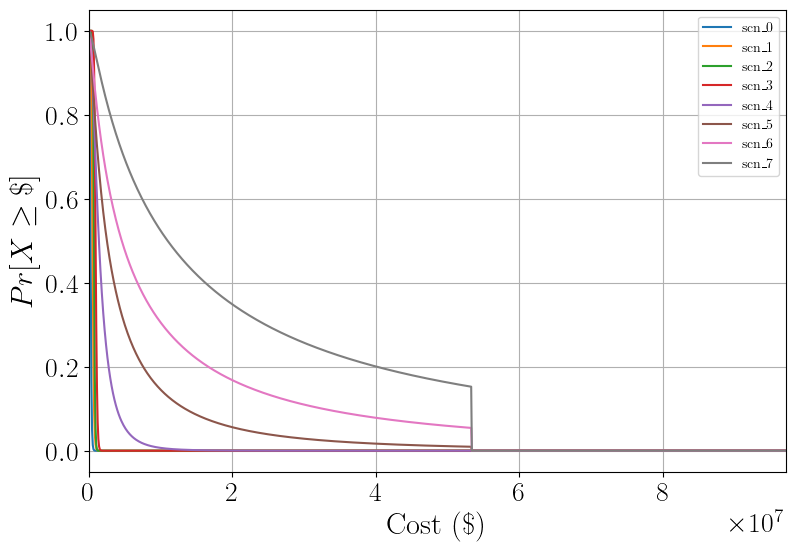

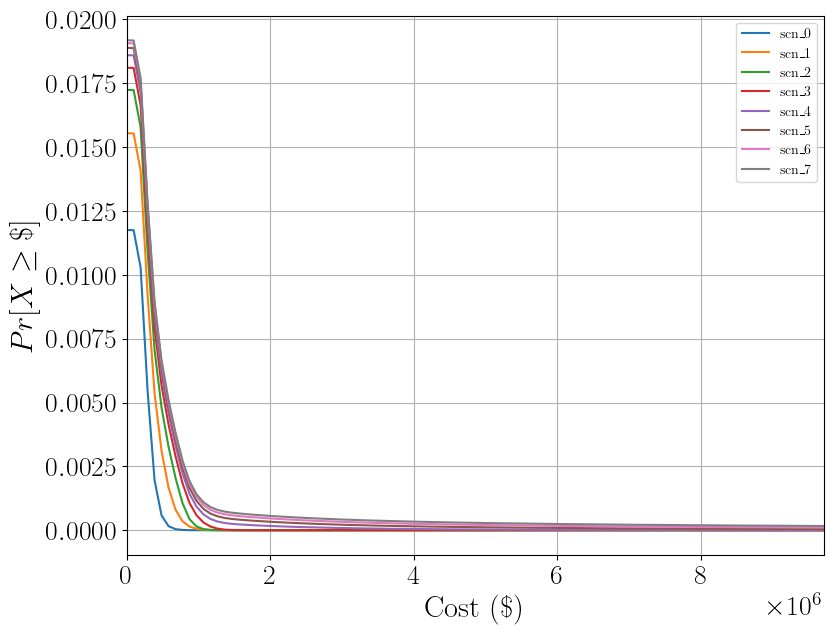

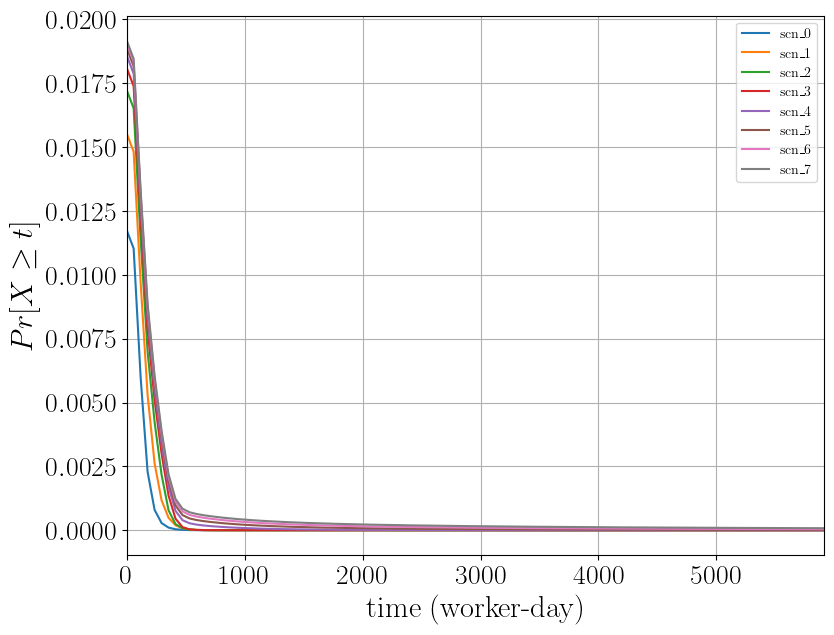

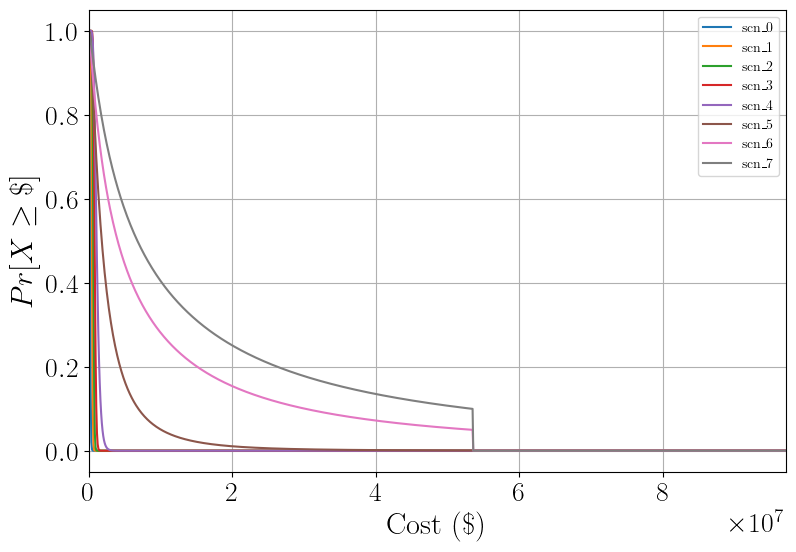

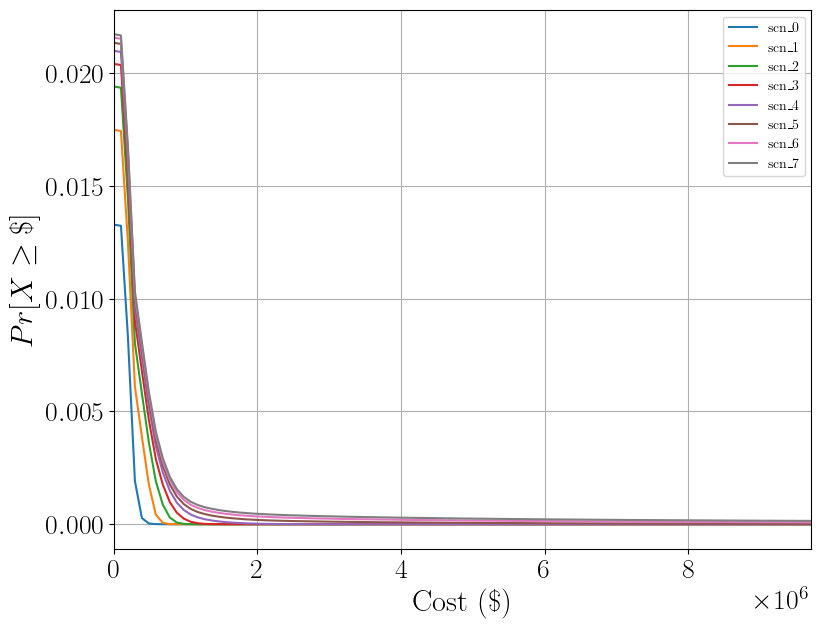

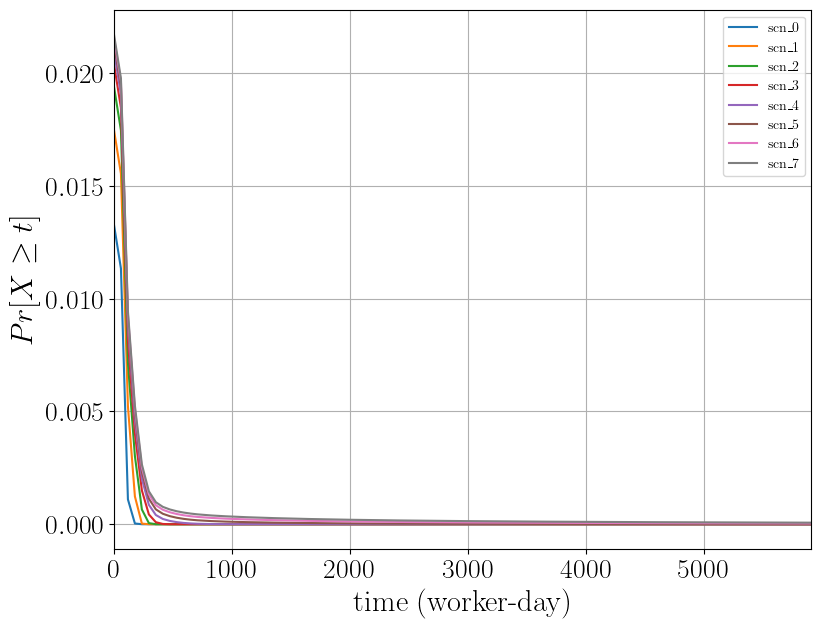

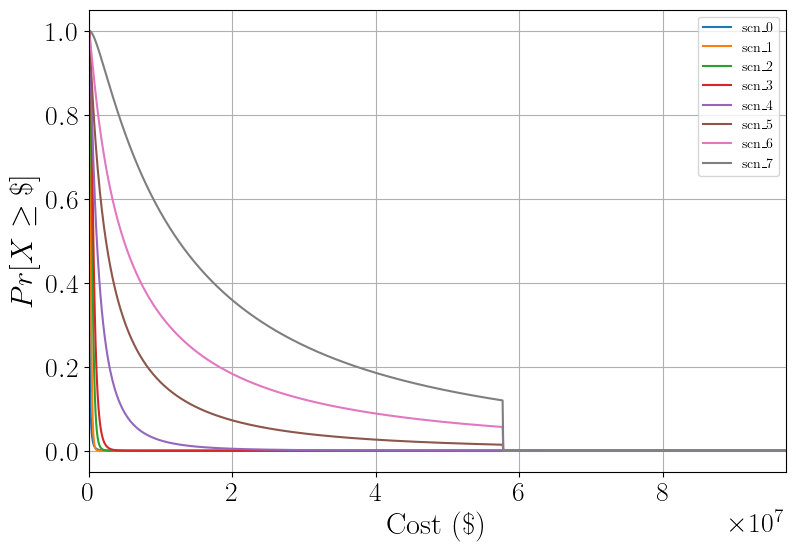

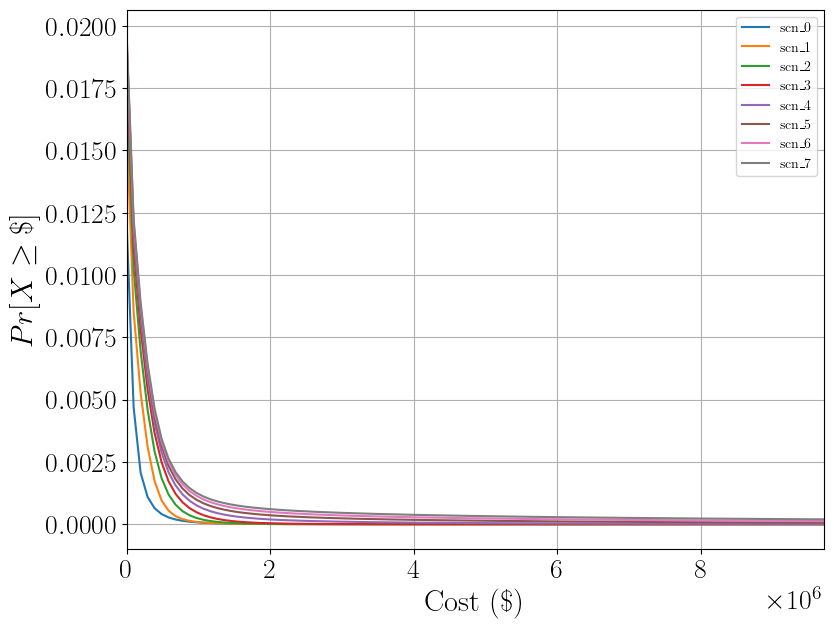

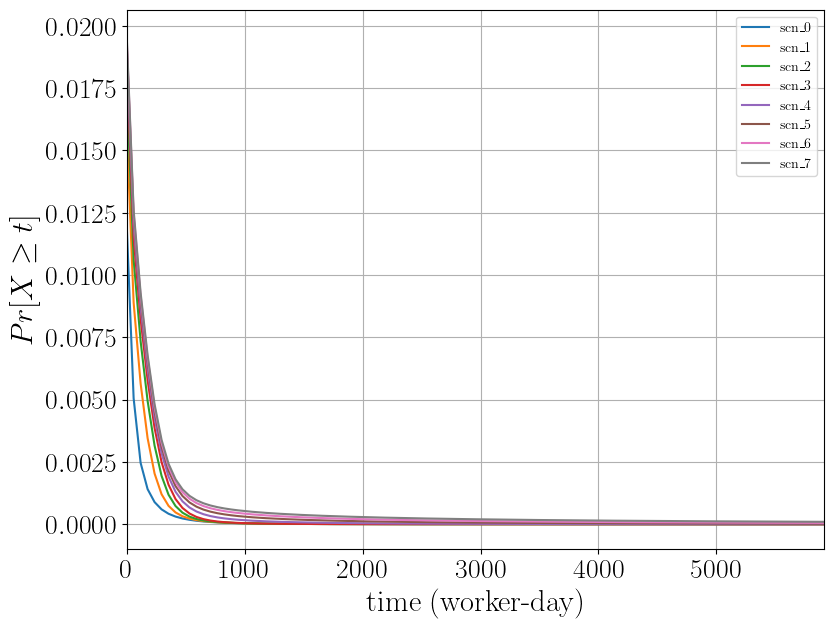

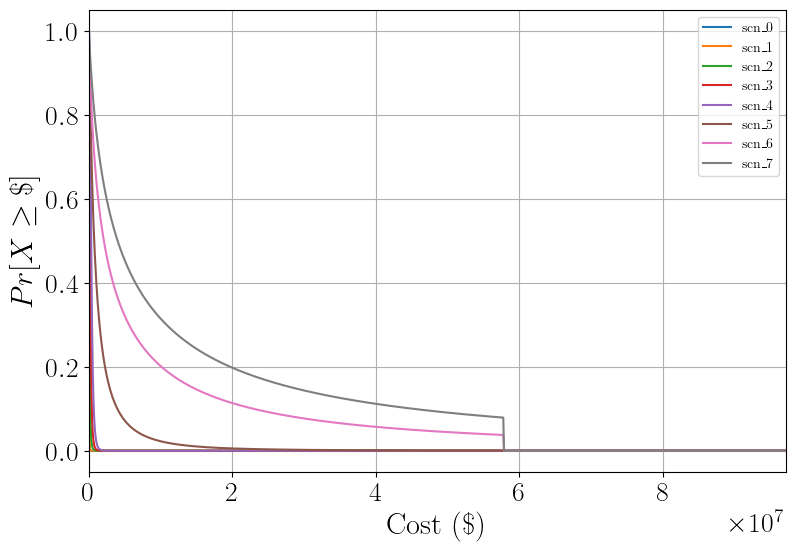

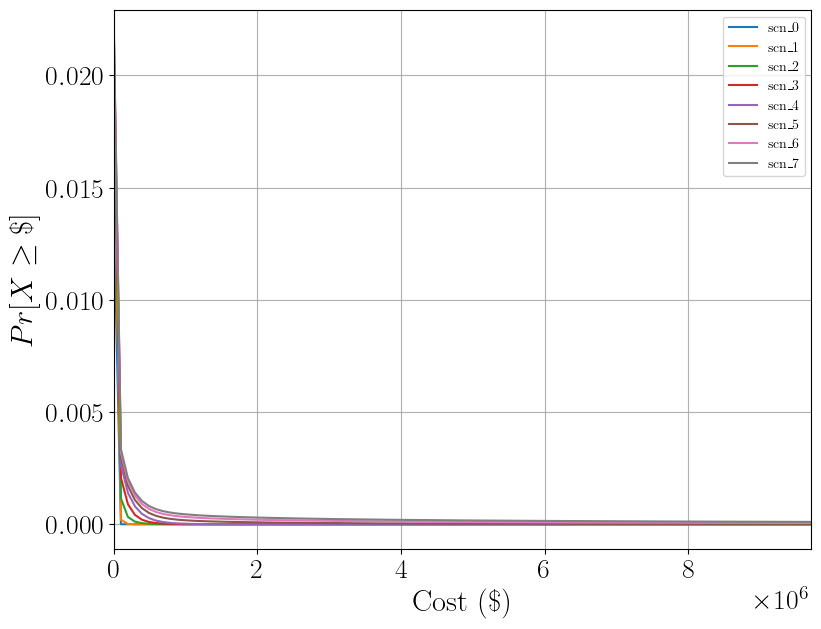

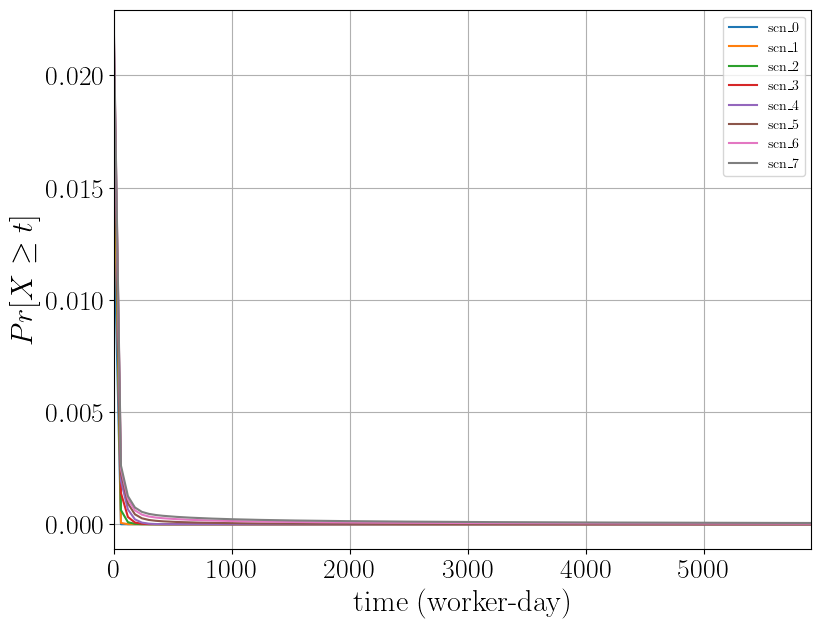

In [46]:
# make lambda function for generic lognormal distribution
import numpy as np
lognorm_f = lambda x,theta,beta: norm(np.log(theta), beta**0.5).cdf(np.log(x))

def validate_lifetime_loss(val_results, hazard_curves,
                           cost_var='cmp_cost_ratio', time_var='cmp_time_ratio'):
    
    
    # get return rate of the three Sa_avg of the IDA
    T_m = val_results['T_m'].unique().item()
    T_list = [0.0, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0]
    idx_between = bisect.bisect(T_list, T_m)
    
    # 0 is total
    below_lambda = hazard_curves[idx_between-1]['data'][0]['yvalues']
    below_sa = hazard_curves[idx_between-1]['metadata']['xvalues']
    
    above_lambda = hazard_curves[idx_between]['data'][0]['yvalues']
    above_sa = hazard_curves[idx_between]['metadata']['xvalues']
    
    x2 = T_list[idx_between]
    x1 = T_list[idx_between-1]
    # assume that both series have the same length
    sa_T = [(g + h) / 2 for g, h in zip(below_sa, above_sa)]
    lambda_T = [y1+(T_m-x1)*(y2-y1)/(x2-x1) for y1, y2 in zip(below_lambda, above_lambda)]
    
    # # grab Sa_avg of IDA
    # sa_bins = np.array([float(sa) for sa in val_results['sa_avg'].unique()])
    
    # grab Sa_Tm average of IDA level
    ida_levels = np.array([float(lvl) for lvl in val_results['ida_level'].unique()])
    sa_bins = np.zeros(len(ida_levels))
    for scn_idx, ida_lvl in enumerate(ida_levels):
        ida_df = val_results[val_results['ida_level']==ida_lvl]
        sa_bins[scn_idx] = ida_df['sa_tm'].mean()
    
    # breakpoint()
    # interpolate in logspace
    log_lambda = np.log(lambda_T)
    log_lambda[log_lambda == -np.inf] = -100
    lambda_bins = np.exp(np.interp(np.log(sa_bins), np.log(sa_T), log_lambda))
    
    # lambda_bins = np.array([1e-2, 2e-3, 2e-4])
    
    
    # two choice: fit lognormal OR use ECDF
    f = lambda x,theta,beta: norm(np.log(theta), beta).cdf(np.log(x))
    # plt.close('all')
    
    # value to renormalize ratio into consequences
    total_cmp_cost = val_results['total_cmp_cost'].median()
    total_cmp_time = val_results['total_cmp_time'].median()
    
    # value to set max of linspace array of consequences of exceedance curve
    repl_cost_max = val_results['replacement_cost'].median()
    repl_time_max = val_results['replacement_time'].median()
    cost_loss_values = np.linspace(1e-4, repl_cost_max, 1000)
    time_loss_values = np.linspace(1e-4, repl_time_max, 1000)
    
    
    
    cost_scns = np.zeros([len(cost_loss_values), len(sa_bins)])
    time_scns = np.zeros([len(time_loss_values), len(sa_bins)])
    
    for scn_idx, ida_lvl in enumerate(ida_levels):
        ida_df = val_results[val_results['ida_level']==ida_lvl]

        # from individual IDA result, calculate distribution
        cost_ratio_ida = ida_df[cost_var]
        theta_cost = np.exp(np.log(cost_ratio_ida).mean())
        beta_cost = np.log(cost_ratio_ida).var()
        
        
        time_ratio_ida = ida_df[time_var]
        theta_time = np.exp(np.log(time_ratio_ida).mean())
        beta_time = np.log(time_ratio_ida).var()
        
        # unnormalize loss ratio back to loss
        cost_bins = cost_ratio_ida*total_cmp_cost
        time_bins = time_ratio_ida*total_cmp_time
        
        # make exceedance curve for each scenario
        # use total replacement just to have a bigger number
        cost_scns[:,scn_idx] = lognorm_f(cost_loss_values, theta_cost*total_cmp_cost, beta_cost)
        time_scns[:,scn_idx] = lognorm_f(time_loss_values, theta_time*total_cmp_time, beta_time)
        
        
    # upper bound of considered replacement
    total_cmp_cost_ub = val_results['total_cmp_cost_ub'].median()
    total_cmp_time_ub = val_results['total_cmp_time_ub'].median()
    cost_scns[cost_loss_values > total_cmp_cost_ub, :] = 1.0
    time_scns[time_loss_values > total_cmp_time_ub, :] = 1.0
    
    
    pr_exceedance_cost = 1 - cost_scns
    pr_exceedance_time = 1 - time_scns
    
    cost_loss_rates = np.multiply(pr_exceedance_cost, lambda_bins)
    time_loss_rates = np.multiply(pr_exceedance_time, lambda_bins)
    
    
    
    import matplotlib.pyplot as plt
    # plt.close('all')
    fig = plt.figure(figsize=(9, 6))
    ax1=fig.add_subplot(1, 1, 1)
    
    for scn_idx in range(len(sa_bins)):
        ax1.plot(cost_loss_values, pr_exceedance_cost[:,scn_idx], label='scn_'+str(scn_idx))
    ax1.legend()
    ax1.set_xlabel(r'Cost (\$)', fontsize=axis_font)
    ax1.set_ylabel(r'$Pr[X \geq \$]$', fontsize=axis_font)
    ax1.grid()
    ax1.set_xlim([0, repl_cost_max])
    
    
    import matplotlib.pyplot as plt
    # plt.close('all')
    fig = plt.figure(figsize=(9, 7))
    ax1=fig.add_subplot(1, 1, 1)
    
    for scn_idx in range(len(sa_bins)):
        ax1.plot(cost_loss_values, cost_loss_rates[:,:scn_idx+1].sum(axis=1), label='scn_'+str(scn_idx))
    ax1.legend()
    ax1.set_xlabel(r'Cost (\$)', fontsize=axis_font)
    ax1.set_ylabel(r'$Pr[X \geq \$]$', fontsize=axis_font)
    ax1.grid()
    ax1.set_xlim([0, 0.1*repl_cost_max])
    
    fig = plt.figure(figsize=(9, 7))
    ax1=fig.add_subplot(1, 1, 1)
    
    for scn_idx in range(len(sa_bins)):
        ax1.plot(time_loss_values, time_loss_rates[:,:scn_idx+1].sum(axis=1), label='scn_'+str(scn_idx))
    ax1.legend()
    ax1.set_xlabel(r'time (worker-day)', fontsize=axis_font)
    ax1.set_ylabel(r'$Pr[X \geq t]$', fontsize=axis_font)
    ax1.grid()
    ax1.set_xlim([0, 0.1*repl_time_max])
    
    # breakpoint()
    
    # multiply scenarios' exceedance curve with corresponding return rate
    # sum across all scenarios
    agg_cost_exceedance_rate = pr_exceedance_cost @ lambda_bins
    agg_time_exceedance_rate = pr_exceedance_time @ lambda_bins
    
    # integrate to attain lifetime dollar, time
    mean_cumulative_annual_cost = np.trapz(agg_cost_exceedance_rate, cost_loss_values)
    mean_cumulative_annual_time = np.trapz(agg_time_exceedance_rate, time_loss_values)
    
    # renormalize
    mcac_ratio = mean_cumulative_annual_cost/total_cmp_cost
    mcat_ratio = mean_cumulative_annual_time/total_cmp_time
    
    return mean_cumulative_annual_cost, mean_cumulative_annual_time, mcac_ratio, mcat_ratio

plt.close('all')
mcac_mf_tfp, mcat_mf_tfp, mcac_ratio_mf_tfp, mcat_ratio_mf_tfp = validate_lifetime_loss(
    mf_tfp_val_results, site_hazard_curves)

mcac_mf_lrb, mcat_mf_lrb, mcac_ratio_mf_lrb, mcat_ratio_mf_lrb = validate_lifetime_loss(
    mf_lrb_val_results, site_hazard_curves)

mcac_cbf_tfp, mcat_cbf_tfp, mcac_ratio_cbf_tfp, mcat_ratio_cbf_tfp = validate_lifetime_loss(
    cbf_tfp_val_results, site_hazard_curves)

mcac_cbf_lrb, mcat_cbf_lrb, mcac_ratio_cbf_lrb, mcat_ratio_cbf_lrb = validate_lifetime_loss(
    cbf_lrb_val_results, site_hazard_curves)